## A model build using TweetBERT to classify tweet as causal or non-causal 

The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [47]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
# print("Cuda available: ", torch.cuda.is_available())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
dataPath = "../data/Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-3    
adam_eps = 1e-8
epochs = 35
num_warmup_steps = 0
early_patience = 5 # how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 32
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2

metrics_average = "binary" # this will give measure for class_1,i.e., causal class

saveModelName = "../model_causal-sentences/model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved

#### Checking if thec cuda is available and then select the `gpu`

In [48]:
########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print("Selected {} for this notebook".format(device))

Cuda available:  True
Selected cuda:1 for this notebook


In [49]:
##### DATA TO LOAD ######

data_sheet1 = pd.read_excel(dataPath, sheet_name="round0")
data_sheet1 = data_sheet1[data_sheet1["Causal association"].notnull()] # some tweets at the end are not labeled yet
data_sheet1 = data_sheet1[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data sheet 1 (tweets!):")
print(data_sheet1["Causal association"].value_counts())
print()


##### additional data labeled through active learning strategy - round 1 ########
data_sheet2 = pd.read_excel(dataPath, sheet_name="round1")
data_sheet2 = data_sheet2[data_sheet2["Causal association"].notnull()]
data_sheet2 = data_sheet2[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_sheet2.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("New labeled data after active learning (sentences!)")
print(data_sheet2["Causal association"].value_counts())


#### merge both datasets ######
data = data_sheet1.append(data_sheet2)
print("\nAfter merge:")
print(data["Causal association"].value_counts())
data.head()

Data sheet 1 (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64

New labeled data after active learning (sentences!)
0.0    1763
1.0     429
Name: Causal association, dtype: int64

After merge:
0.0    5473
1.0    1719
Name: Causal association, dtype: int64


,full_text,Intent,Cause,Effect,Causal association
0,"tonight , I learned my older girl will back he...",NaN,NaN,NaN,0.0
1,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0.0
2,⬇ ️ ⬇ ️ ⬇ ️ THIS ⬇ ️ ⬇ ️ ⬇ ️ My wife has type ...,mS,NaN,NaN,0.0
3,USER Cheers ! Have one for this diabetic too !,mS,NaN,NaN,0.0
4,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0


### Preprocessing

In [50]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [51]:
### Split tweets into sentences (train classifier on sentence level) ####

print("N tweets:", data.shape[0])

data["tokenized"] = data["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences = split_tweets_to_sentences(data)
print("N sentences:", dataSentences.shape[0])
dataSentences.head()

N tweets: 7192
N sentences: 13948


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
1,Fiercely .,,NaN,NaN,0,"[Fiercely, .]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0,"[USER, USER, I, knew, diabetes, and, fibromyal..."
4,:face_with_rolling_eyes:,joke,NaN,NaN,0,[:face_with_rolling_eyes:]


In [52]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("N sentences before filtering: ", dataSentences.shape[0])
dataSentFiltered = dataSentences[~dataSentences["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered = dataSentFiltered[dataSentFiltered["tokenized"].map(len) > 3] 
print("N sentences after filtering: ", dataSentFiltered.shape[0])
print("Distribution:")
print(dataSentFiltered["Causal association"].value_counts())
dataSentFiltered.head()

N sentences before filtering:  13948
N sentences after filtering:  10468
Distribution:
0.0    9009
1.0    1459
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,NaN,NaN,0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI..."
6,I 'm a trans woman .,,NaN,NaN,0,"[I, 'm, a, trans, woman, .]"
7,"Both of us could use a world where "" brave and...",,NaN,NaN,0,"[Both, of, us, could, use, a, world, where, "",..."


### Training

In [53]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text = dataSentFiltered["sentence"].map(normalizeTweet).values.tolist()
labels = dataSentFiltered["Causal association"].values.tolist()
# first split the data into training and testing label in the ratio of 90:10
train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=test_to_train_ratio, stratify=labels, random_state=9)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=val_to_train_ratio, stratify=train_labels, random_state=9)



data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(labels), *data_count_info.round(4).to_list()))
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(train_labels), *train_count_info.round(4).to_list()))
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(val_labels), *val_count_info.round(4).to_list()))
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(test_labels), *test_count_info.round(4).to_list()))
print("Balancing class wts: for 0 = {}, for 1 = {}".format(
    *class_weight.round(4).to_list()))

All: Count = 10468, % of 0 = 0.8606, % of 1 = 0.1394
Train: Count = 7536, % of 0 = 0.8607, % of 1 = 0.1393
Val: Count = 1885, % of 0 = 0.8605, % of 1 = 0.1395
Test: Count = 1047, % of 0 = 0.8606, % of 1 = 0.1394
Balancing class wts: for 0 = 0.5809, for 1 = 3.5886


In [55]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


7536
1885
1047


### Evaluation Metrics

In [56]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    precision, recall, f1, _ = precision_recall_fscore_support(labels,pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



### Model defintion

In [57]:


class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5

In [58]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CausalityBERT()
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.5.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.encoder.layer.2.attention.self.value.bias', 'roberta.encoder.layer.7.attention.output.dense.bias', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.3.output.dense.bias', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.5.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.bias'

In [59]:
############ TRAINING #############

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0


for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/471 [00:08<1:03:39,  8.13s/it]

loss: tensor(0.5664, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 2/471 [00:16<1:02:33,  8.00s/it]

loss: tensor(1.5664, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 3/471 [00:23<1:02:03,  7.96s/it]

loss: tensor(1.7592, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 4/471 [00:31<1:01:56,  7.96s/it]

loss: tensor(0.0966, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 5/471 [00:39<1:01:21,  7.90s/it]

loss: tensor(0.9791, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 6/471 [00:47<1:01:13,  7.90s/it]

loss: tensor(0.8910, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:55<1:00:24,  7.81s/it]

loss: tensor(0.7306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:03<1:00:19,  7.82s/it]

loss: tensor(0.6521, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:10<59:56,  7.78s/it]  

loss: tensor(0.7132, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:18<1:00:07,  7.82s/it]

loss: tensor(0.6487, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:26<59:19,  7.74s/it]  

loss: tensor(0.9895, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:33<59:13,  7.74s/it]

loss: tensor(0.8164, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:41<58:45,  7.70s/it]

loss: tensor(0.7831, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:49<58:48,  7.72s/it]

loss: tensor(0.6902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [01:57<59:45,  7.86s/it]

loss: tensor(0.7249, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:05<1:00:38,  8.00s/it]

loss: tensor(0.5921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 17/471 [02:13<1:00:02,  7.93s/it]

loss: tensor(0.3685, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 18/471 [02:21<1:00:00,  7.95s/it]

loss: tensor(0.4838, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 19/471 [02:29<59:57,  7.96s/it]  

loss: tensor(0.1013, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 20/471 [02:37<59:58,  7.98s/it]

loss: tensor(1.5083, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 21/471 [02:45<59:10,  7.89s/it]

loss: tensor(2.1476, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 22/471 [02:53<58:57,  7.88s/it]

loss: tensor(2.0305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 23/471 [03:01<58:45,  7.87s/it]

loss: tensor(0.8159, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 24/471 [03:08<58:10,  7.81s/it]

loss: tensor(0.5110, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 25/471 [03:16<58:13,  7.83s/it]

loss: tensor(0.7940, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:24<57:48,  7.79s/it]

loss: tensor(0.7243, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 27/471 [03:32<58:16,  7.87s/it]

loss: tensor(0.7158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 28/471 [03:40<58:03,  7.86s/it]

loss: tensor(0.8693, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:48<58:07,  7.89s/it]

loss: tensor(0.7147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [03:55<57:41,  7.85s/it]

loss: tensor(0.8132, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:03<57:14,  7.80s/it]

loss: tensor(0.7635, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 32/471 [04:11<57:18,  7.83s/it]

loss: tensor(1.0930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 33/471 [04:19<57:19,  7.85s/it]

loss: tensor(0.9066, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:27<57:32,  7.90s/it]

loss: tensor(0.6805, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:35<57:39,  7.93s/it]

loss: tensor(0.6964, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 36/471 [04:43<57:35,  7.94s/it]

loss: tensor(0.5049, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 37/471 [04:51<57:40,  7.97s/it]

loss: tensor(0.8527, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 38/471 [04:59<57:42,  8.00s/it]

loss: tensor(0.7695, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 39/471 [05:07<57:14,  7.95s/it]

loss: tensor(1.0785, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 40/471 [05:15<56:54,  7.92s/it]

loss: tensor(1.2969, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 41/471 [05:23<56:39,  7.91s/it]

loss: tensor(0.7074, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:30<56:22,  7.88s/it]

loss: tensor(0.6600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:38<56:05,  7.86s/it]

loss: tensor(0.5765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:46<55:48,  7.84s/it]

loss: tensor(0.6443, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [05:54<55:35,  7.83s/it]

loss: tensor(0.7047, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 46/471 [06:02<56:08,  7.93s/it]

loss: tensor(0.8798, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 47/471 [06:10<56:03,  7.93s/it]

loss: tensor(0.6092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:18<55:54,  7.93s/it]

loss: tensor(0.8295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:26<55:44,  7.92s/it]

loss: tensor(0.6891, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:34<55:20,  7.89s/it]

loss: tensor(0.7683, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:41<54:55,  7.85s/it]

loss: tensor(0.5643, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [06:49<54:45,  7.84s/it]

loss: tensor(0.6379, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [06:57<54:38,  7.84s/it]

loss: tensor(0.5728, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:05<54:36,  7.86s/it]

loss: tensor(0.7337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 55/471 [07:13<54:57,  7.93s/it]

loss: tensor(0.6235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:21<54:30,  7.88s/it]

loss: tensor(0.7864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 57/471 [07:28<54:12,  7.86s/it]

loss: tensor(0.6098, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 58/471 [07:36<54:02,  7.85s/it]

loss: tensor(0.5366, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 59/471 [07:44<53:47,  7.83s/it]

loss: tensor(1.0596, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 60/471 [07:52<53:38,  7.83s/it]

loss: tensor(0.5634, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 61/471 [08:00<53:39,  7.85s/it]

loss: tensor(0.6140, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:08<53:42,  7.88s/it]

loss: tensor(0.7603, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:16<53:47,  7.91s/it]

loss: tensor(0.6526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 64/471 [08:24<53:57,  7.95s/it]

loss: tensor(0.5985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:32<54:16,  8.02s/it]

loss: tensor(0.6451, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:40<54:13,  8.03s/it]

loss: tensor(0.6767, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [08:48<53:28,  7.94s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 68/471 [08:56<52:59,  7.89s/it]

loss: tensor(0.5517, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 69/471 [09:03<52:56,  7.90s/it]

loss: tensor(0.8712, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:12<53:24,  7.99s/it]

loss: tensor(0.7687, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▌        | 71/471 [09:20<53:57,  8.09s/it]

loss: tensor(0.5574, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:28<53:59,  8.12s/it]

loss: tensor(0.5961, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:36<54:08,  8.16s/it]

loss: tensor(0.7492, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [09:45<54:03,  8.17s/it]

loss: tensor(0.6681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [09:53<54:07,  8.20s/it]

loss: tensor(0.5233, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 76/471 [10:01<54:22,  8.26s/it]

loss: tensor(0.7378, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:10<54:32,  8.31s/it]

loss: tensor(0.6726, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:18<54:21,  8.30s/it]

loss: tensor(0.7250, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:26<54:04,  8.28s/it]

loss: tensor(0.6532, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 80/471 [10:35<54:04,  8.30s/it]

loss: tensor(0.6110, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:43<54:05,  8.32s/it]

loss: tensor(0.5191, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [10:51<54:09,  8.35s/it]

loss: tensor(0.7128, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [11:00<54:00,  8.35s/it]

loss: tensor(0.6568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:08<53:22,  8.28s/it]

loss: tensor(0.7557, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:16<52:30,  8.16s/it]

loss: tensor(0.6120, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 86/471 [11:24<51:43,  8.06s/it]

loss: tensor(0.5777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:31<51:11,  8.00s/it]

loss: tensor(0.6259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:39<50:41,  7.94s/it]

loss: tensor(0.6355, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [11:47<50:38,  7.95s/it]

loss: tensor(0.5795, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [11:55<50:46,  8.00s/it]

loss: tensor(0.6610, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:03<50:26,  7.96s/it]

loss: tensor(0.7369, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:11<50:01,  7.92s/it]

loss: tensor(0.6511, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:19<49:40,  7.89s/it]

loss: tensor(0.7029, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:27<49:21,  7.86s/it]

loss: tensor(0.7643, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:34<49:08,  7.84s/it]

loss: tensor(0.4430, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:42<48:56,  7.83s/it]

loss: tensor(0.5265, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [12:50<48:51,  7.84s/it]

loss: tensor(0.5647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [12:58<49:16,  7.93s/it]

loss: tensor(0.6535, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [13:07<49:55,  8.05s/it]

loss: tensor(0.6202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:15<50:26,  8.16s/it]

loss: tensor(0.8499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:23<50:10,  8.14s/it]

loss: tensor(0.7839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:31<49:39,  8.08s/it]

loss: tensor(0.6692, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:39<49:19,  8.04s/it]

loss: tensor(0.6684, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:47<48:46,  7.97s/it]

loss: tensor(0.5365, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 105/471 [13:55<48:27,  7.94s/it]

loss: tensor(0.7055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 106/471 [14:03<48:17,  7.94s/it]

loss: tensor(0.6157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 107/471 [14:10<48:05,  7.93s/it]

loss: tensor(0.6204, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 108/471 [14:18<47:52,  7.91s/it]

loss: tensor(0.3481, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 109/471 [14:26<47:38,  7.90s/it]

loss: tensor(0.6193, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 110/471 [14:34<48:13,  8.02s/it]

loss: tensor(0.6181, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▎       | 111/471 [14:42<48:05,  8.01s/it]

loss: tensor(0.8416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 112/471 [14:51<48:37,  8.13s/it]

loss: tensor(0.5084, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 113/471 [14:59<49:00,  8.21s/it]

loss: tensor(0.9343, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 114/471 [15:08<49:18,  8.29s/it]

loss: tensor(1.1195, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:16<48:31,  8.18s/it]

loss: tensor(0.9338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 116/471 [15:24<47:50,  8.09s/it]

loss: tensor(0.3065, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:31<47:24,  8.04s/it]

loss: tensor(0.8958, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [15:40<47:37,  8.10s/it]

loss: tensor(0.5178, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [15:48<47:43,  8.13s/it]

loss: tensor(0.8337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [15:56<47:24,  8.10s/it]

loss: tensor(0.5465, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 121/471 [16:04<47:12,  8.09s/it]

loss: tensor(0.8654, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 122/471 [16:12<46:52,  8.06s/it]

loss: tensor(0.5929, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 123/471 [16:20<46:35,  8.03s/it]

loss: tensor(0.7787, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 124/471 [16:28<46:17,  8.00s/it]

loss: tensor(0.5888, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 125/471 [16:36<46:04,  7.99s/it]

loss: tensor(0.5776, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:44<45:35,  7.93s/it]

loss: tensor(0.5740, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 127/471 [16:52<45:22,  7.91s/it]

loss: tensor(0.6522, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [16:59<45:17,  7.92s/it]

loss: tensor(0.3276, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 129/471 [17:07<44:56,  7.88s/it]

loss: tensor(0.5270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 130/471 [17:15<44:40,  7.86s/it]

loss: tensor(0.7636, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 131/471 [17:23<44:26,  7.84s/it]

loss: tensor(0.5781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 132/471 [17:31<44:15,  7.83s/it]

loss: tensor(0.1973, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 133/471 [17:39<44:07,  7.83s/it]

loss: tensor(1.1058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 134/471 [17:46<43:57,  7.83s/it]

loss: tensor(0.9938, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▊       | 135/471 [17:54<43:58,  7.85s/it]

loss: tensor(1.0954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:02<44:08,  7.91s/it]

loss: tensor(0.5504, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:10<44:31,  8.00s/it]

loss: tensor(0.8774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:18<44:00,  7.93s/it]

loss: tensor(0.6561, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:26<43:43,  7.90s/it]

loss: tensor(0.5584, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:34<43:46,  7.94s/it]

loss: tensor(0.6931, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [18:42<44:03,  8.01s/it]

loss: tensor(0.7754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [18:51<44:15,  8.07s/it]

loss: tensor(0.6917, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 143/471 [18:59<44:20,  8.11s/it]

loss: tensor(1.1751, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:07<44:16,  8.12s/it]

loss: tensor(0.7509, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:15<43:53,  8.08s/it]

loss: tensor(0.4568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:23<43:36,  8.05s/it]

loss: tensor(0.6336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:31<44:15,  8.20s/it]

loss: tensor(0.6506, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:39<43:49,  8.14s/it]

loss: tensor(0.6438, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 149/471 [19:47<43:30,  8.11s/it]

loss: tensor(0.8695, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [19:55<43:17,  8.09s/it]

loss: tensor(0.4416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:03<43:01,  8.07s/it]

loss: tensor(0.5791, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:12<42:52,  8.06s/it]

loss: tensor(0.8829, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:20<42:44,  8.07s/it]

loss: tensor(0.7896, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 154/471 [20:28<42:35,  8.06s/it]

loss: tensor(0.8450, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:36<42:15,  8.02s/it]

loss: tensor(0.5311, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [20:43<41:55,  7.98s/it]

loss: tensor(0.7726, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [20:51<41:37,  7.95s/it]

loss: tensor(0.7491, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [20:59<41:27,  7.95s/it]

loss: tensor(0.6212, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:07<41:24,  7.96s/it]

loss: tensor(0.5219, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 160/471 [21:15<41:21,  7.98s/it]

loss: tensor(0.6156, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:23<41:18,  7.99s/it]

loss: tensor(0.7798, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:31<41:06,  7.98s/it]

loss: tensor(0.6550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:39<40:55,  7.97s/it]

loss: tensor(0.8322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 164/471 [21:47<40:57,  8.00s/it]

loss: tensor(0.7691, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [21:55<40:50,  8.01s/it]

loss: tensor(0.5845, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:03<40:30,  7.97s/it]

loss: tensor(0.8633, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 167/471 [22:11<40:15,  7.95s/it]

loss: tensor(0.5555, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 168/471 [22:19<40:02,  7.93s/it]

loss: tensor(0.7013, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 169/471 [22:27<39:56,  7.93s/it]

loss: tensor(0.8231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:35<39:58,  7.97s/it]

loss: tensor(0.8812, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [22:43<39:45,  7.95s/it]

loss: tensor(0.8354, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 172/471 [22:51<39:31,  7.93s/it]

loss: tensor(0.5851, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 173/471 [22:59<39:36,  7.97s/it]

loss: tensor(0.5216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:07<39:36,  8.00s/it]

loss: tensor(0.6507, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:15<39:27,  8.00s/it]

loss: tensor(0.6954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 176/471 [23:23<39:26,  8.02s/it]

loss: tensor(0.8988, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:31<39:22,  8.04s/it]

loss: tensor(0.6872, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [23:39<39:19,  8.05s/it]

loss: tensor(0.7435, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [23:47<39:11,  8.05s/it]

loss: tensor(0.6983, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [23:55<39:06,  8.06s/it]

loss: tensor(0.7304, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:03<38:57,  8.06s/it]

loss: tensor(0.6201, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:11<38:49,  8.06s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:19<38:37,  8.05s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:28<38:31,  8.06s/it]

loss: tensor(0.5271, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:36<38:23,  8.05s/it]

loss: tensor(0.5889, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [24:44<38:10,  8.04s/it]

loss: tensor(0.6754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [24:52<38:01,  8.03s/it]

loss: tensor(0.6105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:00<37:45,  8.01s/it]

loss: tensor(0.7641, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 189/471 [25:07<37:27,  7.97s/it]

loss: tensor(0.6577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 190/471 [25:15<37:16,  7.96s/it]

loss: tensor(0.5963, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:23<37:09,  7.96s/it]

loss: tensor(0.7267, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:31<36:54,  7.94s/it]

loss: tensor(0.6298, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 193/471 [25:39<36:39,  7.91s/it]

loss: tensor(0.5117, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [25:47<36:28,  7.90s/it]

loss: tensor(0.7551, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████▏     | 195/471 [25:55<36:21,  7.91s/it]

loss: tensor(0.6513, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 196/471 [26:03<36:29,  7.96s/it]

loss: tensor(0.5788, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:11<36:32,  8.00s/it]

loss: tensor(0.6394, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 198/471 [26:19<36:32,  8.03s/it]

loss: tensor(0.8134, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 199/471 [26:27<36:27,  8.04s/it]

loss: tensor(1.0071, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 200/471 [26:35<36:22,  8.05s/it]

loss: tensor(0.6546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [26:43<36:15,  8.06s/it]

loss: tensor(0.5350, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [26:51<36:03,  8.04s/it]

loss: tensor(0.7036, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [26:59<35:51,  8.03s/it]

loss: tensor(0.5882, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:07<35:44,  8.03s/it]

loss: tensor(0.6765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 205/471 [27:15<35:30,  8.01s/it]

loss: tensor(0.7261, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:23<35:13,  7.98s/it]

loss: tensor(0.7334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:31<35:09,  7.99s/it]

loss: tensor(0.7153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [27:39<35:07,  8.01s/it]

loss: tensor(0.5375, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [27:47<34:59,  8.02s/it]

loss: tensor(0.8186, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [27:55<34:51,  8.02s/it]

loss: tensor(0.6025, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 211/471 [28:03<34:33,  7.97s/it]

loss: tensor(0.8468, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▌     | 212/471 [28:11<34:31,  8.00s/it]

loss: tensor(0.8701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:19<34:30,  8.03s/it]

loss: tensor(0.6289, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:27<34:22,  8.03s/it]

loss: tensor(0.7413, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [28:35<34:12,  8.02s/it]

loss: tensor(0.6229, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 216/471 [28:43<34:05,  8.02s/it]

loss: tensor(0.5158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [28:51<33:59,  8.03s/it]

loss: tensor(0.8503, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▋     | 218/471 [29:00<33:52,  8.03s/it]

loss: tensor(0.4740, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▋     | 219/471 [29:08<33:43,  8.03s/it]

loss: tensor(0.9974, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:16<33:37,  8.04s/it]

loss: tensor(0.5980, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:23<33:17,  7.99s/it]

loss: tensor(0.7735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 222/471 [29:31<33:02,  7.96s/it]

loss: tensor(0.6236, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 223/471 [29:39<32:50,  7.94s/it]

loss: tensor(0.6671, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [29:47<32:37,  7.93s/it]

loss: tensor(0.5920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [29:55<32:29,  7.92s/it]

loss: tensor(0.5002, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 226/471 [30:03<32:21,  7.93s/it]

loss: tensor(0.5623, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:11<32:23,  7.96s/it]

loss: tensor(0.6006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:19<32:16,  7.97s/it]

loss: tensor(0.6722, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:27<32:11,  7.98s/it]

loss: tensor(0.6141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:35<31:59,  7.97s/it]

loss: tensor(0.6521, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [30:43<31:49,  7.96s/it]

loss: tensor(0.6833, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [30:51<31:44,  7.97s/it]

loss: tensor(0.6865, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [30:59<31:39,  7.98s/it]

loss: tensor(0.8266, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 234/471 [31:07<31:33,  7.99s/it]

loss: tensor(0.7510, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:15<31:24,  7.99s/it]

loss: tensor(0.6183, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:23<31:14,  7.98s/it]

loss: tensor(0.5481, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 237/471 [31:31<31:06,  7.98s/it]

loss: tensor(0.5248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 238/471 [31:39<30:58,  7.98s/it]

loss: tensor(0.7093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [31:47<30:44,  7.95s/it]

loss: tensor(0.6185, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 240/471 [31:55<30:31,  7.93s/it]

loss: tensor(0.6928, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 241/471 [32:03<30:38,  7.99s/it]

loss: tensor(0.7215, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 242/471 [32:11<30:43,  8.05s/it]

loss: tensor(0.6117, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 243/471 [32:19<30:28,  8.02s/it]

loss: tensor(0.7551, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 244/471 [32:27<30:12,  7.98s/it]

loss: tensor(0.6749, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 245/471 [32:35<29:58,  7.96s/it]

loss: tensor(0.5560, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [32:43<29:53,  7.97s/it]

loss: tensor(0.6934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 247/471 [32:51<29:44,  7.97s/it]

loss: tensor(0.4562, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 248/471 [32:59<29:37,  7.97s/it]

loss: tensor(0.5312, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:07<29:37,  8.01s/it]

loss: tensor(0.8272, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:15<29:16,  7.95s/it]

loss: tensor(0.5397, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 251/471 [33:22<28:59,  7.91s/it]

loss: tensor(0.5533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:31<29:13,  8.01s/it]

loss: tensor(0.5825, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [33:39<29:05,  8.01s/it]

loss: tensor(0.6387, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [33:46<28:51,  7.98s/it]

loss: tensor(0.5665, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [33:55<28:45,  7.99s/it]

loss: tensor(0.4735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [34:02<28:35,  7.98s/it]

loss: tensor(0.8323, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:10<28:26,  7.97s/it]

loss: tensor(0.7231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 258/471 [34:18<28:18,  7.97s/it]

loss: tensor(0.6824, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:26<28:07,  7.96s/it]

loss: tensor(0.7597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [34:35<28:28,  8.10s/it]

loss: tensor(0.6188, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [34:43<28:29,  8.14s/it]

loss: tensor(0.6766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [34:51<28:13,  8.10s/it]

loss: tensor(0.5118, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [34:59<27:57,  8.07s/it]

loss: tensor(0.6171, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:07<27:47,  8.06s/it]

loss: tensor(0.6639, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:15<28:05,  8.18s/it]

loss: tensor(0.5864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:24<28:14,  8.27s/it]

loss: tensor(0.6457, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:32<27:54,  8.21s/it]

loss: tensor(0.4691, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:40<27:34,  8.15s/it]

loss: tensor(0.7304, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [35:48<27:21,  8.12s/it]

loss: tensor(0.8208, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [35:56<27:05,  8.09s/it]

loss: tensor(0.7509, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:04<27:05,  8.13s/it]

loss: tensor(0.7989, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:12<26:51,  8.10s/it]

loss: tensor(0.5119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 273/471 [36:20<26:41,  8.09s/it]

loss: tensor(0.5596, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:28<26:30,  8.07s/it]

loss: tensor(0.5723, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 275/471 [36:37<26:21,  8.07s/it]

loss: tensor(0.4598, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [36:44<26:07,  8.04s/it]

loss: tensor(0.8640, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [36:53<26:10,  8.10s/it]

loss: tensor(0.8295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [37:01<26:11,  8.14s/it]

loss: tensor(0.7525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:09<26:21,  8.24s/it]

loss: tensor(0.5257, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:18<26:28,  8.32s/it]

loss: tensor(0.8416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:26<26:03,  8.23s/it]

loss: tensor(0.6415, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:34<25:42,  8.16s/it]

loss: tensor(0.6114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 283/471 [37:42<25:26,  8.12s/it]

loss: tensor(0.5523, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [37:50<25:07,  8.06s/it]

loss: tensor(0.9792, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [37:58<24:55,  8.04s/it]

loss: tensor(0.7474, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:06<25:09,  8.16s/it]

loss: tensor(0.7269, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:14<24:53,  8.12s/it]

loss: tensor(0.7020, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:22<24:41,  8.10s/it]

loss: tensor(0.3986, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 289/471 [38:30<24:30,  8.08s/it]

loss: tensor(0.8263, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:38<24:18,  8.06s/it]

loss: tensor(0.5969, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 291/471 [38:46<24:09,  8.05s/it]

loss: tensor(0.8264, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [38:54<23:59,  8.04s/it]

loss: tensor(0.6038, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [39:03<23:50,  8.03s/it]

loss: tensor(0.5731, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:11<23:41,  8.03s/it]

loss: tensor(0.6620, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:19<23:35,  8.04s/it]

loss: tensor(0.5692, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:27<23:27,  8.04s/it]

loss: tensor(0.5964, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:35<23:20,  8.05s/it]

loss: tensor(0.6885, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:43<23:20,  8.09s/it]

loss: tensor(0.4779, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 299/471 [39:51<23:22,  8.16s/it]

loss: tensor(0.4546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▎   | 300/471 [39:59<23:12,  8.15s/it]

loss: tensor(0.6801, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 301/471 [40:07<22:57,  8.10s/it]

loss: tensor(0.5735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:15<22:49,  8.11s/it]

loss: tensor(0.7844, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:24<22:43,  8.12s/it]

loss: tensor(0.3942, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:32<22:37,  8.13s/it]

loss: tensor(0.5234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 305/471 [40:40<22:31,  8.14s/it]

loss: tensor(0.6839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [40:48<22:19,  8.12s/it]

loss: tensor(0.5860, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 307/471 [40:56<22:25,  8.21s/it]

loss: tensor(0.5715, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 308/471 [41:05<22:23,  8.24s/it]

loss: tensor(0.4743, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:13<22:21,  8.28s/it]

loss: tensor(0.4204, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:21<22:01,  8.21s/it]

loss: tensor(0.9038, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:29<21:40,  8.13s/it]

loss: tensor(0.7236, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [41:37<21:21,  8.06s/it]

loss: tensor(0.4771, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:45<21:09,  8.03s/it]

loss: tensor(0.5317, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [41:53<20:59,  8.02s/it]

loss: tensor(0.7628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [42:01<20:53,  8.03s/it]

loss: tensor(0.6033, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [42:09<20:47,  8.05s/it]

loss: tensor(0.4609, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 317/471 [42:17<20:40,  8.05s/it]

loss: tensor(0.5820, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:26<20:47,  8.16s/it]

loss: tensor(0.6455, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:34<20:45,  8.19s/it]

loss: tensor(0.5597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [42:42<20:26,  8.12s/it]

loss: tensor(0.8387, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 321/471 [42:50<20:12,  8.08s/it]

loss: tensor(0.5516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 322/471 [42:58<20:21,  8.20s/it]

loss: tensor(0.6337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [43:06<20:08,  8.16s/it]

loss: tensor(0.7541, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:14<19:59,  8.16s/it]

loss: tensor(0.6189, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 325/471 [43:23<20:07,  8.27s/it]

loss: tensor(0.5750, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 326/471 [43:31<20:05,  8.31s/it]

loss: tensor(0.4755, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:40<20:09,  8.40s/it]

loss: tensor(0.9572, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [43:48<19:58,  8.38s/it]

loss: tensor(0.6826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|██████▉   | 329/471 [43:56<19:33,  8.26s/it]

loss: tensor(0.5793, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [44:05<19:21,  8.24s/it]

loss: tensor(0.4604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [44:13<19:10,  8.22s/it]

loss: tensor(0.7073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:21<19:12,  8.29s/it]

loss: tensor(0.8731, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:29<18:53,  8.21s/it]

loss: tensor(0.5472, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:37<18:38,  8.16s/it]

loss: tensor(0.5309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [44:46<18:38,  8.23s/it]

loss: tensor(0.6051, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [44:54<18:44,  8.33s/it]

loss: tensor(0.4101, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [45:03<18:47,  8.42s/it]

loss: tensor(0.6028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [45:11<18:26,  8.32s/it]

loss: tensor(0.6625, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:19<18:08,  8.25s/it]

loss: tensor(0.6030, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 340/471 [45:27<17:53,  8.19s/it]

loss: tensor(0.8013, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:35<17:39,  8.15s/it]

loss: tensor(0.6934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:43<17:28,  8.13s/it]

loss: tensor(0.8048, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:52<17:29,  8.20s/it]

loss: tensor(0.6747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [46:00<17:35,  8.31s/it]

loss: tensor(0.6242, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 345/471 [46:08<17:20,  8.26s/it]

loss: tensor(0.6219, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:16<17:04,  8.19s/it]

loss: tensor(0.5718, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 347/471 [46:24<16:42,  8.09s/it]

loss: tensor(0.6516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 348/471 [46:32<16:24,  8.00s/it]

loss: tensor(0.6721, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 349/471 [46:40<16:10,  7.95s/it]

loss: tensor(0.5684, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 350/471 [46:48<16:01,  7.95s/it]

loss: tensor(0.5864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [46:55<15:48,  7.90s/it]

loss: tensor(0.4945, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [47:03<15:36,  7.87s/it]

loss: tensor(0.6610, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 353/471 [47:12<15:42,  7.98s/it]

loss: tensor(0.3953, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:20<15:35,  8.00s/it]

loss: tensor(0.9657, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 355/471 [47:28<15:27,  8.00s/it]

loss: tensor(0.9006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 356/471 [47:35<15:18,  7.98s/it]

loss: tensor(0.5881, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:44<15:26,  8.13s/it]

loss: tensor(0.4756, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [47:52<15:22,  8.16s/it]

loss: tensor(0.4122, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [48:00<15:04,  8.08s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [48:08<14:48,  8.01s/it]

loss: tensor(0.7140, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:16<14:34,  7.95s/it]

loss: tensor(0.8543, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:24<14:24,  7.93s/it]

loss: tensor(0.6469, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:32<14:15,  7.92s/it]

loss: tensor(0.4247, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:39<14:04,  7.90s/it]

loss: tensor(0.6282, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [48:47<13:53,  7.87s/it]

loss: tensor(0.7116, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [48:55<13:47,  7.88s/it]

loss: tensor(1.0241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [49:03<13:38,  7.87s/it]

loss: tensor(0.7057, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [49:11<13:31,  7.88s/it]

loss: tensor(0.4990, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [49:19<13:26,  7.91s/it]

loss: tensor(0.6526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [49:27<13:18,  7.90s/it]

loss: tensor(0.8066, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:35<13:15,  7.95s/it]

loss: tensor(0.5595, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:43<13:07,  7.96s/it]

loss: tensor(0.7432, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:51<12:58,  7.94s/it]

loss: tensor(0.6384, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [49:58<12:45,  7.90s/it]

loss: tensor(0.6499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [50:06<12:35,  7.87s/it]

loss: tensor(0.5479, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [50:14<12:34,  7.94s/it]

loss: tensor(0.5657, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [50:22<12:31,  8.00s/it]

loss: tensor(0.6710, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:30<12:23,  7.99s/it]

loss: tensor(0.7613, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:38<12:15,  7.99s/it]

loss: tensor(0.5503, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:47<12:15,  8.09s/it]

loss: tensor(0.4935, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [50:55<12:05,  8.06s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 382/471 [51:03<11:54,  8.03s/it]

loss: tensor(0.7743, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [51:11<11:45,  8.01s/it]

loss: tensor(0.7208, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:19<11:35,  8.00s/it]

loss: tensor(0.7397, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [51:27<11:26,  7.98s/it]

loss: tensor(0.7501, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:35<11:17,  7.97s/it]

loss: tensor(0.5093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 387/471 [51:42<11:08,  7.95s/it]

loss: tensor(0.6033, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [51:50<10:59,  7.95s/it]

loss: tensor(0.5214, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [51:58<10:51,  7.94s/it]

loss: tensor(0.5701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [52:06<10:43,  7.94s/it]

loss: tensor(0.5631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 391/471 [52:14<10:34,  7.93s/it]

loss: tensor(0.6546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [52:22<10:27,  7.94s/it]

loss: tensor(0.6558, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:30<10:19,  7.95s/it]

loss: tensor(0.7989, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [52:38<10:12,  7.96s/it]

loss: tensor(1.0282, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:46<10:04,  7.95s/it]

loss: tensor(0.5971, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [52:54<09:55,  7.94s/it]

loss: tensor(0.5921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [53:02<09:47,  7.94s/it]

loss: tensor(0.4761, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [53:10<09:39,  7.94s/it]

loss: tensor(0.6817, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:18<09:31,  7.94s/it]

loss: tensor(0.5547, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:26<09:22,  7.92s/it]

loss: tensor(0.7940, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:33<09:13,  7.91s/it]

loss: tensor(0.8624, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [53:41<09:05,  7.91s/it]

loss: tensor(0.6759, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [53:49<08:59,  7.93s/it]

loss: tensor(0.5092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [53:57<08:49,  7.91s/it]

loss: tensor(0.8105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [54:05<08:47,  7.99s/it]

loss: tensor(0.5861, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [54:13<08:37,  7.97s/it]

loss: tensor(0.6232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:21<08:29,  7.96s/it]

loss: tensor(0.7006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:29<08:21,  7.95s/it]

loss: tensor(0.5119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [54:37<08:12,  7.95s/it]

loss: tensor(0.6125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [54:45<08:04,  7.94s/it]

loss: tensor(0.5383, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [54:53<07:56,  7.95s/it]

loss: tensor(0.5043, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [55:01<07:48,  7.94s/it]

loss: tensor(0.7703, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [55:09<07:39,  7.92s/it]

loss: tensor(0.6461, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 414/471 [55:17<07:33,  7.95s/it]

loss: tensor(0.8359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [55:25<07:24,  7.93s/it]

loss: tensor(0.8760, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 416/471 [55:33<07:22,  8.05s/it]

loss: tensor(0.6235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:42<07:21,  8.17s/it]

loss: tensor(0.6395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [55:50<07:17,  8.25s/it]

loss: tensor(0.6786, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [55:58<07:11,  8.30s/it]

loss: tensor(0.6886, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 420/471 [56:07<07:04,  8.33s/it]

loss: tensor(0.7743, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [56:15<06:54,  8.30s/it]

loss: tensor(0.7880, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [56:23<06:45,  8.27s/it]

loss: tensor(0.6911, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:31<06:36,  8.25s/it]

loss: tensor(0.5567, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [56:40<06:27,  8.25s/it]

loss: tensor(0.7234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [56:48<06:19,  8.25s/it]

loss: tensor(0.5052, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 426/471 [56:56<06:11,  8.26s/it]

loss: tensor(0.4862, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [57:04<06:01,  8.22s/it]

loss: tensor(0.5463, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 428/471 [57:13<05:53,  8.22s/it]

loss: tensor(0.5925, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [57:21<05:43,  8.17s/it]

loss: tensor(0.4501, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:29<05:32,  8.11s/it]

loss: tensor(0.6064, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 431/471 [57:37<05:24,  8.10s/it]

loss: tensor(0.4708, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 432/471 [57:45<05:17,  8.15s/it]

loss: tensor(0.5366, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [57:53<05:08,  8.13s/it]

loss: tensor(0.6260, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 434/471 [58:01<04:59,  8.09s/it]

loss: tensor(0.3811, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [58:09<04:50,  8.08s/it]

loss: tensor(0.6970, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 436/471 [58:17<04:41,  8.05s/it]

loss: tensor(0.3677, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 437/471 [58:25<04:32,  8.01s/it]

loss: tensor(0.6682, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 438/471 [58:33<04:24,  8.01s/it]

loss: tensor(0.6965, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [58:41<04:17,  8.05s/it]

loss: tensor(1.1469, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [58:49<04:10,  8.08s/it]

loss: tensor(0.7752, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [58:58<04:04,  8.14s/it]

loss: tensor(0.7277, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [59:06<03:57,  8.19s/it]

loss: tensor(0.4811, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [59:14<03:49,  8.20s/it]

loss: tensor(0.9584, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:22<03:41,  8.20s/it]

loss: tensor(0.5171, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 445/471 [59:30<03:33,  8.22s/it]

loss: tensor(0.4649, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:39<03:25,  8.23s/it]

loss: tensor(0.6942, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [59:47<03:17,  8.25s/it]

loss: tensor(0.7418, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [59:55<03:09,  8.24s/it]

loss: tensor(0.5479, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [1:00:04<03:01,  8.26s/it]

loss: tensor(0.5807, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [1:00:12<02:53,  8.27s/it]

loss: tensor(0.4904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 451/471 [1:00:20<02:45,  8.26s/it]

loss: tensor(0.7737, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:28<02:36,  8.25s/it]

loss: tensor(0.5682, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:37<02:28,  8.24s/it]

loss: tensor(0.5592, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:45<02:19,  8.23s/it]

loss: tensor(0.5693, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:53<02:11,  8.22s/it]

loss: tensor(0.7129, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 456/471 [1:01:01<02:03,  8.21s/it]

loss: tensor(0.5791, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:01:09<01:55,  8.22s/it]

loss: tensor(0.5575, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:01:18<01:46,  8.22s/it]

loss: tensor(0.6084, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 459/471 [1:01:26<01:38,  8.23s/it]

loss: tensor(0.8281, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:01:34<01:30,  8.24s/it]

loss: tensor(0.5526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:42<01:22,  8.24s/it]

loss: tensor(0.5986, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:51<01:14,  8.28s/it]

loss: tensor(0.6461, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:01:59<01:06,  8.26s/it]

loss: tensor(0.7791, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 464/471 [1:02:07<00:57,  8.26s/it]

loss: tensor(0.5159, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 465/471 [1:02:16<00:49,  8.30s/it]

loss: tensor(0.4701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:24<00:41,  8.34s/it]

loss: tensor(0.7410, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:32<00:33,  8.37s/it]

loss: tensor(0.6311, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 468/471 [1:02:41<00:25,  8.39s/it]

loss: tensor(0.5433, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:49<00:16,  8.39s/it]

loss: tensor(0.6879, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:02:57<00:08,  8.34s/it]

loss: tensor(0.8768, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:03:06<00:00,  8.04s/it]


loss: tensor(0.5125, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6752324099247117

	train acc: 0.6535297239915074

	training prec: 0.19853899638931488

	training rec: 0.46959356991204126

	training f1: 0.23946082664112284



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:02<03:58,  2.04s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:03<03:50,  1.99s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.


	Validation loss: 0.6035290145772999

	Validation acc: 0.8015400912646675

	Validation prec: 0.3014124293785311

	Validation rec: 0.38827683615819214

	Validation f1: 0.31446058649448483
Validation loss decreased (inf --> 0.603529).  Saving model ...


Epoch:   3%|▎         | 1/35 [1:06:53<37:54:19, 4013.52s/it]

<====================== Epoch 2 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:07<1:01:14,  7.82s/it]

loss: tensor(0.4845, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:15<1:00:11,  7.70s/it]

loss: tensor(0.6581, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:23<1:00:31,  7.76s/it]

loss: tensor(0.5733, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/471 [00:30<1:00:05,  7.72s/it]

loss: tensor(0.5431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:38<59:40,  7.68s/it]  

loss: tensor(0.4847, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:46<59:56,  7.73s/it]

loss: tensor(0.5150, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:53<59:25,  7.68s/it]

loss: tensor(0.7137, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:01<59:40,  7.73s/it]

loss: tensor(0.9411, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:09<59:45,  7.76s/it]

loss: tensor(0.6080, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:17<59:45,  7.78s/it]

loss: tensor(0.5997, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:25<59:45,  7.79s/it]

loss: tensor(0.5686, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:33<59:45,  7.81s/it]

loss: tensor(0.4533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:40<59:41,  7.82s/it]

loss: tensor(0.8239, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:48<59:36,  7.83s/it]

loss: tensor(0.9945, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [01:56<59:28,  7.83s/it]

loss: tensor(0.5187, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:04<59:25,  7.84s/it]

loss: tensor(0.4479, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 17/471 [02:12<59:21,  7.84s/it]

loss: tensor(0.5731, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 18/471 [02:20<59:15,  7.85s/it]

loss: tensor(0.4250, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:28<59:10,  7.86s/it]

loss: tensor(0.5392, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 20/471 [02:35<59:03,  7.86s/it]

loss: tensor(0.7374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 21/471 [02:43<58:55,  7.86s/it]

loss: tensor(0.6359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:51<58:46,  7.85s/it]

loss: tensor(0.7318, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [02:59<58:39,  7.86s/it]

loss: tensor(0.8842, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 24/471 [03:07<58:32,  7.86s/it]

loss: tensor(1.0590, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:15<58:22,  7.85s/it]

loss: tensor(0.5899, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:23<58:15,  7.86s/it]

loss: tensor(0.6639, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 27/471 [03:30<58:17,  7.88s/it]

loss: tensor(0.4998, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 28/471 [03:39<58:45,  7.96s/it]

loss: tensor(0.5104, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:47<59:02,  8.01s/it]

loss: tensor(0.5683, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [03:55<58:48,  8.00s/it]

loss: tensor(0.4753, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:03<58:24,  7.97s/it]

loss: tensor(0.7380, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 32/471 [04:11<58:24,  7.98s/it]

loss: tensor(0.5941, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 33/471 [04:19<58:22,  8.00s/it]

loss: tensor(0.7369, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:27<58:17,  8.00s/it]

loss: tensor(0.5141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:35<58:30,  8.05s/it]

loss: tensor(0.8859, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:43<58:03,  8.01s/it]

loss: tensor(0.8048, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 37/471 [04:51<57:33,  7.96s/it]

loss: tensor(0.8059, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [04:59<57:25,  7.96s/it]

loss: tensor(0.6402, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:07<57:22,  7.97s/it]

loss: tensor(0.4911, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 40/471 [05:15<57:23,  7.99s/it]

loss: tensor(0.7092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:23<57:19,  8.00s/it]

loss: tensor(0.5659, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:31<57:02,  7.98s/it]

loss: tensor(0.6956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:38<56:39,  7.94s/it]

loss: tensor(0.7611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:46<56:18,  7.91s/it]

loss: tensor(0.7617, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [05:54<56:17,  7.93s/it]

loss: tensor(0.5708, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 46/471 [06:02<56:15,  7.94s/it]

loss: tensor(0.5538, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 47/471 [06:10<56:20,  7.97s/it]

loss: tensor(0.5615, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:18<56:22,  8.00s/it]

loss: tensor(0.7599, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:26<56:23,  8.02s/it]

loss: tensor(0.5671, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:35<56:30,  8.05s/it]

loss: tensor(0.4663, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:43<56:40,  8.10s/it]

loss: tensor(0.5946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [06:51<56:30,  8.09s/it]

loss: tensor(0.6620, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [06:59<56:19,  8.08s/it]

loss: tensor(0.5674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:07<56:29,  8.13s/it]

loss: tensor(0.4501, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:15<56:27,  8.14s/it]

loss: tensor(0.8165, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 56/471 [07:23<56:31,  8.17s/it]

loss: tensor(0.8814, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:32<56:29,  8.19s/it]

loss: tensor(0.6856, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:40<56:17,  8.18s/it]

loss: tensor(0.8631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 59/471 [07:48<56:03,  8.16s/it]

loss: tensor(0.5740, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [07:56<55:47,  8.14s/it]

loss: tensor(0.6243, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 61/471 [08:04<55:46,  8.16s/it]

loss: tensor(0.5604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:12<55:40,  8.17s/it]

loss: tensor(0.5744, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:21<55:57,  8.23s/it]

loss: tensor(0.7155, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 64/471 [08:29<55:59,  8.25s/it]

loss: tensor(0.5753, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:37<55:56,  8.27s/it]

loss: tensor(0.7001, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:46<55:31,  8.23s/it]

loss: tensor(0.6674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [08:54<54:51,  8.15s/it]

loss: tensor(0.9148, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 68/471 [09:01<54:16,  8.08s/it]

loss: tensor(1.0665, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 69/471 [09:10<54:04,  8.07s/it]

loss: tensor(0.7071, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:18<53:46,  8.05s/it]

loss: tensor(0.8708, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:25<53:08,  7.97s/it]

loss: tensor(0.8460, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:33<53:01,  7.97s/it]

loss: tensor(0.5198, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 73/471 [09:41<53:13,  8.02s/it]

loss: tensor(0.3246, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [09:50<53:33,  8.10s/it]

loss: tensor(0.8723, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [09:58<53:56,  8.17s/it]

loss: tensor(0.6429, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 76/471 [10:06<53:47,  8.17s/it]

loss: tensor(0.3760, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 77/471 [10:14<53:31,  8.15s/it]

loss: tensor(1.0735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:23<53:36,  8.19s/it]

loss: tensor(0.6778, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 79/471 [10:31<53:38,  8.21s/it]

loss: tensor(0.8554, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 80/471 [10:39<53:38,  8.23s/it]

loss: tensor(0.6398, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 81/471 [10:47<53:38,  8.25s/it]

loss: tensor(0.3929, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [10:56<53:34,  8.26s/it]

loss: tensor(0.6578, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 83/471 [11:04<53:29,  8.27s/it]

loss: tensor(0.6881, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:12<53:23,  8.28s/it]

loss: tensor(0.7351, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:21<53:13,  8.27s/it]

loss: tensor(0.7372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 86/471 [11:29<52:52,  8.24s/it]

loss: tensor(0.6041, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:37<52:33,  8.21s/it]

loss: tensor(0.6095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:45<52:17,  8.19s/it]

loss: tensor(0.6536, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 89/471 [11:53<52:05,  8.18s/it]

loss: tensor(0.5699, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [12:01<51:56,  8.18s/it]

loss: tensor(0.6155, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:09<51:42,  8.16s/it]

loss: tensor(0.5583, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:18<51:29,  8.15s/it]

loss: tensor(0.6688, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:26<51:32,  8.18s/it]

loss: tensor(0.5584, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:34<51:20,  8.17s/it]

loss: tensor(0.7413, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:42<51:11,  8.17s/it]

loss: tensor(0.6510, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:50<51:08,  8.18s/it]

loss: tensor(0.7418, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [12:59<51:07,  8.20s/it]

loss: tensor(0.5864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [13:07<50:59,  8.20s/it]

loss: tensor(0.6222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [13:15<50:51,  8.20s/it]

loss: tensor(0.6008, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:23<50:47,  8.21s/it]

loss: tensor(0.7948, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:32<50:42,  8.22s/it]

loss: tensor(0.7216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:40<50:41,  8.24s/it]

loss: tensor(0.7075, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:48<50:27,  8.23s/it]

loss: tensor(0.6939, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:56<50:21,  8.23s/it]

loss: tensor(0.5449, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [14:05<50:16,  8.24s/it]

loss: tensor(0.7189, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [14:13<50:06,  8.24s/it]

loss: tensor(0.5736, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 107/471 [14:21<49:48,  8.21s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:29<49:28,  8.18s/it]

loss: tensor(0.6541, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:37<49:33,  8.21s/it]

loss: tensor(0.6787, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:46<49:37,  8.25s/it]

loss: tensor(0.6843, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 111/471 [14:54<49:40,  8.28s/it]

loss: tensor(0.5714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 112/471 [15:02<49:31,  8.28s/it]

loss: tensor(0.5168, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [15:10<49:11,  8.24s/it]

loss: tensor(0.6688, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 114/471 [15:19<48:53,  8.22s/it]

loss: tensor(0.6420, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:27<48:49,  8.23s/it]

loss: tensor(0.6500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 116/471 [15:35<48:30,  8.20s/it]

loss: tensor(0.4358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:43<47:46,  8.10s/it]

loss: tensor(0.4585, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [15:51<47:21,  8.05s/it]

loss: tensor(0.7176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [15:59<47:19,  8.07s/it]

loss: tensor(0.6073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [16:07<46:54,  8.02s/it]

loss: tensor(0.5515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 121/471 [16:15<46:29,  7.97s/it]

loss: tensor(0.6541, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 122/471 [16:23<46:39,  8.02s/it]

loss: tensor(0.7893, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 123/471 [16:31<46:52,  8.08s/it]

loss: tensor(0.7145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▋       | 124/471 [16:39<46:41,  8.07s/it]

loss: tensor(0.7082, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:47<46:23,  8.04s/it]

loss: tensor(0.5773, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:55<45:49,  7.97s/it]

loss: tensor(0.5758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [17:03<45:22,  7.91s/it]

loss: tensor(0.6258, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [17:10<45:01,  7.88s/it]

loss: tensor(0.6927, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [17:18<44:45,  7.85s/it]

loss: tensor(0.4648, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 130/471 [17:26<44:36,  7.85s/it]

loss: tensor(0.7132, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:34<44:42,  7.89s/it]

loss: tensor(0.6008, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 132/471 [17:42<44:53,  7.94s/it]

loss: tensor(0.9098, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:50<45:14,  8.03s/it]

loss: tensor(0.6385, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [17:59<45:31,  8.11s/it]

loss: tensor(0.6796, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [18:07<45:22,  8.10s/it]

loss: tensor(0.6359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:15<45:20,  8.12s/it]

loss: tensor(0.5473, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:23<45:09,  8.11s/it]

loss: tensor(0.4477, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:31<44:49,  8.08s/it]

loss: tensor(0.6390, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:39<44:33,  8.05s/it]

loss: tensor(0.6354, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:47<44:20,  8.04s/it]

loss: tensor(0.5649, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [18:55<43:57,  7.99s/it]

loss: tensor(0.6136, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [19:03<43:57,  8.02s/it]

loss: tensor(0.6273, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 143/471 [19:11<43:36,  7.98s/it]

loss: tensor(0.6134, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:19<43:42,  8.02s/it]

loss: tensor(0.6291, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 145/471 [19:27<43:54,  8.08s/it]

loss: tensor(0.4060, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:35<44:09,  8.15s/it]

loss: tensor(0.8781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:44<44:26,  8.23s/it]

loss: tensor(0.6406, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:52<44:22,  8.24s/it]

loss: tensor(0.8275, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 149/471 [20:00<43:38,  8.13s/it]

loss: tensor(0.7329, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [20:08<43:28,  8.13s/it]

loss: tensor(0.5518, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:16<43:35,  8.17s/it]

loss: tensor(0.5839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:25<43:35,  8.20s/it]

loss: tensor(0.5993, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:33<42:55,  8.10s/it]

loss: tensor(0.5847, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:41<43:26,  8.22s/it]

loss: tensor(0.5975, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:49<43:16,  8.22s/it]

loss: tensor(0.7821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [20:57<43:03,  8.20s/it]

loss: tensor(0.6738, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [21:05<42:31,  8.12s/it]

loss: tensor(0.6277, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▎      | 158/471 [21:13<41:51,  8.02s/it]

loss: tensor(0.5631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:21<41:20,  7.95s/it]

loss: tensor(0.4996, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 160/471 [21:29<40:56,  7.90s/it]

loss: tensor(0.7042, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:37<40:53,  7.92s/it]

loss: tensor(0.5794, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:45<41:24,  8.04s/it]

loss: tensor(0.6753, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:53<41:06,  8.01s/it]

loss: tensor(0.8518, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 164/471 [22:01<41:18,  8.07s/it]

loss: tensor(0.6292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 165/471 [22:09<40:52,  8.02s/it]

loss: tensor(0.5796, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:17<40:59,  8.06s/it]

loss: tensor(0.7111, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 167/471 [22:25<41:07,  8.12s/it]

loss: tensor(0.4162, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 168/471 [22:34<41:17,  8.18s/it]

loss: tensor(0.2362, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 169/471 [22:42<41:34,  8.26s/it]

loss: tensor(0.3289, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:51<41:39,  8.30s/it]

loss: tensor(1.0531, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 171/471 [22:59<41:51,  8.37s/it]

loss: tensor(1.2176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 172/471 [23:07<41:25,  8.31s/it]

loss: tensor(0.6405, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 173/471 [23:15<40:54,  8.24s/it]

loss: tensor(0.7960, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:24<40:43,  8.23s/it]

loss: tensor(0.9196, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:32<40:11,  8.15s/it]

loss: tensor(0.4937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 176/471 [23:40<40:08,  8.17s/it]

loss: tensor(0.7389, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:48<39:56,  8.15s/it]

loss: tensor(0.5716, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [23:56<39:37,  8.11s/it]

loss: tensor(0.5641, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 179/471 [24:04<39:19,  8.08s/it]

loss: tensor(0.7373, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [24:12<38:57,  8.03s/it]

loss: tensor(0.5971, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:20<38:52,  8.04s/it]

loss: tensor(0.6526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:28<38:47,  8.05s/it]

loss: tensor(0.5281, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:36<38:33,  8.03s/it]

loss: tensor(0.6160, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 184/471 [24:44<38:22,  8.02s/it]

loss: tensor(0.6696, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:52<38:05,  7.99s/it]

loss: tensor(0.7439, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [25:00<37:41,  7.94s/it]

loss: tensor(0.5293, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [25:07<37:22,  7.90s/it]

loss: tensor(0.6234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:15<37:04,  7.86s/it]

loss: tensor(0.4068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 189/471 [25:23<36:48,  7.83s/it]

loss: tensor(0.3921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 190/471 [25:31<36:37,  7.82s/it]

loss: tensor(0.7176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:39<36:22,  7.80s/it]

loss: tensor(0.4340, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 192/471 [25:46<36:10,  7.78s/it]

loss: tensor(0.3997, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 193/471 [25:54<36:03,  7.78s/it]

loss: tensor(0.6437, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [26:02<36:03,  7.81s/it]

loss: tensor(0.8766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████▏     | 195/471 [26:10<36:27,  7.93s/it]

loss: tensor(0.2218, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 196/471 [26:18<36:25,  7.95s/it]

loss: tensor(0.8506, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:26<36:34,  8.01s/it]

loss: tensor(0.3284, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 198/471 [26:35<36:46,  8.08s/it]

loss: tensor(1.0765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 199/471 [26:43<36:55,  8.15s/it]

loss: tensor(0.6223, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 200/471 [26:51<36:59,  8.19s/it]

loss: tensor(0.7316, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [26:59<37:03,  8.23s/it]

loss: tensor(0.3444, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [27:08<36:58,  8.25s/it]

loss: tensor(0.8358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [27:16<36:59,  8.28s/it]

loss: tensor(0.6114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:24<36:58,  8.31s/it]

loss: tensor(0.7714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 205/471 [27:33<36:49,  8.31s/it]

loss: tensor(0.5064, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:41<36:38,  8.30s/it]

loss: tensor(0.5621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:49<36:31,  8.30s/it]

loss: tensor(0.4975, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [27:58<36:23,  8.30s/it]

loss: tensor(0.6508, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [28:06<36:17,  8.31s/it]

loss: tensor(0.7306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [28:14<35:51,  8.24s/it]

loss: tensor(0.7033, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 211/471 [28:22<35:27,  8.18s/it]

loss: tensor(0.6977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:30<35:10,  8.15s/it]

loss: tensor(0.4881, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:38<34:56,  8.13s/it]

loss: tensor(0.6225, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:46<34:42,  8.10s/it]

loss: tensor(0.5496, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [28:54<34:33,  8.10s/it]

loss: tensor(0.7414, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 216/471 [29:03<34:27,  8.11s/it]

loss: tensor(0.7278, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [29:11<34:24,  8.13s/it]

loss: tensor(0.5364, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [29:19<34:21,  8.15s/it]

loss: tensor(0.5949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:27<34:15,  8.16s/it]

loss: tensor(0.5949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:35<33:59,  8.13s/it]

loss: tensor(0.6745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:43<33:46,  8.10s/it]

loss: tensor(0.9648, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:51<33:33,  8.09s/it]

loss: tensor(0.6327, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 223/471 [29:59<33:23,  8.08s/it]

loss: tensor(0.3882, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [30:07<33:12,  8.07s/it]

loss: tensor(0.7292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [30:16<33:12,  8.10s/it]

loss: tensor(0.8145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 226/471 [30:24<33:05,  8.10s/it]

loss: tensor(0.5000, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:32<32:59,  8.11s/it]

loss: tensor(0.7941, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:40<32:55,  8.13s/it]

loss: tensor(0.5347, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:48<32:53,  8.15s/it]

loss: tensor(0.7175, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:56<32:44,  8.15s/it]

loss: tensor(0.7467, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [31:04<32:36,  8.15s/it]

loss: tensor(0.6427, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [31:13<32:35,  8.18s/it]

loss: tensor(0.6392, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [31:21<32:21,  8.16s/it]

loss: tensor(0.5338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 234/471 [31:29<32:04,  8.12s/it]

loss: tensor(0.5729, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:37<31:50,  8.10s/it]

loss: tensor(0.6263, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:45<31:35,  8.07s/it]

loss: tensor(0.6547, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 237/471 [31:53<31:20,  8.04s/it]

loss: tensor(0.5650, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 238/471 [32:01<31:07,  8.02s/it]

loss: tensor(0.6604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [32:09<30:50,  7.98s/it]

loss: tensor(0.6408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [32:17<30:48,  8.00s/it]

loss: tensor(0.5639, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 241/471 [32:25<30:42,  8.01s/it]

loss: tensor(0.7082, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 242/471 [32:33<30:34,  8.01s/it]

loss: tensor(0.5881, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 243/471 [32:41<30:23,  8.00s/it]

loss: tensor(0.4423, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 244/471 [32:49<30:06,  7.96s/it]

loss: tensor(0.8017, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 245/471 [32:57<29:53,  7.94s/it]

loss: tensor(0.5925, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [33:04<29:42,  7.92s/it]

loss: tensor(0.4292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 247/471 [33:12<29:32,  7.91s/it]

loss: tensor(0.6647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 248/471 [33:20<29:22,  7.91s/it]

loss: tensor(0.9147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 249/471 [33:28<29:15,  7.91s/it]

loss: tensor(0.5811, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:36<29:08,  7.91s/it]

loss: tensor(0.9327, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 251/471 [33:44<28:59,  7.91s/it]

loss: tensor(0.5944, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:52<28:50,  7.90s/it]

loss: tensor(0.8462, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▎    | 253/471 [34:00<28:41,  7.90s/it]

loss: tensor(0.6170, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [34:08<28:33,  7.90s/it]

loss: tensor(0.6884, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [34:15<28:25,  7.90s/it]

loss: tensor(0.5812, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [34:23<28:17,  7.90s/it]

loss: tensor(0.8524, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:31<28:09,  7.89s/it]

loss: tensor(0.6222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 258/471 [34:39<28:10,  7.93s/it]

loss: tensor(0.4150, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:47<28:09,  7.97s/it]

loss: tensor(0.5073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 260/471 [34:55<27:55,  7.94s/it]

loss: tensor(1.0185, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 261/471 [35:03<27:55,  7.98s/it]

loss: tensor(0.8932, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [35:11<27:53,  8.01s/it]

loss: tensor(0.4698, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [35:19<27:49,  8.03s/it]

loss: tensor(0.5707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:27<27:42,  8.03s/it]

loss: tensor(0.4821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:35<27:34,  8.03s/it]

loss: tensor(0.6904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:43<27:25,  8.03s/it]

loss: tensor(0.6540, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:51<27:11,  8.00s/it]

loss: tensor(0.6223, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:59<26:56,  7.96s/it]

loss: tensor(0.7083, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [36:07<26:48,  7.96s/it]

loss: tensor(0.6157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [36:15<26:45,  7.99s/it]

loss: tensor(0.5983, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:23<26:36,  7.98s/it]

loss: tensor(0.6133, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:31<26:29,  7.99s/it]

loss: tensor(0.5436, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 273/471 [36:39<26:23,  8.00s/it]

loss: tensor(0.4448, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:47<26:15,  8.00s/it]

loss: tensor(0.6885, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 275/471 [36:55<26:07,  8.00s/it]

loss: tensor(0.7451, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [37:03<25:56,  7.98s/it]

loss: tensor(0.6479, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 277/471 [37:11<25:46,  7.97s/it]

loss: tensor(1.0650, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [37:19<25:39,  7.97s/it]

loss: tensor(0.6095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:27<25:28,  7.96s/it]

loss: tensor(0.4819, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:35<25:18,  7.95s/it]

loss: tensor(0.6334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:43<25:05,  7.92s/it]

loss: tensor(0.6256, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:51<24:59,  7.94s/it]

loss: tensor(0.5745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 283/471 [37:59<24:49,  7.92s/it]

loss: tensor(0.6581, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [38:07<24:32,  7.88s/it]

loss: tensor(0.6232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [38:14<24:21,  7.86s/it]

loss: tensor(0.5223, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:23<24:30,  7.95s/it]

loss: tensor(0.7894, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:31<24:38,  8.03s/it]

loss: tensor(0.5844, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:39<24:22,  7.99s/it]

loss: tensor(0.5973, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 289/471 [38:46<24:05,  7.94s/it]

loss: tensor(0.6936, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:55<24:06,  7.99s/it]

loss: tensor(0.6631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [39:03<23:57,  7.98s/it]

loss: tensor(0.5659, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [39:10<23:44,  7.96s/it]

loss: tensor(0.5519, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [39:18<23:28,  7.91s/it]

loss: tensor(0.5729, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 294/471 [39:26<23:15,  7.89s/it]

loss: tensor(0.5341, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:34<23:08,  7.89s/it]

loss: tensor(0.7524, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:42<22:56,  7.87s/it]

loss: tensor(0.4696, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:50<22:45,  7.85s/it]

loss: tensor(0.4587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:57<22:36,  7.84s/it]

loss: tensor(0.4598, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [40:05<22:28,  7.84s/it]

loss: tensor(0.4797, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▎   | 300/471 [40:13<22:23,  7.86s/it]

loss: tensor(0.7833, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 301/471 [40:21<22:12,  7.84s/it]

loss: tensor(0.3765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 302/471 [40:29<22:02,  7.82s/it]

loss: tensor(0.7709, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 303/471 [40:37<21:53,  7.82s/it]

loss: tensor(0.6088, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:44<21:45,  7.82s/it]

loss: tensor(0.5309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 305/471 [40:52<21:36,  7.81s/it]

loss: tensor(0.6335, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 306/471 [41:00<21:30,  7.82s/it]

loss: tensor(0.4758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 307/471 [41:08<21:28,  7.85s/it]

loss: tensor(0.7235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [41:16<21:21,  7.86s/it]

loss: tensor(0.8362, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:24<21:09,  7.84s/it]

loss: tensor(0.5683, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:31<21:01,  7.83s/it]

loss: tensor(1.0185, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:39<20:51,  7.82s/it]

loss: tensor(0.7168, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [41:47<20:45,  7.83s/it]

loss: tensor(0.4862, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:55<20:44,  7.88s/it]

loss: tensor(0.5976, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [42:03<20:52,  7.98s/it]

loss: tensor(0.5396, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 315/471 [42:11<20:57,  8.06s/it]

loss: tensor(0.7024, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [42:20<20:56,  8.10s/it]

loss: tensor(0.5213, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 317/471 [42:28<20:52,  8.13s/it]

loss: tensor(0.7021, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:36<20:51,  8.18s/it]

loss: tensor(0.8104, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:45<20:53,  8.24s/it]

loss: tensor(0.9162, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [42:53<20:50,  8.28s/it]

loss: tensor(0.5792, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [43:01<20:43,  8.29s/it]

loss: tensor(0.5827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 322/471 [43:09<20:32,  8.27s/it]

loss: tensor(0.6916, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [43:18<20:21,  8.26s/it]

loss: tensor(0.6595, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:26<20:19,  8.29s/it]

loss: tensor(0.5387, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 325/471 [43:34<20:10,  8.29s/it]

loss: tensor(0.6380, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 326/471 [43:43<19:58,  8.26s/it]

loss: tensor(0.6716, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:51<19:46,  8.24s/it]

loss: tensor(0.5526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [43:59<19:34,  8.22s/it]

loss: tensor(0.8349, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 329/471 [44:07<19:25,  8.21s/it]

loss: tensor(0.5953, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [44:15<19:16,  8.20s/it]

loss: tensor(0.6483, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [44:23<19:06,  8.19s/it]

loss: tensor(0.7977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:31<18:46,  8.10s/it]

loss: tensor(0.5336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:39<18:26,  8.02s/it]

loss: tensor(0.5891, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:47<18:09,  7.95s/it]

loss: tensor(0.4698, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [44:55<17:56,  7.92s/it]

loss: tensor(0.4261, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [45:03<17:42,  7.87s/it]

loss: tensor(0.7182, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [45:10<17:36,  7.89s/it]

loss: tensor(0.6124, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [45:19<17:41,  7.98s/it]

loss: tensor(0.5592, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:27<17:33,  7.98s/it]

loss: tensor(0.6057, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 340/471 [45:35<17:23,  7.96s/it]

loss: tensor(0.7133, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:43<17:13,  7.95s/it]

loss: tensor(0.6112, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:50<17:02,  7.92s/it]

loss: tensor(0.7063, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:58<16:56,  7.94s/it]

loss: tensor(0.5795, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [46:06<16:50,  7.96s/it]

loss: tensor(0.5002, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 345/471 [46:14<16:46,  7.99s/it]

loss: tensor(0.4978, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:23<16:43,  8.03s/it]

loss: tensor(0.5429, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 347/471 [46:31<16:35,  8.02s/it]

loss: tensor(0.4281, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 348/471 [46:38<16:23,  8.00s/it]

loss: tensor(0.3801, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 349/471 [46:46<16:11,  7.97s/it]

loss: tensor(0.6626, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [46:54<16:05,  7.98s/it]

loss: tensor(0.5932, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [47:02<15:52,  7.94s/it]

loss: tensor(0.4720, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [47:10<15:48,  7.97s/it]

loss: tensor(0.7970, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 353/471 [47:18<15:41,  7.98s/it]

loss: tensor(0.4260, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:26<15:32,  7.97s/it]

loss: tensor(0.5941, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 355/471 [47:34<15:29,  8.02s/it]

loss: tensor(0.6376, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 356/471 [47:42<15:25,  8.05s/it]

loss: tensor(0.6542, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:50<15:16,  8.04s/it]

loss: tensor(0.6309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [47:58<15:06,  8.02s/it]

loss: tensor(0.5309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [48:07<14:59,  8.03s/it]

loss: tensor(0.5946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [48:15<14:52,  8.04s/it]

loss: tensor(0.5395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:23<14:47,  8.07s/it]

loss: tensor(0.5996, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:31<14:41,  8.09s/it]

loss: tensor(0.5538, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:39<14:34,  8.10s/it]

loss: tensor(0.6179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:47<14:27,  8.10s/it]

loss: tensor(0.4772, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [48:55<14:18,  8.10s/it]

loss: tensor(0.5574, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 366/471 [49:03<14:09,  8.09s/it]

loss: tensor(0.3790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [49:11<14:01,  8.09s/it]

loss: tensor(0.6094, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [49:19<13:50,  8.07s/it]

loss: tensor(0.7900, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [49:27<13:42,  8.06s/it]

loss: tensor(0.3664, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [49:35<13:32,  8.04s/it]

loss: tensor(0.5301, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:43<13:22,  8.03s/it]

loss: tensor(0.3821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:51<13:15,  8.04s/it]

loss: tensor(0.4965, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:59<13:07,  8.03s/it]

loss: tensor(0.7621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [50:08<13:01,  8.06s/it]

loss: tensor(0.5024, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [50:16<12:55,  8.08s/it]

loss: tensor(0.5616, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [50:24<12:47,  8.08s/it]

loss: tensor(0.3318, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|████████  | 377/471 [50:32<12:35,  8.04s/it]

loss: tensor(0.6374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|████████  | 378/471 [50:40<12:27,  8.03s/it]

loss: tensor(0.4493, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:48<12:18,  8.02s/it]

loss: tensor(0.7044, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:56<12:09,  8.02s/it]

loss: tensor(0.9244, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [51:04<12:01,  8.01s/it]

loss: tensor(0.7956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 382/471 [51:12<11:53,  8.01s/it]

loss: tensor(0.8944, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [51:20<11:43,  8.00s/it]

loss: tensor(0.5611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:28<11:39,  8.04s/it]

loss: tensor(0.6479, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [51:36<11:34,  8.08s/it]

loss: tensor(0.7864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:44<11:28,  8.09s/it]

loss: tensor(0.4408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 387/471 [51:52<11:17,  8.06s/it]

loss: tensor(0.5943, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [52:00<11:07,  8.04s/it]

loss: tensor(0.4856, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 389/471 [52:08<11:00,  8.06s/it]

loss: tensor(0.5790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [52:16<10:54,  8.09s/it]

loss: tensor(0.6305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 391/471 [52:24<10:44,  8.05s/it]

loss: tensor(0.6869, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [52:32<10:37,  8.07s/it]

loss: tensor(0.8875, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:41<10:32,  8.11s/it]

loss: tensor(0.6851, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [52:49<10:27,  8.15s/it]

loss: tensor(0.4800, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:57<10:20,  8.16s/it]

loss: tensor(0.7056, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [53:05<10:11,  8.15s/it]

loss: tensor(0.6793, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [53:13<10:01,  8.13s/it]

loss: tensor(0.6784, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [53:21<09:48,  8.07s/it]

loss: tensor(0.5004, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:29<09:34,  7.98s/it]

loss: tensor(0.5104, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:37<09:21,  7.91s/it]

loss: tensor(0.6005, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 401/471 [53:45<09:12,  7.89s/it]

loss: tensor(0.7234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [53:52<09:01,  7.84s/it]

loss: tensor(0.7339, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [54:00<08:51,  7.81s/it]

loss: tensor(1.2930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [54:08<08:41,  7.79s/it]

loss: tensor(0.6880, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [54:16<08:33,  7.77s/it]

loss: tensor(0.6055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [54:23<08:25,  7.78s/it]

loss: tensor(0.6014, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:31<08:17,  7.78s/it]

loss: tensor(0.7681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:39<08:10,  7.78s/it]

loss: tensor(0.5546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [54:47<08:03,  7.79s/it]

loss: tensor(0.7587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [54:55<07:55,  7.80s/it]

loss: tensor(0.5577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [55:03<07:51,  7.86s/it]

loss: tensor(0.5591, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [55:10<07:43,  7.85s/it]

loss: tensor(0.6528, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [55:18<07:39,  7.92s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 414/471 [55:26<07:29,  7.89s/it]

loss: tensor(0.8903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [55:34<07:21,  7.88s/it]

loss: tensor(0.4158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 416/471 [55:42<07:13,  7.88s/it]

loss: tensor(0.4290, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:50<07:05,  7.88s/it]

loss: tensor(0.5305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [55:58<06:56,  7.87s/it]

loss: tensor(0.5587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [56:06<06:51,  7.91s/it]

loss: tensor(0.6815, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 420/471 [56:14<06:45,  7.96s/it]

loss: tensor(0.4266, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [56:22<06:39,  7.98s/it]

loss: tensor(1.0810, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [56:30<06:28,  7.93s/it]

loss: tensor(0.6953, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:37<06:18,  7.89s/it]

loss: tensor(0.5271, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [56:45<06:08,  7.85s/it]

loss: tensor(0.6812, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [56:53<05:59,  7.82s/it]

loss: tensor(0.5338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 426/471 [57:01<05:53,  7.85s/it]

loss: tensor(0.8018, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [57:09<05:46,  7.88s/it]

loss: tensor(0.8674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [57:17<05:44,  8.01s/it]

loss: tensor(0.7632, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [57:26<05:41,  8.13s/it]

loss: tensor(0.8383, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:34<05:31,  8.08s/it]

loss: tensor(0.8157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 431/471 [57:41<05:20,  8.02s/it]

loss: tensor(0.5304, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 432/471 [57:49<05:12,  8.00s/it]

loss: tensor(0.8943, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [57:57<05:02,  7.97s/it]

loss: tensor(0.7500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [58:05<04:55,  7.98s/it]

loss: tensor(0.6228, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [58:13<04:49,  8.05s/it]

loss: tensor(0.5109, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 436/471 [58:21<04:41,  8.03s/it]

loss: tensor(0.5337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [58:29<04:32,  8.02s/it]

loss: tensor(0.8581, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 438/471 [58:38<04:25,  8.05s/it]

loss: tensor(0.6926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [58:45<04:15,  7.99s/it]

loss: tensor(0.5179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [58:53<04:07,  7.99s/it]

loss: tensor(0.6802, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [59:01<03:59,  8.00s/it]

loss: tensor(0.7073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [59:09<03:51,  7.99s/it]

loss: tensor(0.6125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [59:18<03:46,  8.09s/it]

loss: tensor(0.6249, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:26<03:42,  8.23s/it]

loss: tensor(0.5934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [59:35<03:35,  8.27s/it]

loss: tensor(0.5908, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:43<03:26,  8.24s/it]

loss: tensor(0.7454, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [59:51<03:16,  8.18s/it]

loss: tensor(0.6049, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [59:59<03:07,  8.14s/it]

loss: tensor(0.7339, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [1:00:07<02:56,  8.03s/it]

loss: tensor(0.7414, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [1:00:14<02:47,  7.97s/it]

loss: tensor(0.6894, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 451/471 [1:00:22<02:39,  7.96s/it]

loss: tensor(0.7457, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:30<02:30,  7.92s/it]

loss: tensor(0.5742, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:38<02:21,  7.88s/it]

loss: tensor(0.5919, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:46<02:13,  7.87s/it]

loss: tensor(0.5542, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:54<02:05,  7.85s/it]

loss: tensor(0.6963, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 456/471 [1:01:02<01:58,  7.91s/it]

loss: tensor(0.6383, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:01:10<01:50,  7.89s/it]

loss: tensor(0.5484, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:01:18<01:42,  7.92s/it]

loss: tensor(0.7679, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 459/471 [1:01:26<01:35,  7.93s/it]

loss: tensor(0.4601, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:01:33<01:26,  7.88s/it]

loss: tensor(0.6027, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:41<01:18,  7.85s/it]

loss: tensor(0.8367, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:49<01:10,  7.84s/it]

loss: tensor(0.5357, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:01:57<01:02,  7.82s/it]

loss: tensor(0.5339, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 464/471 [1:02:04<00:54,  7.81s/it]

loss: tensor(0.4423, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 465/471 [1:02:12<00:46,  7.80s/it]

loss: tensor(0.6992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:20<00:38,  7.79s/it]

loss: tensor(0.4774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:28<00:31,  7.79s/it]

loss: tensor(0.4856, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:36<00:23,  7.80s/it]

loss: tensor(0.7862, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:44<00:15,  7.85s/it]

loss: tensor(0.6363, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:02:51<00:07,  7.84s/it]

loss: tensor(0.7447, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 471/471 [1:02:59<00:00,  8.02s/it]


loss: tensor(0.6976, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6380725946522569

	train acc: 0.6656050955414012

	training prec: 0.22276439649051114

	training rec: 0.5057855626326964

	training f1: 0.2736706409336608



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:01<03:38,  1.86s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:03<03:37,  1.87s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/118 [00:05<03:35,  1.87s/


	Validation loss: 0.5768713592472723

	Validation acc: 0.7158979791395045

	Validation prec: 0.26709712133440944

	Validation rec: 0.5611380145278451

	Validation f1: 0.3459259196547332
Validation loss decreased (0.603529 --> 0.576871).  Saving model ...


Epoch:   6%|▌         | 2/35 [2:13:33<36:43:02, 4005.52s/it]

<====================== Epoch 3 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:07<1:00:41,  7.75s/it]

loss: tensor(0.6361, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:15<59:48,  7.65s/it]  

loss: tensor(0.5491, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:23<1:00:21,  7.74s/it]

loss: tensor(0.5549, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/471 [00:31<1:01:05,  7.85s/it]

loss: tensor(0.6395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:39<1:01:23,  7.90s/it]

loss: tensor(0.4875, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:47<1:01:52,  7.98s/it]

loss: tensor(0.3743, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:55<1:01:54,  8.00s/it]

loss: tensor(0.4728, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:03<1:01:43,  8.00s/it]

loss: tensor(0.6432, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:11<1:01:33,  8.00s/it]

loss: tensor(0.5001, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:19<1:01:25,  7.99s/it]

loss: tensor(0.4550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:27<1:01:15,  7.99s/it]

loss: tensor(0.7551, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 12/471 [01:35<1:01:08,  7.99s/it]

loss: tensor(0.4955, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:43<1:00:47,  7.96s/it]

loss: tensor(0.7079, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:51<1:00:30,  7.94s/it]

loss: tensor(0.5649, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [01:59<1:00:23,  7.95s/it]

loss: tensor(0.7878, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:07<1:00:17,  7.95s/it]

loss: tensor(0.5982, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 17/471 [02:14<1:00:08,  7.95s/it]

loss: tensor(0.5733, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 18/471 [02:22<59:59,  7.95s/it]  

loss: tensor(0.6618, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:30<59:46,  7.93s/it]

loss: tensor(1.0539, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 20/471 [02:38<59:17,  7.89s/it]

loss: tensor(0.7359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 21/471 [02:46<58:51,  7.85s/it]

loss: tensor(0.5325, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:54<58:48,  7.86s/it]

loss: tensor(0.3954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [03:02<58:56,  7.89s/it]

loss: tensor(0.6557, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 24/471 [03:10<59:11,  7.95s/it]

loss: tensor(0.6606, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:18<59:11,  7.96s/it]

loss: tensor(0.4457, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:26<58:52,  7.94s/it]

loss: tensor(0.3632, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 27/471 [03:33<58:27,  7.90s/it]

loss: tensor(0.5457, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 28/471 [03:41<57:59,  7.85s/it]

loss: tensor(0.6135, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:49<57:37,  7.82s/it]

loss: tensor(0.5255, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [03:57<57:21,  7.80s/it]

loss: tensor(0.7764, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:05<57:12,  7.80s/it]

loss: tensor(0.6754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 32/471 [04:12<57:02,  7.80s/it]

loss: tensor(0.6856, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 33/471 [04:20<56:52,  7.79s/it]

loss: tensor(0.6947, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:28<56:43,  7.79s/it]

loss: tensor(0.3176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:36<56:34,  7.79s/it]

loss: tensor(0.4145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:43<56:25,  7.78s/it]

loss: tensor(0.8718, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 37/471 [04:51<56:16,  7.78s/it]

loss: tensor(0.4850, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [04:59<56:05,  7.77s/it]

loss: tensor(0.5328, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:07<55:42,  7.74s/it]

loss: tensor(0.4218, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 40/471 [05:14<55:31,  7.73s/it]

loss: tensor(0.4387, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:22<55:19,  7.72s/it]

loss: tensor(0.6605, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:30<55:11,  7.72s/it]

loss: tensor(0.4787, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:37<55:05,  7.72s/it]

loss: tensor(0.7208, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 44/471 [05:45<54:59,  7.73s/it]

loss: tensor(0.7582, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [05:53<54:51,  7.73s/it]

loss: tensor(0.7647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 46/471 [06:01<54:43,  7.73s/it]

loss: tensor(0.5830, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 47/471 [06:08<54:34,  7.72s/it]

loss: tensor(0.6308, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:16<54:27,  7.73s/it]

loss: tensor(0.4676, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:24<54:20,  7.73s/it]

loss: tensor(0.4287, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:32<54:14,  7.73s/it]

loss: tensor(1.3130, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:39<54:05,  7.73s/it]

loss: tensor(0.6785, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 52/471 [06:47<53:55,  7.72s/it]

loss: tensor(0.7006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [06:55<53:48,  7.72s/it]

loss: tensor(0.4762, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:02<53:40,  7.72s/it]

loss: tensor(0.9297, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:10<53:33,  7.72s/it]

loss: tensor(0.9372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:18<53:27,  7.73s/it]

loss: tensor(0.8774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:26<53:19,  7.73s/it]

loss: tensor(0.5667, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:33<53:13,  7.73s/it]

loss: tensor(0.7440, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 59/471 [07:41<53:04,  7.73s/it]

loss: tensor(0.6928, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [07:49<52:55,  7.73s/it]

loss: tensor(0.4981, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 61/471 [07:57<52:49,  7.73s/it]

loss: tensor(0.8690, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:04<52:45,  7.74s/it]

loss: tensor(0.6567, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:12<52:37,  7.74s/it]

loss: tensor(0.7442, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 64/471 [08:20<52:31,  7.74s/it]

loss: tensor(0.6754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:28<52:26,  7.75s/it]

loss: tensor(0.7346, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 66/471 [08:35<52:19,  7.75s/it]

loss: tensor(0.5948, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [08:43<52:12,  7.75s/it]

loss: tensor(0.5341, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 68/471 [08:51<52:03,  7.75s/it]

loss: tensor(0.4494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 69/471 [08:59<51:56,  7.75s/it]

loss: tensor(0.5801, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:06<51:45,  7.74s/it]

loss: tensor(0.7336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:14<51:55,  7.79s/it]

loss: tensor(0.5351, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:22<52:05,  7.83s/it]

loss: tensor(0.8697, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:30<52:16,  7.88s/it]

loss: tensor(0.4871, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 74/471 [09:38<52:15,  7.90s/it]

loss: tensor(0.5440, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [09:46<52:13,  7.91s/it]

loss: tensor(0.7907, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 76/471 [09:54<52:08,  7.92s/it]

loss: tensor(0.7815, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:02<52:00,  7.92s/it]

loss: tensor(0.5858, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:10<51:53,  7.92s/it]

loss: tensor(0.4525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:18<51:48,  7.93s/it]

loss: tensor(0.6193, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 80/471 [10:26<51:47,  7.95s/it]

loss: tensor(0.5155, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:34<51:42,  7.95s/it]

loss: tensor(0.6933, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [10:42<51:37,  7.96s/it]

loss: tensor(0.4854, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [10:50<51:37,  7.98s/it]

loss: tensor(0.5148, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [10:58<51:27,  7.98s/it]

loss: tensor(0.8124, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:06<51:18,  7.98s/it]

loss: tensor(0.6155, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 86/471 [11:14<51:09,  7.97s/it]

loss: tensor(0.6959, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 87/471 [11:22<50:51,  7.95s/it]

loss: tensor(1.0113, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:29<50:35,  7.93s/it]

loss: tensor(0.7202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [11:37<50:23,  7.92s/it]

loss: tensor(0.4850, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [11:45<50:06,  7.89s/it]

loss: tensor(0.5353, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [11:53<49:54,  7.88s/it]

loss: tensor(0.8309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:01<49:44,  7.87s/it]

loss: tensor(0.4691, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:09<49:28,  7.85s/it]

loss: tensor(0.5295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:16<49:17,  7.84s/it]

loss: tensor(0.5546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:25<49:52,  7.96s/it]

loss: tensor(0.8055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:33<50:19,  8.05s/it]

loss: tensor(0.4593, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [12:41<50:08,  8.04s/it]

loss: tensor(0.4430, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [12:49<49:45,  8.00s/it]

loss: tensor(0.6293, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [12:57<49:14,  7.94s/it]

loss: tensor(0.7434, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:05<48:53,  7.91s/it]

loss: tensor(0.4851, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:12<48:35,  7.88s/it]

loss: tensor(0.6735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:20<48:17,  7.85s/it]

loss: tensor(0.3458, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:28<48:15,  7.87s/it]

loss: tensor(0.4911, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:36<48:12,  7.88s/it]

loss: tensor(0.6395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [13:44<48:08,  7.89s/it]

loss: tensor(0.4515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [13:52<48:27,  7.97s/it]

loss: tensor(0.7360, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 107/471 [14:00<48:21,  7.97s/it]

loss: tensor(0.6603, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:08<48:44,  8.06s/it]

loss: tensor(0.7533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:17<49:06,  8.14s/it]

loss: tensor(0.8240, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:25<49:06,  8.16s/it]

loss: tensor(1.0849, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 111/471 [14:33<48:55,  8.15s/it]

loss: tensor(0.8019, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 112/471 [14:41<48:40,  8.14s/it]

loss: tensor(0.4920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [14:49<48:21,  8.11s/it]

loss: tensor(0.7511, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 114/471 [14:57<47:40,  8.01s/it]

loss: tensor(0.6857, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:05<47:14,  7.96s/it]

loss: tensor(0.7346, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 116/471 [15:13<47:14,  7.98s/it]

loss: tensor(0.5867, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:21<47:46,  8.10s/it]

loss: tensor(0.5921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [15:29<47:54,  8.14s/it]

loss: tensor(0.7546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [15:38<48:02,  8.19s/it]

loss: tensor(0.9229, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [15:46<47:54,  8.19s/it]

loss: tensor(0.5532, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 121/471 [15:54<47:15,  8.10s/it]

loss: tensor(0.5288, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 122/471 [16:02<46:48,  8.05s/it]

loss: tensor(0.6337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 123/471 [16:10<46:25,  8.00s/it]

loss: tensor(0.5239, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 124/471 [16:17<46:07,  7.98s/it]

loss: tensor(0.4736, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:25<45:51,  7.95s/it]

loss: tensor(0.7687, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:33<45:43,  7.95s/it]

loss: tensor(0.4330, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [16:42<46:25,  8.10s/it]

loss: tensor(0.3394, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [16:50<46:59,  8.22s/it]

loss: tensor(0.5658, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [16:59<47:19,  8.30s/it]

loss: tensor(0.6245, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 130/471 [17:07<47:30,  8.36s/it]

loss: tensor(0.4529, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:15<46:50,  8.27s/it]

loss: tensor(0.6749, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 132/471 [17:23<45:59,  8.14s/it]

loss: tensor(0.6068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:31<45:23,  8.06s/it]

loss: tensor(0.9798, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [17:39<44:55,  8.00s/it]

loss: tensor(0.4103, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [17:47<44:29,  7.94s/it]

loss: tensor(0.6357, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [17:55<44:15,  7.93s/it]

loss: tensor(0.6069, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:03<44:23,  7.97s/it]

loss: tensor(0.7237, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:11<44:06,  7.95s/it]

loss: tensor(0.7184, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:18<43:53,  7.93s/it]

loss: tensor(0.7099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:27<44:33,  8.08s/it]

loss: tensor(0.5233, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [18:35<44:46,  8.14s/it]

loss: tensor(0.6823, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 142/471 [18:43<44:29,  8.11s/it]

loss: tensor(0.7617, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 143/471 [18:51<44:14,  8.09s/it]

loss: tensor(0.5173, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [18:59<44:00,  8.08s/it]

loss: tensor(0.5064, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:07<43:43,  8.05s/it]

loss: tensor(0.7883, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:15<43:32,  8.04s/it]

loss: tensor(0.7095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 147/471 [19:23<43:20,  8.02s/it]

loss: tensor(0.3516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:31<43:09,  8.02s/it]

loss: tensor(0.5709, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 149/471 [19:39<42:52,  7.99s/it]

loss: tensor(0.7570, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [19:47<42:29,  7.94s/it]

loss: tensor(0.6599, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 151/471 [19:55<42:12,  7.91s/it]

loss: tensor(0.4010, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:03<42:10,  7.93s/it]

loss: tensor(0.5903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 153/471 [20:11<41:49,  7.89s/it]

loss: tensor(0.7626, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:19<41:40,  7.89s/it]

loss: tensor(0.5710, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:27<41:48,  7.94s/it]

loss: tensor(0.4799, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 156/471 [20:35<42:18,  8.06s/it]

loss: tensor(0.3982, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [20:43<42:29,  8.12s/it]

loss: tensor(0.5817, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [20:51<42:36,  8.17s/it]

loss: tensor(0.8355, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:00<42:58,  8.26s/it]

loss: tensor(0.6854, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 160/471 [21:08<42:29,  8.20s/it]

loss: tensor(0.8650, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:16<42:04,  8.14s/it]

loss: tensor(0.5093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:24<41:40,  8.09s/it]

loss: tensor(0.8401, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:32<41:20,  8.05s/it]

loss: tensor(0.9910, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 164/471 [21:40<40:56,  8.00s/it]

loss: tensor(0.5749, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [21:48<41:03,  8.05s/it]

loss: tensor(0.5949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [21:56<40:48,  8.03s/it]

loss: tensor(0.5839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 167/471 [22:04<40:50,  8.06s/it]

loss: tensor(0.7092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 168/471 [22:12<40:50,  8.09s/it]

loss: tensor(0.4945, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 169/471 [22:20<40:47,  8.11s/it]

loss: tensor(0.5656, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:28<40:19,  8.04s/it]

loss: tensor(0.7249, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [22:36<39:52,  7.97s/it]

loss: tensor(0.5292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 172/471 [22:44<39:27,  7.92s/it]

loss: tensor(0.5733, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 173/471 [22:52<39:11,  7.89s/it]

loss: tensor(0.5961, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:00<39:05,  7.90s/it]

loss: tensor(0.7462, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:08<39:09,  7.94s/it]

loss: tensor(0.8353, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 176/471 [23:16<39:24,  8.02s/it]

loss: tensor(0.8115, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:24<39:54,  8.14s/it]

loss: tensor(0.6374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [23:33<39:53,  8.17s/it]

loss: tensor(0.9254, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [23:41<39:31,  8.12s/it]

loss: tensor(0.6824, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 180/471 [23:49<39:18,  8.11s/it]

loss: tensor(0.6912, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [23:57<39:06,  8.09s/it]

loss: tensor(0.9009, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:05<39:13,  8.14s/it]

loss: tensor(0.6083, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:13<39:19,  8.19s/it]

loss: tensor(0.6472, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:21<38:53,  8.13s/it]

loss: tensor(0.7494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 185/471 [24:29<38:32,  8.09s/it]

loss: tensor(0.6449, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [24:37<38:14,  8.05s/it]

loss: tensor(0.6896, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [24:45<38:22,  8.11s/it]

loss: tensor(0.6618, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|███▉      | 188/471 [24:53<38:12,  8.10s/it]

loss: tensor(0.6309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 189/471 [25:01<37:51,  8.05s/it]

loss: tensor(0.6494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 190/471 [25:09<37:41,  8.05s/it]

loss: tensor(0.7077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:18<37:32,  8.05s/it]

loss: tensor(0.6698, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:26<37:27,  8.06s/it]

loss: tensor(0.6730, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 193/471 [25:34<37:55,  8.18s/it]

loss: tensor(0.6516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [25:43<38:22,  8.31s/it]

loss: tensor(0.6202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 195/471 [25:51<38:38,  8.40s/it]

loss: tensor(0.6531, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 196/471 [26:00<38:43,  8.45s/it]

loss: tensor(0.5822, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:08<38:08,  8.35s/it]

loss: tensor(0.6436, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 198/471 [26:16<37:39,  8.28s/it]

loss: tensor(0.4651, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 199/471 [26:24<37:16,  8.22s/it]

loss: tensor(0.5277, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 200/471 [26:32<36:57,  8.18s/it]

loss: tensor(0.6214, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [26:40<36:45,  8.17s/it]

loss: tensor(0.5426, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [26:48<36:27,  8.13s/it]

loss: tensor(0.5511, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [26:57<36:14,  8.11s/it]

loss: tensor(0.4397, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:05<36:07,  8.12s/it]

loss: tensor(0.5762, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▎     | 205/471 [27:13<36:36,  8.26s/it]

loss: tensor(0.4026, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:22<36:44,  8.32s/it]

loss: tensor(0.5488, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 207/471 [27:30<36:53,  8.38s/it]

loss: tensor(0.7655, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 208/471 [27:39<37:00,  8.44s/it]

loss: tensor(0.9379, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 209/471 [27:47<36:22,  8.33s/it]

loss: tensor(0.4851, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [27:55<35:50,  8.24s/it]

loss: tensor(0.8058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 211/471 [28:03<35:25,  8.18s/it]

loss: tensor(0.6206, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:11<35:09,  8.15s/it]

loss: tensor(0.6774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:19<34:38,  8.05s/it]

loss: tensor(0.4985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:27<34:35,  8.07s/it]

loss: tensor(0.6349, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [28:35<34:29,  8.08s/it]

loss: tensor(0.8430, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 216/471 [28:43<34:12,  8.05s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [28:51<33:37,  7.94s/it]

loss: tensor(0.6478, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [28:59<33:23,  7.92s/it]

loss: tensor(0.6903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:06<33:13,  7.91s/it]

loss: tensor(0.6896, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:14<33:03,  7.90s/it]

loss: tensor(0.7658, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:22<33:01,  7.93s/it]

loss: tensor(0.7695, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:30<32:36,  7.86s/it]

loss: tensor(0.7879, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 223/471 [29:38<32:19,  7.82s/it]

loss: tensor(0.5524, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [29:46<32:10,  7.82s/it]

loss: tensor(0.6498, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [29:53<31:59,  7.80s/it]

loss: tensor(0.7709, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 226/471 [30:01<31:52,  7.81s/it]

loss: tensor(0.5396, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 227/471 [30:09<31:42,  7.80s/it]

loss: tensor(0.6494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 228/471 [30:17<31:32,  7.79s/it]

loss: tensor(0.5186, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▊     | 229/471 [30:24<31:19,  7.77s/it]

loss: tensor(0.4153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:32<31:17,  7.79s/it]

loss: tensor(0.8902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [30:40<31:14,  7.81s/it]

loss: tensor(0.7124, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 232/471 [30:48<31:09,  7.82s/it]

loss: tensor(0.7222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 233/471 [30:56<31:04,  7.83s/it]

loss: tensor(0.3107, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 234/471 [31:04<30:57,  7.84s/it]

loss: tensor(0.6007, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:11<30:42,  7.81s/it]

loss: tensor(0.7153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 236/471 [31:19<30:28,  7.78s/it]

loss: tensor(0.3338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 237/471 [31:27<30:18,  7.77s/it]

loss: tensor(0.7975, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 238/471 [31:35<30:08,  7.76s/it]

loss: tensor(1.0843, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [31:42<29:59,  7.76s/it]

loss: tensor(0.7092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [31:50<29:56,  7.78s/it]

loss: tensor(0.4715, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 241/471 [31:58<29:46,  7.77s/it]

loss: tensor(0.7208, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████▏    | 242/471 [32:06<29:35,  7.75s/it]

loss: tensor(0.4936, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 243/471 [32:13<29:29,  7.76s/it]

loss: tensor(0.6248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 244/471 [32:21<29:22,  7.76s/it]

loss: tensor(0.5748, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 245/471 [32:29<29:35,  7.86s/it]

loss: tensor(0.5848, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [32:38<30:11,  8.05s/it]

loss: tensor(0.5292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 247/471 [32:46<30:22,  8.14s/it]

loss: tensor(0.5961, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 248/471 [32:54<30:20,  8.16s/it]

loss: tensor(0.7292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:02<29:58,  8.10s/it]

loss: tensor(0.5515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:10<29:51,  8.11s/it]

loss: tensor(0.5821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 251/471 [33:18<29:33,  8.06s/it]

loss: tensor(0.6442, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:26<29:26,  8.07s/it]

loss: tensor(0.6416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [33:35<29:27,  8.11s/it]

loss: tensor(0.5443, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 254/471 [33:43<29:18,  8.10s/it]

loss: tensor(0.4973, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 255/471 [33:51<29:18,  8.14s/it]

loss: tensor(0.5901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [33:59<28:53,  8.06s/it]

loss: tensor(0.5203, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:07<28:54,  8.11s/it]

loss: tensor(0.7755, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 258/471 [34:15<28:44,  8.10s/it]

loss: tensor(0.3659, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:23<28:27,  8.05s/it]

loss: tensor(0.6600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [34:31<28:13,  8.03s/it]

loss: tensor(0.6270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [34:39<28:21,  8.10s/it]

loss: tensor(0.8698, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [34:47<28:04,  8.06s/it]

loss: tensor(0.5306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [34:55<27:49,  8.03s/it]

loss: tensor(0.6141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 264/471 [35:03<27:43,  8.04s/it]

loss: tensor(0.5398, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▋    | 265/471 [35:11<27:33,  8.03s/it]

loss: tensor(0.6581, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:19<27:31,  8.05s/it]

loss: tensor(0.4526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:28<27:39,  8.14s/it]

loss: tensor(0.7238, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:36<27:35,  8.16s/it]

loss: tensor(0.5369, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [35:44<27:19,  8.12s/it]

loss: tensor(0.7935, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [35:52<27:02,  8.07s/it]

loss: tensor(0.4703, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:00<26:51,  8.06s/it]

loss: tensor(0.5244, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:08<26:48,  8.08s/it]

loss: tensor(0.5983, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 273/471 [36:16<26:32,  8.04s/it]

loss: tensor(0.5515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:24<26:45,  8.15s/it]

loss: tensor(0.5689, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 275/471 [36:33<26:51,  8.22s/it]

loss: tensor(0.4979, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [36:41<26:44,  8.23s/it]

loss: tensor(0.8888, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [36:49<26:16,  8.13s/it]

loss: tensor(0.3935, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 278/471 [36:57<25:58,  8.07s/it]

loss: tensor(0.6798, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:05<25:49,  8.07s/it]

loss: tensor(0.7149, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:13<25:32,  8.02s/it]

loss: tensor(0.4944, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:21<25:18,  7.99s/it]

loss: tensor(0.7022, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:29<25:05,  7.96s/it]

loss: tensor(0.5880, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 283/471 [37:37<24:55,  7.96s/it]

loss: tensor(0.4603, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [37:45<25:04,  8.04s/it]

loss: tensor(0.5788, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [37:53<24:51,  8.02s/it]

loss: tensor(0.3606, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:01<24:41,  8.01s/it]

loss: tensor(1.0681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:09<24:35,  8.02s/it]

loss: tensor(0.7417, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:17<24:31,  8.04s/it]

loss: tensor(0.5903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 289/471 [38:25<24:22,  8.04s/it]

loss: tensor(0.5418, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:33<24:17,  8.05s/it]

loss: tensor(0.6160, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [38:41<24:09,  8.05s/it]

loss: tensor(0.6533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [38:49<24:01,  8.06s/it]

loss: tensor(0.3604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [38:57<23:54,  8.06s/it]

loss: tensor(0.6568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:05<23:47,  8.07s/it]

loss: tensor(0.5774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:13<23:28,  8.01s/it]

loss: tensor(0.6147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:21<23:15,  7.97s/it]

loss: tensor(0.5855, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:29<23:15,  8.02s/it]

loss: tensor(1.1626, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:37<23:10,  8.04s/it]

loss: tensor(0.5500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [39:45<22:53,  7.98s/it]

loss: tensor(0.7631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 300/471 [39:53<22:36,  7.93s/it]

loss: tensor(0.7777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 301/471 [40:01<22:20,  7.89s/it]

loss: tensor(0.5502, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:09<22:04,  7.84s/it]

loss: tensor(0.4988, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:16<21:52,  7.81s/it]

loss: tensor(0.6051, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 304/471 [40:24<21:43,  7.80s/it]

loss: tensor(0.8242, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 305/471 [40:32<21:32,  7.79s/it]

loss: tensor(0.6177, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [40:40<21:21,  7.77s/it]

loss: tensor(0.7714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 307/471 [40:47<21:12,  7.76s/it]

loss: tensor(0.5560, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [40:55<21:03,  7.75s/it]

loss: tensor(0.7348, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:03<20:55,  7.75s/it]

loss: tensor(0.6985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:11<20:47,  7.75s/it]

loss: tensor(0.5764, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:18<20:39,  7.74s/it]

loss: tensor(0.5372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [41:26<20:38,  7.79s/it]

loss: tensor(0.8068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:34<20:33,  7.81s/it]

loss: tensor(0.4440, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [41:42<20:44,  7.93s/it]

loss: tensor(0.5729, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [41:50<20:36,  7.93s/it]

loss: tensor(0.6285, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [41:58<20:39,  8.00s/it]

loss: tensor(0.4283, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 317/471 [42:06<20:32,  8.00s/it]

loss: tensor(0.4531, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:14<20:19,  7.97s/it]

loss: tensor(0.7645, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:22<20:09,  7.95s/it]

loss: tensor(0.6772, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 320/471 [42:30<20:05,  7.98s/it]

loss: tensor(0.6615, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [42:38<20:04,  8.03s/it]

loss: tensor(0.6434, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 322/471 [42:46<19:52,  8.01s/it]

loss: tensor(0.9730, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [42:55<19:55,  8.08s/it]

loss: tensor(0.5546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:02<19:40,  8.03s/it]

loss: tensor(0.6674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 325/471 [43:10<19:33,  8.04s/it]

loss: tensor(0.5642, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 326/471 [43:19<19:26,  8.05s/it]

loss: tensor(0.6427, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:27<19:18,  8.05s/it]

loss: tensor(0.6218, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [43:35<19:10,  8.04s/it]

loss: tensor(0.6827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 329/471 [43:43<19:19,  8.16s/it]

loss: tensor(0.5842, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [43:51<19:04,  8.12s/it]

loss: tensor(0.6382, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [44:00<19:10,  8.21s/it]

loss: tensor(0.9168, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:08<19:12,  8.29s/it]

loss: tensor(0.4650, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:16<18:57,  8.24s/it]

loss: tensor(0.4284, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:24<18:37,  8.16s/it]

loss: tensor(0.7223, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [44:32<18:29,  8.16s/it]

loss: tensor(0.8034, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [44:41<18:29,  8.22s/it]

loss: tensor(0.4579, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [44:49<18:19,  8.20s/it]

loss: tensor(0.5065, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [44:57<18:01,  8.13s/it]

loss: tensor(0.7322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:05<17:45,  8.07s/it]

loss: tensor(0.5918, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 340/471 [45:13<17:32,  8.03s/it]

loss: tensor(0.6119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:21<17:22,  8.02s/it]

loss: tensor(0.7023, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:29<17:16,  8.03s/it]

loss: tensor(0.8058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:37<17:08,  8.04s/it]

loss: tensor(0.6514, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [45:45<17:00,  8.03s/it]

loss: tensor(0.5435, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 345/471 [45:53<16:52,  8.04s/it]

loss: tensor(0.5337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:01<16:41,  8.01s/it]

loss: tensor(0.5413, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 347/471 [46:09<16:30,  7.99s/it]

loss: tensor(0.8321, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 348/471 [46:17<16:20,  7.97s/it]

loss: tensor(0.5884, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 349/471 [46:24<16:09,  7.95s/it]

loss: tensor(0.6355, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [46:32<15:59,  7.93s/it]

loss: tensor(0.5504, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [46:40<15:53,  7.95s/it]

loss: tensor(0.5482, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [46:48<15:50,  7.99s/it]

loss: tensor(0.5519, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 353/471 [46:57<15:45,  8.01s/it]

loss: tensor(0.7188, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:05<15:40,  8.04s/it]

loss: tensor(0.5042, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 355/471 [47:13<15:34,  8.06s/it]

loss: tensor(0.5698, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 356/471 [47:21<15:28,  8.07s/it]

loss: tensor(0.5006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:29<15:18,  8.05s/it]

loss: tensor(0.5939, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [47:37<15:08,  8.04s/it]

loss: tensor(0.4338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [47:45<15:03,  8.07s/it]

loss: tensor(0.4451, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [47:53<14:57,  8.09s/it]

loss: tensor(0.8301, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:01<14:46,  8.06s/it]

loss: tensor(0.4528, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:09<14:35,  8.03s/it]

loss: tensor(0.8781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:17<14:27,  8.03s/it]

loss: tensor(0.5451, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:25<14:17,  8.02s/it]

loss: tensor(0.8972, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [48:33<14:12,  8.04s/it]

loss: tensor(0.8530, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [48:41<14:06,  8.06s/it]

loss: tensor(0.4551, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [48:49<14:00,  8.08s/it]

loss: tensor(0.8901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [48:57<13:52,  8.08s/it]

loss: tensor(1.0478, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [49:06<13:41,  8.06s/it]

loss: tensor(0.5421, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▊  | 370/471 [49:14<13:36,  8.08s/it]

loss: tensor(0.8496, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:22<13:28,  8.09s/it]

loss: tensor(0.5047, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:30<13:20,  8.09s/it]

loss: tensor(0.5553, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:38<13:12,  8.08s/it]

loss: tensor(0.4936, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [49:46<12:59,  8.04s/it]

loss: tensor(0.4918, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [49:54<12:51,  8.04s/it]

loss: tensor(0.6068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 376/471 [50:02<12:47,  8.08s/it]

loss: tensor(0.7007, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [50:10<12:38,  8.07s/it]

loss: tensor(0.8241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:18<12:30,  8.07s/it]

loss: tensor(0.7483, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:26<12:19,  8.04s/it]

loss: tensor(0.9155, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:34<12:10,  8.03s/it]

loss: tensor(0.5278, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [50:42<11:59,  8.00s/it]

loss: tensor(0.6894, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 382/471 [50:50<11:50,  7.98s/it]

loss: tensor(0.5739, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [50:58<11:41,  7.97s/it]

loss: tensor(0.7681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:06<11:33,  7.97s/it]

loss: tensor(0.5194, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [51:14<11:28,  8.01s/it]

loss: tensor(0.4896, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:22<11:18,  7.99s/it]

loss: tensor(0.6587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 387/471 [51:30<11:14,  8.03s/it]

loss: tensor(0.4904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [51:38<11:07,  8.05s/it]

loss: tensor(0.5232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [51:46<11:01,  8.06s/it]

loss: tensor(0.5467, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [51:54<10:55,  8.09s/it]

loss: tensor(0.7394, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 391/471 [52:02<10:47,  8.09s/it]

loss: tensor(0.6192, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [52:10<10:35,  8.04s/it]

loss: tensor(0.6182, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:18<10:23,  7.99s/it]

loss: tensor(0.5666, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [52:26<10:09,  7.92s/it]

loss: tensor(0.7472, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:34<09:58,  7.87s/it]

loss: tensor(0.4601, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [52:42<09:47,  7.83s/it]

loss: tensor(0.4871, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [52:49<09:39,  7.83s/it]

loss: tensor(0.6013, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [52:57<09:32,  7.84s/it]

loss: tensor(0.5998, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:05<09:22,  7.81s/it]

loss: tensor(0.7995, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:13<09:13,  7.79s/it]

loss: tensor(0.7302, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:20<09:04,  7.78s/it]

loss: tensor(0.5554, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [53:28<08:56,  7.78s/it]

loss: tensor(0.6733, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [53:36<08:48,  7.78s/it]

loss: tensor(0.6033, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [53:44<08:41,  7.79s/it]

loss: tensor(0.6293, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [53:52<08:36,  7.82s/it]

loss: tensor(0.6298, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 406/471 [54:00<08:29,  7.84s/it]

loss: tensor(0.6783, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:08<08:23,  7.86s/it]

loss: tensor(0.6955, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:16<08:18,  7.91s/it]

loss: tensor(0.6902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 409/471 [54:24<08:13,  7.96s/it]

loss: tensor(0.3848, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [54:32<08:07,  8.00s/it]

loss: tensor(0.5388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [54:40<07:58,  7.98s/it]

loss: tensor(0.6922, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [54:48<07:51,  8.00s/it]

loss: tensor(0.5175, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [54:56<07:43,  8.00s/it]

loss: tensor(0.5021, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 414/471 [55:04<07:35,  7.99s/it]

loss: tensor(0.6329, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [55:12<07:27,  7.99s/it]

loss: tensor(0.4219, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 416/471 [55:20<07:19,  8.00s/it]

loss: tensor(0.5038, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:28<07:11,  7.99s/it]

loss: tensor(0.5927, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [55:36<07:02,  7.98s/it]

loss: tensor(0.3999, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [55:44<06:54,  7.98s/it]

loss: tensor(0.6631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 420/471 [55:52<06:46,  7.98s/it]

loss: tensor(0.4043, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [56:00<06:40,  8.01s/it]

loss: tensor(0.7163, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [56:08<06:32,  8.01s/it]

loss: tensor(0.6814, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:16<06:25,  8.04s/it]

loss: tensor(0.4922, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [56:24<06:18,  8.05s/it]

loss: tensor(0.4985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [56:32<06:11,  8.07s/it]

loss: tensor(0.6621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 426/471 [56:40<06:02,  8.04s/it]

loss: tensor(1.0789, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [56:48<05:53,  8.04s/it]

loss: tensor(0.4644, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [56:56<05:44,  8.02s/it]

loss: tensor(0.6484, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [57:04<05:38,  8.05s/it]

loss: tensor(0.5283, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:12<05:29,  8.04s/it]

loss: tensor(0.5964, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 431/471 [57:20<05:22,  8.06s/it]

loss: tensor(0.5600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 432/471 [57:28<05:14,  8.07s/it]

loss: tensor(0.5550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [57:36<05:07,  8.09s/it]

loss: tensor(0.5328, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [57:45<04:59,  8.10s/it]

loss: tensor(0.5936, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [57:53<04:51,  8.11s/it]

loss: tensor(0.4796, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 436/471 [58:01<04:43,  8.11s/it]

loss: tensor(0.7603, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [58:09<04:34,  8.06s/it]

loss: tensor(0.5794, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 438/471 [58:17<04:25,  8.04s/it]

loss: tensor(0.2480, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [58:25<04:16,  8.02s/it]

loss: tensor(1.2986, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [58:33<04:08,  8.03s/it]

loss: tensor(0.4388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [58:41<04:00,  8.02s/it]

loss: tensor(1.0336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [58:49<03:51,  7.99s/it]

loss: tensor(0.7184, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [58:57<03:44,  8.03s/it]

loss: tensor(0.8456, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:05<03:37,  8.04s/it]

loss: tensor(0.6494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [59:13<03:28,  8.00s/it]

loss: tensor(0.4774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:21<03:19,  7.98s/it]

loss: tensor(0.6068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [59:29<03:11,  7.97s/it]

loss: tensor(0.7882, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [59:37<03:03,  7.99s/it]

loss: tensor(0.8018, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [59:45<02:56,  8.00s/it]

loss: tensor(0.6076, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [59:53<02:48,  8.01s/it]

loss: tensor(0.5774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 451/471 [1:00:01<02:39,  7.98s/it]

loss: tensor(0.6157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:09<02:31,  7.98s/it]

loss: tensor(0.6637, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:17<02:24,  8.04s/it]

loss: tensor(0.3937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:25<02:17,  8.08s/it]

loss: tensor(0.7601, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:33<02:09,  8.06s/it]

loss: tensor(0.6539, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 456/471 [1:00:41<02:00,  8.06s/it]

loss: tensor(0.6008, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:00:49<01:53,  8.09s/it]

loss: tensor(0.5201, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:00:57<01:45,  8.13s/it]

loss: tensor(0.7280, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 459/471 [1:01:06<01:38,  8.18s/it]

loss: tensor(0.6934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:01:14<01:30,  8.22s/it]

loss: tensor(0.5410, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:22<01:22,  8.25s/it]

loss: tensor(0.5465, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:31<01:14,  8.29s/it]

loss: tensor(0.4319, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:01:39<01:06,  8.26s/it]

loss: tensor(0.6245, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 464/471 [1:01:47<00:57,  8.25s/it]

loss: tensor(0.6317, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 465/471 [1:01:55<00:49,  8.25s/it]

loss: tensor(0.4770, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:04<00:41,  8.31s/it]

loss: tensor(1.0693, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:12<00:33,  8.35s/it]

loss: tensor(0.5763, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:20<00:24,  8.27s/it]

loss: tensor(0.6030, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:29<00:16,  8.27s/it]

loss: tensor(0.6722, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:02:37<00:08,  8.30s/it]

loss: tensor(0.5525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:02:45<00:00,  8.00s/it]


loss: tensor(0.5156, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6302696587300352

	train acc: 0.6779458598726115

	training prec: 0.2423868653168016

	training rec: 0.5364118895966029

	training f1: 0.29737980370239636



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:01<03:53,  2.00s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:04<03:52,  2.01s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/118 [00:06<03:51,  2.01s/


	Validation loss: 0.5849985450001086

	Validation acc: 0.7471072359843546

	Validation prec: 0.2832929782082325

	Validation rec: 0.4950564971751412

	Validation f1: 0.3259352229691212
EarlyStopping counter: 1 out of 5
<====================== Epoch 4 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:08<1:04:58,  8.29s/it]

loss: tensor(0.8203, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:16<1:04:09,  8.21s/it]

loss: tensor(0.7172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:24<1:04:23,  8.26s/it]

loss: tensor(0.6137, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 4/471 [00:32<1:04:11,  8.25s/it]

loss: tensor(0.5980, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:41<1:03:48,  8.22s/it]

loss: tensor(0.8937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:49<1:03:11,  8.15s/it]

loss: tensor(0.5595, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 7/471 [00:57<1:03:06,  8.16s/it]

loss: tensor(0.6386, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:05<1:02:30,  8.10s/it]

loss: tensor(0.6544, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:13<1:02:08,  8.07s/it]

loss: tensor(0.5533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:21<1:02:27,  8.13s/it]

loss: tensor(0.8202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 11/471 [01:29<1:02:53,  8.20s/it]

loss: tensor(0.6412, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:38<1:02:55,  8.22s/it]

loss: tensor(0.5316, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:46<1:02:40,  8.21s/it]

loss: tensor(0.7067, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:54<1:02:35,  8.22s/it]

loss: tensor(0.7216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [02:02<1:02:11,  8.18s/it]

loss: tensor(0.5744, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:10<1:01:10,  8.07s/it]

loss: tensor(0.5477, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 17/471 [02:18<59:54,  7.92s/it]  

loss: tensor(0.5151, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 18/471 [02:25<59:21,  7.86s/it]

loss: tensor(0.5793, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:33<58:58,  7.83s/it]

loss: tensor(0.4777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 20/471 [02:41<58:21,  7.76s/it]

loss: tensor(0.5635, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 21/471 [02:49<58:27,  7.79s/it]

loss: tensor(0.7851, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:56<58:05,  7.76s/it]

loss: tensor(0.7305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [03:04<58:10,  7.79s/it]

loss: tensor(0.5753, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 24/471 [03:12<57:53,  7.77s/it]

loss: tensor(0.7611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:20<58:29,  7.87s/it]

loss: tensor(0.4270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:28<58:49,  7.93s/it]

loss: tensor(0.5388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 27/471 [03:36<59:30,  8.04s/it]

loss: tensor(0.4564, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 28/471 [03:45<59:48,  8.10s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 29/471 [03:53<59:38,  8.10s/it]

loss: tensor(0.6247, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 30/471 [04:01<59:04,  8.04s/it]

loss: tensor(0.6224, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 31/471 [04:09<59:10,  8.07s/it]

loss: tensor(0.6599, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 32/471 [04:17<59:36,  8.15s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 33/471 [04:25<59:51,  8.20s/it]

loss: tensor(0.8292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 34/471 [04:33<59:15,  8.14s/it]

loss: tensor(0.2235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 35/471 [04:42<59:14,  8.15s/it]

loss: tensor(0.7437, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:50<59:14,  8.17s/it]

loss: tensor(0.6386, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 37/471 [04:58<58:46,  8.13s/it]

loss: tensor(0.2940, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [05:06<58:44,  8.14s/it]

loss: tensor(0.4758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:14<58:15,  8.09s/it]

loss: tensor(0.4930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 40/471 [05:22<58:18,  8.12s/it]

loss: tensor(0.7883, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:30<57:48,  8.07s/it]

loss: tensor(0.8921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:38<57:54,  8.10s/it]

loss: tensor(0.6232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:46<57:41,  8.09s/it]

loss: tensor(0.7612, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:54<57:23,  8.07s/it]

loss: tensor(0.7523, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [06:03<57:46,  8.14s/it]

loss: tensor(0.4901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 46/471 [06:11<57:48,  8.16s/it]

loss: tensor(0.5098, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 47/471 [06:19<57:38,  8.16s/it]

loss: tensor(0.4745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:27<57:22,  8.14s/it]

loss: tensor(0.6348, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:35<57:19,  8.15s/it]

loss: tensor(0.6432, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:43<57:18,  8.17s/it]

loss: tensor(0.7930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:51<56:51,  8.12s/it]

loss: tensor(0.6107, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [07:00<56:43,  8.12s/it]

loss: tensor(0.7220, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [07:08<56:41,  8.14s/it]

loss: tensor(0.5141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:16<56:36,  8.15s/it]

loss: tensor(0.5142, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:24<56:32,  8.16s/it]

loss: tensor(0.5402, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:32<56:27,  8.16s/it]

loss: tensor(0.3823, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:40<56:22,  8.17s/it]

loss: tensor(0.6222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:49<56:17,  8.18s/it]

loss: tensor(0.5316, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 59/471 [07:57<56:09,  8.18s/it]

loss: tensor(0.5340, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [08:05<56:00,  8.18s/it]

loss: tensor(0.6533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 61/471 [08:13<56:03,  8.20s/it]

loss: tensor(0.6958, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:22<56:05,  8.23s/it]

loss: tensor(0.7890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:30<56:03,  8.24s/it]

loss: tensor(0.6201, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 64/471 [08:38<56:03,  8.26s/it]

loss: tensor(0.6673, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:46<55:44,  8.24s/it]

loss: tensor(0.5464, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:54<55:22,  8.20s/it]

loss: tensor(0.8099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [09:03<55:15,  8.21s/it]

loss: tensor(0.7109, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 68/471 [09:11<55:17,  8.23s/it]

loss: tensor(0.7556, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 69/471 [09:19<55:16,  8.25s/it]

loss: tensor(0.5215, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:28<55:13,  8.26s/it]

loss: tensor(0.5820, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:36<55:08,  8.27s/it]

loss: tensor(0.4621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:44<55:00,  8.27s/it]

loss: tensor(0.6304, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:52<54:47,  8.26s/it]

loss: tensor(0.7978, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [10:01<54:40,  8.26s/it]

loss: tensor(0.6573, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [10:09<54:20,  8.23s/it]

loss: tensor(0.3809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 76/471 [10:17<54:01,  8.21s/it]

loss: tensor(0.6930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:25<53:47,  8.19s/it]

loss: tensor(0.9330, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:33<53:31,  8.17s/it]

loss: tensor(0.5944, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:41<53:23,  8.17s/it]

loss: tensor(0.6949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 80/471 [10:50<53:22,  8.19s/it]

loss: tensor(0.8934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:58<53:18,  8.20s/it]

loss: tensor(0.8016, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [11:06<53:12,  8.21s/it]

loss: tensor(0.7088, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [11:14<53:02,  8.20s/it]

loss: tensor(0.4432, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:23<53:00,  8.22s/it]

loss: tensor(0.5328, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:31<52:54,  8.22s/it]

loss: tensor(0.6125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 86/471 [11:39<52:39,  8.21s/it]

loss: tensor(0.5823, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:47<52:25,  8.19s/it]

loss: tensor(0.5761, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:55<51:58,  8.14s/it]

loss: tensor(0.5036, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [12:03<51:30,  8.09s/it]

loss: tensor(0.4862, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [12:11<51:11,  8.06s/it]

loss: tensor(0.6435, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:19<50:52,  8.03s/it]

loss: tensor(0.5407, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:27<50:50,  8.05s/it]

loss: tensor(0.4182, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:35<50:47,  8.06s/it]

loss: tensor(0.6102, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:43<50:39,  8.06s/it]

loss: tensor(0.5077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:51<50:35,  8.07s/it]

loss: tensor(0.6860, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 96/471 [12:59<50:27,  8.07s/it]

loss: tensor(0.3221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [13:08<50:19,  8.07s/it]

loss: tensor(1.1762, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 98/471 [13:16<50:13,  8.08s/it]

loss: tensor(0.3279, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 99/471 [13:24<50:18,  8.11s/it]

loss: tensor(0.9628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:32<50:36,  8.19s/it]

loss: tensor(0.7766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:40<50:37,  8.21s/it]

loss: tensor(0.9521, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:49<50:25,  8.20s/it]

loss: tensor(0.5827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:57<50:18,  8.20s/it]

loss: tensor(0.4974, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [14:05<50:20,  8.23s/it]

loss: tensor(0.6680, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [14:13<50:29,  8.28s/it]

loss: tensor(0.5792, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [14:22<50:33,  8.31s/it]

loss: tensor(0.6826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 107/471 [14:30<50:18,  8.29s/it]

loss: tensor(0.7481, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:38<50:03,  8.27s/it]

loss: tensor(0.6897, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:47<49:57,  8.28s/it]

loss: tensor(0.5068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:55<49:47,  8.28s/it]

loss: tensor(0.6448, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 111/471 [15:03<49:31,  8.26s/it]

loss: tensor(0.5295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 112/471 [15:11<49:22,  8.25s/it]

loss: tensor(0.4568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [15:20<49:21,  8.27s/it]

loss: tensor(0.4702, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 114/471 [15:28<48:53,  8.22s/it]

loss: tensor(0.6058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:36<48:28,  8.17s/it]

loss: tensor(0.5234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 116/471 [15:44<48:09,  8.14s/it]

loss: tensor(0.6114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:52<47:50,  8.11s/it]

loss: tensor(0.5561, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [16:00<47:31,  8.08s/it]

loss: tensor(0.5047, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [16:08<47:05,  8.03s/it]

loss: tensor(0.5664, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [16:16<46:49,  8.01s/it]

loss: tensor(0.5190, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 121/471 [16:24<46:26,  7.96s/it]

loss: tensor(0.7353, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 122/471 [16:32<46:16,  7.96s/it]

loss: tensor(0.6048, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 123/471 [16:40<46:03,  7.94s/it]

loss: tensor(0.6833, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 124/471 [16:47<45:51,  7.93s/it]

loss: tensor(0.7791, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:55<45:54,  7.96s/it]

loss: tensor(0.8172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [17:03<45:37,  7.93s/it]

loss: tensor(0.9060, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [17:11<45:22,  7.92s/it]

loss: tensor(1.0622, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [17:19<44:59,  7.87s/it]

loss: tensor(0.8552, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [17:27<44:40,  7.84s/it]

loss: tensor(0.7551, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 130/471 [17:34<44:26,  7.82s/it]

loss: tensor(0.5958, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:42<44:12,  7.80s/it]

loss: tensor(0.4863, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 132/471 [17:50<44:02,  7.79s/it]

loss: tensor(0.6920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:58<43:53,  7.79s/it]

loss: tensor(0.8461, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [18:06<43:41,  7.78s/it]

loss: tensor(0.6864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [18:13<43:30,  7.77s/it]

loss: tensor(0.8395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:21<43:30,  7.79s/it]

loss: tensor(0.7594, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:29<43:25,  7.80s/it]

loss: tensor(0.7283, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:37<43:18,  7.80s/it]

loss: tensor(0.6910, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:45<43:10,  7.80s/it]

loss: tensor(0.5022, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:52<43:03,  7.80s/it]

loss: tensor(0.5869, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [19:00<42:57,  7.81s/it]

loss: tensor(0.5172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [19:08<42:52,  7.82s/it]

loss: tensor(0.5628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 143/471 [19:16<42:54,  7.85s/it]

loss: tensor(0.5636, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:24<43:07,  7.91s/it]

loss: tensor(0.6860, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:32<43:00,  7.92s/it]

loss: tensor(0.5987, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:40<42:50,  7.91s/it]

loss: tensor(0.6303, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:48<42:37,  7.89s/it]

loss: tensor(0.8747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:56<42:23,  7.88s/it]

loss: tensor(0.5425, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 149/471 [20:03<42:12,  7.87s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [20:11<41:59,  7.85s/it]

loss: tensor(0.4911, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:19<41:48,  7.84s/it]

loss: tensor(0.7594, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:27<41:39,  7.83s/it]

loss: tensor(0.5926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:35<41:27,  7.82s/it]

loss: tensor(0.5197, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:42<41:17,  7.81s/it]

loss: tensor(0.5809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:50<41:05,  7.80s/it]

loss: tensor(0.7703, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [20:58<40:55,  7.80s/it]

loss: tensor(0.5993, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [21:06<40:46,  7.79s/it]

loss: tensor(0.6294, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [21:14<40:38,  7.79s/it]

loss: tensor(0.7530, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:21<40:30,  7.79s/it]

loss: tensor(0.8181, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 160/471 [21:29<40:21,  7.79s/it]

loss: tensor(0.4790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 161/471 [21:37<40:12,  7.78s/it]

loss: tensor(0.4535, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 162/471 [21:45<40:05,  7.78s/it]

loss: tensor(0.4807, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 163/471 [21:52<39:55,  7.78s/it]

loss: tensor(0.6685, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 164/471 [22:00<39:47,  7.78s/it]

loss: tensor(0.9651, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [22:08<39:41,  7.78s/it]

loss: tensor(0.4464, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:16<39:39,  7.80s/it]

loss: tensor(0.4827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 167/471 [22:24<39:30,  7.80s/it]

loss: tensor(0.5701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 168/471 [22:32<39:35,  7.84s/it]

loss: tensor(0.6494, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 169/471 [22:39<39:32,  7.86s/it]

loss: tensor(0.6054, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 170/471 [22:47<39:24,  7.86s/it]

loss: tensor(0.5632, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [22:55<39:15,  7.85s/it]

loss: tensor(0.6823, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 172/471 [23:03<38:59,  7.83s/it]

loss: tensor(0.6665, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 173/471 [23:11<38:45,  7.80s/it]

loss: tensor(0.5554, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:19<38:45,  7.83s/it]

loss: tensor(0.5771, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:26<38:42,  7.85s/it]

loss: tensor(0.4742, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 176/471 [23:35<38:51,  7.90s/it]

loss: tensor(0.6976, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:42<38:47,  7.92s/it]

loss: tensor(0.8153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [23:50<38:48,  7.95s/it]

loss: tensor(0.7170, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [23:59<39:21,  8.09s/it]

loss: tensor(0.9184, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [24:07<39:27,  8.14s/it]

loss: tensor(0.4782, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:15<39:16,  8.13s/it]

loss: tensor(0.6783, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:23<39:05,  8.11s/it]

loss: tensor(0.5385, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:31<38:50,  8.09s/it]

loss: tensor(0.5972, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:39<38:40,  8.09s/it]

loss: tensor(0.5196, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:47<38:27,  8.07s/it]

loss: tensor(0.4518, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [24:56<38:20,  8.07s/it]

loss: tensor(0.4516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [25:04<38:13,  8.07s/it]

loss: tensor(0.4700, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:12<37:53,  8.03s/it]

loss: tensor(0.4078, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 189/471 [25:19<37:37,  8.00s/it]

loss: tensor(0.6854, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 190/471 [25:28<37:41,  8.05s/it]

loss: tensor(0.4597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:36<37:40,  8.07s/it]

loss: tensor(0.6046, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:44<37:31,  8.07s/it]

loss: tensor(0.6050, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 193/471 [25:52<37:24,  8.07s/it]

loss: tensor(0.6739, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [26:00<37:17,  8.08s/it]

loss: tensor(0.6004, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 195/471 [26:08<36:58,  8.04s/it]

loss: tensor(0.7952, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 196/471 [26:16<36:41,  8.00s/it]

loss: tensor(0.6105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:24<36:43,  8.04s/it]

loss: tensor(0.7285, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 198/471 [26:32<36:37,  8.05s/it]

loss: tensor(0.7424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 199/471 [26:40<36:35,  8.07s/it]

loss: tensor(0.6153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 200/471 [26:48<36:24,  8.06s/it]

loss: tensor(0.8982, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [26:56<36:18,  8.07s/it]

loss: tensor(0.5789, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [27:04<35:58,  8.03s/it]

loss: tensor(0.6092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [27:12<35:45,  8.01s/it]

loss: tensor(0.5261, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:20<35:40,  8.02s/it]

loss: tensor(0.7120, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▎     | 205/471 [27:28<35:30,  8.01s/it]

loss: tensor(0.5917, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:36<35:30,  8.04s/it]

loss: tensor(1.0903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:44<35:17,  8.02s/it]

loss: tensor(0.6480, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [27:52<35:08,  8.02s/it]

loss: tensor(0.7732, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [28:00<34:57,  8.00s/it]

loss: tensor(0.6402, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [28:08<34:55,  8.03s/it]

loss: tensor(0.6226, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 211/471 [28:16<34:45,  8.02s/it]

loss: tensor(0.8425, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:24<34:31,  8.00s/it]

loss: tensor(0.4955, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:32<34:17,  7.97s/it]

loss: tensor(0.6649, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▌     | 214/471 [28:40<34:13,  7.99s/it]

loss: tensor(0.4216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [28:48<34:13,  8.02s/it]

loss: tensor(0.6159, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 216/471 [28:57<34:15,  8.06s/it]

loss: tensor(0.3934, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [29:05<34:11,  8.08s/it]

loss: tensor(0.6074, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [29:13<34:05,  8.09s/it]

loss: tensor(0.6244, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:21<33:54,  8.07s/it]

loss: tensor(0.6301, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:29<33:45,  8.07s/it]

loss: tensor(0.9150, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 221/471 [29:37<33:38,  8.07s/it]

loss: tensor(0.5819, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:45<33:28,  8.06s/it]

loss: tensor(1.1745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 223/471 [29:53<33:09,  8.02s/it]

loss: tensor(0.3816, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [30:01<32:49,  7.98s/it]

loss: tensor(0.7977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [30:09<32:49,  8.01s/it]

loss: tensor(0.6954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 226/471 [30:17<32:51,  8.05s/it]

loss: tensor(0.5218, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:25<32:48,  8.07s/it]

loss: tensor(0.5257, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:33<32:32,  8.03s/it]

loss: tensor(0.8631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:41<32:20,  8.02s/it]

loss: tensor(0.5813, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:49<32:07,  8.00s/it]

loss: tensor(0.7737, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [30:57<31:52,  7.97s/it]

loss: tensor(0.5072, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [31:05<31:42,  7.96s/it]

loss: tensor(0.6247, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [31:13<31:46,  8.01s/it]

loss: tensor(0.6385, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 234/471 [31:21<31:31,  7.98s/it]

loss: tensor(0.5085, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:29<31:34,  8.03s/it]

loss: tensor(0.5157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:37<31:20,  8.00s/it]

loss: tensor(0.4393, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 237/471 [31:45<31:08,  7.98s/it]

loss: tensor(0.5913, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 238/471 [31:53<30:55,  7.96s/it]

loss: tensor(0.6135, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [32:01<30:46,  7.96s/it]

loss: tensor(0.5804, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [32:09<30:48,  8.00s/it]

loss: tensor(0.6098, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 241/471 [32:17<30:52,  8.05s/it]

loss: tensor(0.6181, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████▏    | 242/471 [32:25<30:43,  8.05s/it]

loss: tensor(0.4827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 243/471 [32:33<30:35,  8.05s/it]

loss: tensor(0.4442, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 244/471 [32:41<30:20,  8.02s/it]

loss: tensor(0.5836, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 245/471 [32:49<30:05,  7.99s/it]

loss: tensor(0.9192, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [32:57<29:50,  7.96s/it]

loss: tensor(0.4241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 247/471 [33:05<29:39,  7.94s/it]

loss: tensor(1.3135, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 248/471 [33:13<29:27,  7.93s/it]

loss: tensor(0.4384, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:21<29:21,  7.93s/it]

loss: tensor(0.7589, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 250/471 [33:29<29:18,  7.96s/it]

loss: tensor(0.8550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 251/471 [33:37<29:13,  7.97s/it]

loss: tensor(0.9989, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:45<29:10,  7.99s/it]

loss: tensor(0.6901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [33:53<29:13,  8.04s/it]

loss: tensor(0.4477, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [34:01<29:28,  8.15s/it]

loss: tensor(0.6350, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [34:09<29:07,  8.09s/it]

loss: tensor(0.4367, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [34:17<28:55,  8.07s/it]

loss: tensor(0.5832, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:25<28:57,  8.12s/it]

loss: tensor(0.4741, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 258/471 [34:34<29:07,  8.20s/it]

loss: tensor(0.6334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:42<29:12,  8.27s/it]

loss: tensor(0.8904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [34:50<28:50,  8.20s/it]

loss: tensor(0.5325, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [34:58<28:28,  8.14s/it]

loss: tensor(0.6194, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [35:06<28:14,  8.11s/it]

loss: tensor(0.5701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [35:14<28:00,  8.08s/it]

loss: tensor(0.5991, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:22<27:35,  8.00s/it]

loss: tensor(0.4327, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:30<27:15,  7.94s/it]

loss: tensor(0.4406, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:38<26:56,  7.88s/it]

loss: tensor(0.6398, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:46<26:54,  7.91s/it]

loss: tensor(0.5513, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:54<26:53,  7.95s/it]

loss: tensor(0.5594, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 269/471 [36:02<26:43,  7.94s/it]

loss: tensor(0.5866, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [36:10<26:35,  7.94s/it]

loss: tensor(0.8291, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:18<26:33,  7.97s/it]

loss: tensor(0.9425, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:26<26:22,  7.95s/it]

loss: tensor(0.5179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 273/471 [36:34<26:17,  7.97s/it]

loss: tensor(0.4898, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:42<26:10,  7.97s/it]

loss: tensor(0.3874, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 275/471 [36:50<26:04,  7.98s/it]

loss: tensor(0.7039, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [36:57<25:54,  7.97s/it]

loss: tensor(1.0777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [37:05<25:45,  7.97s/it]

loss: tensor(0.5825, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [37:14<25:49,  8.03s/it]

loss: tensor(0.4495, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 279/471 [37:22<25:36,  8.00s/it]

loss: tensor(0.6224, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:30<25:28,  8.00s/it]

loss: tensor(1.0417, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 281/471 [37:37<25:14,  7.97s/it]

loss: tensor(0.3505, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:45<25:00,  7.94s/it]

loss: tensor(0.4736, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 283/471 [37:53<24:50,  7.93s/it]

loss: tensor(0.6069, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [38:01<24:46,  7.95s/it]

loss: tensor(0.4101, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [38:09<24:34,  7.93s/it]

loss: tensor(0.8604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:17<24:27,  7.93s/it]

loss: tensor(0.5925, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:25<24:22,  7.95s/it]

loss: tensor(0.7674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:33<24:12,  7.94s/it]

loss: tensor(0.4794, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 289/471 [38:41<24:03,  7.93s/it]

loss: tensor(0.5394, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:49<23:56,  7.94s/it]

loss: tensor(0.4364, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [38:57<23:45,  7.92s/it]

loss: tensor(0.6040, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [39:05<23:40,  7.93s/it]

loss: tensor(0.6590, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [39:13<23:30,  7.93s/it]

loss: tensor(0.6677, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:21<23:28,  7.96s/it]

loss: tensor(0.7028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:29<23:18,  7.95s/it]

loss: tensor(0.5949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 296/471 [39:37<23:13,  7.96s/it]

loss: tensor(0.4822, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:45<23:09,  7.99s/it]

loss: tensor(0.8486, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:53<23:06,  8.02s/it]

loss: tensor(0.9743, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [40:01<23:02,  8.04s/it]

loss: tensor(0.4993, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 300/471 [40:09<22:47,  8.00s/it]

loss: tensor(0.6806, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 301/471 [40:17<22:35,  7.97s/it]

loss: tensor(0.5434, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:25<22:29,  7.98s/it]

loss: tensor(0.7496, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:33<22:20,  7.98s/it]

loss: tensor(0.6587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:40<22:08,  7.96s/it]

loss: tensor(0.5374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 305/471 [40:48<22:03,  7.97s/it]

loss: tensor(0.5866, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [40:57<22:03,  8.02s/it]

loss: tensor(0.8503, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 307/471 [41:05<22:01,  8.06s/it]

loss: tensor(1.0270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [41:13<21:53,  8.06s/it]

loss: tensor(0.6119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:21<21:42,  8.04s/it]

loss: tensor(0.6041, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:29<21:31,  8.02s/it]

loss: tensor(0.5870, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:37<21:18,  7.99s/it]

loss: tensor(0.6172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [41:45<21:10,  7.99s/it]

loss: tensor(0.5868, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:53<21:03,  7.99s/it]

loss: tensor(0.7113, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 314/471 [42:01<20:58,  8.02s/it]

loss: tensor(0.8178, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [42:09<20:50,  8.02s/it]

loss: tensor(0.6442, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [42:17<20:38,  7.99s/it]

loss: tensor(0.5742, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 317/471 [42:25<20:29,  7.99s/it]

loss: tensor(0.5369, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:33<20:22,  7.99s/it]

loss: tensor(0.5837, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:41<20:13,  7.98s/it]

loss: tensor(0.6710, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [42:49<20:05,  7.98s/it]

loss: tensor(0.5371, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [42:56<19:49,  7.93s/it]

loss: tensor(0.5432, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 322/471 [43:04<19:33,  7.88s/it]

loss: tensor(0.5162, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [43:12<19:25,  7.88s/it]

loss: tensor(0.4777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:20<19:22,  7.91s/it]

loss: tensor(0.7056, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 325/471 [43:28<19:20,  7.95s/it]

loss: tensor(0.4229, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 326/471 [43:36<19:17,  7.98s/it]

loss: tensor(0.4821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:44<19:09,  7.99s/it]

loss: tensor(0.7310, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|██████▉   | 328/471 [43:52<18:54,  7.93s/it]

loss: tensor(1.0238, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|██████▉   | 329/471 [44:00<18:41,  7.90s/it]

loss: tensor(0.2908, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|███████   | 330/471 [44:08<18:37,  7.93s/it]

loss: tensor(0.7063, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|███████   | 331/471 [44:16<18:27,  7.91s/it]

loss: tensor(0.7903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:24<18:27,  7.97s/it]

loss: tensor(0.6246, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:32<18:18,  7.96s/it]

loss: tensor(0.4809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:40<18:09,  7.95s/it]

loss: tensor(0.6928, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [44:47<17:57,  7.92s/it]

loss: tensor(0.5334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [44:55<17:48,  7.92s/it]

loss: tensor(0.6268, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 337/471 [45:03<17:43,  7.94s/it]

loss: tensor(0.6920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [45:11<17:32,  7.91s/it]

loss: tensor(0.5600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:19<17:23,  7.91s/it]

loss: tensor(0.4737, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 340/471 [45:27<17:17,  7.92s/it]

loss: tensor(0.4481, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:35<17:13,  7.95s/it]

loss: tensor(0.5642, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 342/471 [45:43<17:05,  7.95s/it]

loss: tensor(0.4290, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:51<16:52,  7.91s/it]

loss: tensor(0.3819, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [45:59<16:42,  7.89s/it]

loss: tensor(0.6078, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 345/471 [46:07<16:32,  7.88s/it]

loss: tensor(0.5969, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:14<16:24,  7.88s/it]

loss: tensor(0.5160, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 347/471 [46:23<16:25,  7.95s/it]

loss: tensor(0.6710, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 348/471 [46:31<16:25,  8.01s/it]

loss: tensor(0.9620, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 349/471 [46:39<16:14,  7.99s/it]

loss: tensor(0.2769, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [46:46<15:59,  7.93s/it]

loss: tensor(1.1193, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 351/471 [46:54<15:47,  7.89s/it]

loss: tensor(0.3690, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [47:02<15:41,  7.91s/it]

loss: tensor(0.7293, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 353/471 [47:10<15:34,  7.92s/it]

loss: tensor(0.4204, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:18<15:25,  7.91s/it]

loss: tensor(0.5436, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 355/471 [47:26<15:21,  7.94s/it]

loss: tensor(0.4714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 356/471 [47:34<15:14,  7.95s/it]

loss: tensor(0.6802, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:42<15:02,  7.92s/it]

loss: tensor(0.4906, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 358/471 [47:50<14:51,  7.89s/it]

loss: tensor(0.5198, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [47:58<14:46,  7.91s/it]

loss: tensor(0.6374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [48:06<14:38,  7.91s/it]

loss: tensor(0.5249, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:14<14:36,  7.96s/it]

loss: tensor(0.4152, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:22<14:36,  8.05s/it]

loss: tensor(0.5189, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:30<14:31,  8.07s/it]

loss: tensor(0.6665, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:38<14:25,  8.09s/it]

loss: tensor(0.6139, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [48:46<14:18,  8.10s/it]

loss: tensor(0.8574, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [48:54<14:14,  8.13s/it]

loss: tensor(0.4550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [49:03<14:05,  8.13s/it]

loss: tensor(0.6754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [49:11<13:59,  8.15s/it]

loss: tensor(0.4097, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [49:19<13:54,  8.18s/it]

loss: tensor(0.7270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [49:27<13:45,  8.17s/it]

loss: tensor(0.6696, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:35<13:38,  8.18s/it]

loss: tensor(0.5953, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:44<13:32,  8.20s/it]

loss: tensor(0.7194, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:52<13:25,  8.22s/it]

loss: tensor(0.8070, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [50:00<13:14,  8.19s/it]

loss: tensor(0.7490, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [50:08<13:03,  8.16s/it]

loss: tensor(0.6160, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [50:16<12:52,  8.14s/it]

loss: tensor(0.7324, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [50:24<12:45,  8.14s/it]

loss: tensor(0.6188, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:32<12:34,  8.12s/it]

loss: tensor(0.6790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:41<12:30,  8.16s/it]

loss: tensor(0.4526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:49<12:20,  8.14s/it]

loss: tensor(0.5634, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [50:57<12:17,  8.20s/it]

loss: tensor(0.3077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 382/471 [51:05<12:13,  8.24s/it]

loss: tensor(0.6329, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [51:14<12:04,  8.23s/it]

loss: tensor(0.7037, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:22<11:54,  8.21s/it]

loss: tensor(0.4212, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 385/471 [51:30<11:46,  8.21s/it]

loss: tensor(0.4259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:38<11:35,  8.19s/it]

loss: tensor(0.6309, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 387/471 [51:46<11:28,  8.20s/it]

loss: tensor(0.3116, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [51:55<11:22,  8.23s/it]

loss: tensor(0.7561, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [52:03<11:14,  8.22s/it]

loss: tensor(0.8001, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [52:11<11:06,  8.23s/it]

loss: tensor(0.5252, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 391/471 [52:19<10:55,  8.20s/it]

loss: tensor(0.5019, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 392/471 [52:28<10:50,  8.23s/it]

loss: tensor(0.3093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:36<10:43,  8.25s/it]

loss: tensor(0.7758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▎ | 394/471 [52:44<10:35,  8.25s/it]

loss: tensor(0.7937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:52<10:26,  8.24s/it]

loss: tensor(0.8077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [53:00<10:14,  8.20s/it]

loss: tensor(1.0334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 397/471 [53:08<10:03,  8.16s/it]

loss: tensor(0.5227, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [53:17<09:53,  8.14s/it]

loss: tensor(0.2933, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:25<09:43,  8.11s/it]

loss: tensor(0.6920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:33<09:34,  8.10s/it]

loss: tensor(0.8652, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:41<09:30,  8.16s/it]

loss: tensor(0.7079, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [53:49<09:26,  8.21s/it]

loss: tensor(0.7067, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [53:58<09:20,  8.25s/it]

loss: tensor(0.7826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [54:06<09:14,  8.27s/it]

loss: tensor(0.5765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [54:14<09:07,  8.29s/it]

loss: tensor(0.5041, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [54:23<09:00,  8.31s/it]

loss: tensor(0.6153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:31<08:52,  8.32s/it]

loss: tensor(0.4573, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:39<08:42,  8.29s/it]

loss: tensor(0.7234, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [54:47<08:29,  8.22s/it]

loss: tensor(0.5624, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [54:55<08:17,  8.16s/it]

loss: tensor(0.6773, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [55:03<08:07,  8.13s/it]

loss: tensor(0.8412, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [55:11<07:56,  8.08s/it]

loss: tensor(0.7809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [55:19<07:48,  8.07s/it]

loss: tensor(0.8412, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 414/471 [55:28<07:43,  8.14s/it]

loss: tensor(0.8231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 415/471 [55:36<07:36,  8.16s/it]

loss: tensor(0.5358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 416/471 [55:44<07:27,  8.14s/it]

loss: tensor(0.6411, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:52<07:19,  8.15s/it]

loss: tensor(0.4322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [56:00<07:10,  8.12s/it]

loss: tensor(0.6945, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 419/471 [56:08<07:03,  8.15s/it]

loss: tensor(0.4777, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 420/471 [56:16<06:55,  8.14s/it]

loss: tensor(0.9583, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 421/471 [56:24<06:42,  8.04s/it]

loss: tensor(0.2950, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 422/471 [56:32<06:30,  7.96s/it]

loss: tensor(0.4772, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:40<06:19,  7.91s/it]

loss: tensor(0.4577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 424/471 [56:48<06:09,  7.86s/it]

loss: tensor(0.7926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 425/471 [56:55<05:59,  7.82s/it]

loss: tensor(0.2087, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 426/471 [57:03<05:52,  7.83s/it]

loss: tensor(1.1183, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [57:11<05:44,  7.83s/it]

loss: tensor(0.3720, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [57:19<05:40,  7.92s/it]

loss: tensor(0.9308, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [57:27<05:36,  8.02s/it]

loss: tensor(0.7282, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:35<05:28,  8.01s/it]

loss: tensor(0.6472, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 431/471 [57:43<05:19,  8.00s/it]

loss: tensor(0.8304, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 432/471 [57:51<05:09,  7.94s/it]

loss: tensor(0.6085, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [57:59<05:01,  7.94s/it]

loss: tensor(0.5942, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [58:07<04:54,  7.95s/it]

loss: tensor(0.6251, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 435/471 [58:15<04:43,  7.87s/it]

loss: tensor(1.1504, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 436/471 [58:23<04:35,  7.86s/it]

loss: tensor(0.5032, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [58:31<04:28,  7.91s/it]

loss: tensor(0.8190, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 438/471 [58:39<04:22,  7.95s/it]

loss: tensor(0.3671, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [58:47<04:15,  7.98s/it]

loss: tensor(0.6233, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [58:55<04:09,  8.06s/it]

loss: tensor(0.6258, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [59:03<04:03,  8.11s/it]

loss: tensor(0.8128, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [59:12<03:58,  8.22s/it]

loss: tensor(0.5097, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [59:20<03:53,  8.36s/it]

loss: tensor(0.5089, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:29<03:46,  8.38s/it]

loss: tensor(0.7608, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [59:37<03:34,  8.26s/it]

loss: tensor(0.5902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:45<03:24,  8.18s/it]

loss: tensor(0.5320, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [59:53<03:18,  8.29s/it]

loss: tensor(0.6167, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [1:00:02<03:10,  8.30s/it]

loss: tensor(0.4939, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [1:00:10<03:02,  8.31s/it]

loss: tensor(0.6701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [1:00:18<02:55,  8.36s/it]

loss: tensor(0.6258, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 451/471 [1:00:27<02:45,  8.30s/it]

loss: tensor(0.8196, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:35<02:36,  8.22s/it]

loss: tensor(0.3946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 453/471 [1:00:43<02:26,  8.14s/it]

loss: tensor(0.5508, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:51<02:17,  8.08s/it]

loss: tensor(0.7778, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:59<02:10,  8.16s/it]

loss: tensor(0.5985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 456/471 [1:01:07<02:03,  8.24s/it]

loss: tensor(0.3702, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:01:15<01:54,  8.20s/it]

loss: tensor(0.3352, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 458/471 [1:01:23<01:45,  8.14s/it]

loss: tensor(0.5668, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 459/471 [1:01:32<01:38,  8.20s/it]

loss: tensor(0.7604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 460/471 [1:01:40<01:30,  8.23s/it]

loss: tensor(0.9816, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:48<01:21,  8.18s/it]

loss: tensor(0.8560, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:56<01:12,  8.11s/it]

loss: tensor(0.4190, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:02:04<01:04,  8.06s/it]

loss: tensor(0.6239, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 464/471 [1:02:12<00:56,  8.01s/it]

loss: tensor(0.6145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 465/471 [1:02:20<00:48,  8.10s/it]

loss: tensor(0.6664, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:28<00:40,  8.16s/it]

loss: tensor(0.4187, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:36<00:32,  8.07s/it]

loss: tensor(0.4788, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:44<00:24,  8.04s/it]

loss: tensor(0.7988, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:52<00:15,  8.00s/it]

loss: tensor(0.5322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:03:00<00:07,  7.99s/it]

loss: tensor(0.8062, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:03:08<00:00,  8.04s/it]


loss: tensor(0.8080, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6290206553892977

	train acc: 0.678343949044586

	training prec: 0.2183358573485962

	training rec: 0.4953088666464463

	training f1: 0.2686431642126659



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/118 [00:01<03:45,  1.93s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:03<03:44,  1.94s/it]<


	Validation loss: 0.6401028006763781

	Validation acc: 0.5040335723598436

	Validation prec: 0.2136616208650107

	Validation rec: 0.8556497175141243

	Validation f1: 0.3272147344181242
EarlyStopping counter: 2 out of 5
<====================== Epoch 5 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:08<1:03:52,  8.15s/it]

loss: tensor(0.4952, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:16<1:02:32,  8.00s/it]

loss: tensor(0.5747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:24<1:03:55,  8.20s/it]

loss: tensor(0.6138, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/471 [00:32<1:04:12,  8.25s/it]

loss: tensor(0.6605, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:40<1:02:54,  8.10s/it]

loss: tensor(0.5618, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:48<1:02:36,  8.08s/it]

loss: tensor(0.6930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:56<1:01:52,  8.00s/it]

loss: tensor(0.4818, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:04<1:01:32,  7.98s/it]

loss: tensor(1.0286, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:12<1:01:48,  8.03s/it]

loss: tensor(0.4516, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:20<1:01:58,  8.07s/it]

loss: tensor(0.5123, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:28<1:02:06,  8.10s/it]

loss: tensor(0.5839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:36<1:01:40,  8.06s/it]

loss: tensor(0.5653, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 13/471 [01:45<1:01:41,  8.08s/it]

loss: tensor(0.2983, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 14/471 [01:53<1:01:27,  8.07s/it]

loss: tensor(0.6362, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [02:00<1:00:43,  7.99s/it]

loss: tensor(0.6216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:08<1:00:47,  8.02s/it]

loss: tensor(0.6424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 17/471 [02:16<1:00:16,  7.96s/it]

loss: tensor(0.7669, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 18/471 [02:24<1:00:26,  8.01s/it]

loss: tensor(0.7098, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:32<1:00:08,  7.98s/it]

loss: tensor(0.5144, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 20/471 [02:40<59:54,  7.97s/it]  

loss: tensor(0.6801, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 21/471 [02:48<1:00:09,  8.02s/it]

loss: tensor(0.4628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:56<59:45,  7.99s/it]  

loss: tensor(0.6208, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [03:04<59:57,  8.03s/it]

loss: tensor(0.8148, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 24/471 [03:13<1:00:06,  8.07s/it]

loss: tensor(0.7854, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:21<1:00:08,  8.09s/it]

loss: tensor(0.5121, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:29<1:00:04,  8.10s/it]

loss: tensor(0.5062, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 27/471 [03:37<1:00:07,  8.12s/it]

loss: tensor(0.7362, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 28/471 [03:45<1:00:04,  8.14s/it]

loss: tensor(0.7250, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:53<59:53,  8.13s/it]  

loss: tensor(0.5622, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [04:01<59:41,  8.12s/it]

loss: tensor(0.5741, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:10<59:34,  8.12s/it]

loss: tensor(0.5176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 32/471 [04:18<59:20,  8.11s/it]

loss: tensor(0.6739, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 33/471 [04:25<58:31,  8.02s/it]

loss: tensor(0.6376, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:33<57:58,  7.96s/it]

loss: tensor(0.6691, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:41<57:26,  7.91s/it]

loss: tensor(0.5830, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:49<57:23,  7.92s/it]

loss: tensor(0.6577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 37/471 [04:57<57:37,  7.97s/it]

loss: tensor(0.6458, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [05:05<57:44,  8.00s/it]

loss: tensor(0.4526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:13<58:13,  8.09s/it]

loss: tensor(0.7148, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 40/471 [05:22<59:01,  8.22s/it]

loss: tensor(0.4849, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:30<59:28,  8.30s/it]

loss: tensor(0.7994, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:39<59:40,  8.35s/it]

loss: tensor(0.7683, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:47<59:00,  8.27s/it]

loss: tensor(0.6058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:55<58:20,  8.20s/it]

loss: tensor(0.4714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [06:03<57:49,  8.15s/it]

loss: tensor(0.5980, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 46/471 [06:11<57:24,  8.10s/it]

loss: tensor(0.4216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 47/471 [06:19<57:45,  8.17s/it]

loss: tensor(0.5499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:28<57:59,  8.23s/it]

loss: tensor(0.5769, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:36<57:25,  8.17s/it]

loss: tensor(0.5990, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:44<56:33,  8.06s/it]

loss: tensor(0.6631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:51<55:53,  7.98s/it]

loss: tensor(0.4011, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [06:59<55:22,  7.93s/it]

loss: tensor(0.4552, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [07:07<55:04,  7.91s/it]

loss: tensor(0.7568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:15<54:39,  7.86s/it]

loss: tensor(0.5120, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:23<54:16,  7.83s/it]

loss: tensor(0.6992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:30<54:09,  7.83s/it]

loss: tensor(0.8844, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:38<54:10,  7.85s/it]

loss: tensor(0.6818, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:46<53:58,  7.84s/it]

loss: tensor(0.4628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 59/471 [07:54<53:37,  7.81s/it]

loss: tensor(0.5017, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [08:02<53:22,  7.79s/it]

loss: tensor(0.6793, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 61/471 [08:09<53:11,  7.78s/it]

loss: tensor(0.6158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:17<52:58,  7.77s/it]

loss: tensor(0.6105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:25<52:47,  7.76s/it]

loss: tensor(0.5766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▎        | 64/471 [08:33<52:34,  7.75s/it]

loss: tensor(0.4550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:40<52:25,  7.75s/it]

loss: tensor(0.5744, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:48<52:17,  7.75s/it]

loss: tensor(0.6251, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [08:56<52:20,  7.77s/it]

loss: tensor(0.5833, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 68/471 [09:04<52:23,  7.80s/it]

loss: tensor(0.3951, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 69/471 [09:12<52:23,  7.82s/it]

loss: tensor(0.4170, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:20<52:29,  7.85s/it]

loss: tensor(0.6388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:27<52:31,  7.88s/it]

loss: tensor(0.9410, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 72/471 [09:35<52:22,  7.88s/it]

loss: tensor(1.0818, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:43<52:09,  7.86s/it]

loss: tensor(0.7758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [09:51<52:11,  7.89s/it]

loss: tensor(0.6298, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [09:59<52:06,  7.89s/it]

loss: tensor(0.7308, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 76/471 [10:07<52:04,  7.91s/it]

loss: tensor(0.6375, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:15<52:10,  7.95s/it]

loss: tensor(0.5200, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:23<52:13,  7.97s/it]

loss: tensor(0.6666, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:31<52:29,  8.04s/it]

loss: tensor(0.6572, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 80/471 [10:39<52:27,  8.05s/it]

loss: tensor(0.8671, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:47<52:11,  8.03s/it]

loss: tensor(0.5826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [10:55<52:11,  8.05s/it]

loss: tensor(0.5910, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [11:03<52:02,  8.05s/it]

loss: tensor(0.4471, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:11<51:46,  8.03s/it]

loss: tensor(0.6999, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:19<51:35,  8.02s/it]

loss: tensor(0.5526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 86/471 [11:27<51:20,  8.00s/it]

loss: tensor(0.5167, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:35<51:01,  7.97s/it]

loss: tensor(0.6916, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:43<50:57,  7.98s/it]

loss: tensor(0.6231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [11:51<50:53,  7.99s/it]

loss: tensor(0.8926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [11:59<50:48,  8.00s/it]

loss: tensor(0.5447, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:07<50:36,  7.99s/it]

loss: tensor(0.5864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:15<50:30,  7.99s/it]

loss: tensor(0.6634, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:23<50:35,  8.03s/it]

loss: tensor(0.8094, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:31<50:30,  8.04s/it]

loss: tensor(0.6392, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:39<50:16,  8.02s/it]

loss: tensor(0.4249, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:47<49:55,  7.99s/it]

loss: tensor(0.6590, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [12:55<49:37,  7.96s/it]

loss: tensor(0.7564, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [13:03<49:31,  7.97s/it]

loss: tensor(0.7778, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [13:11<49:25,  7.97s/it]

loss: tensor(0.8588, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:19<49:20,  7.98s/it]

loss: tensor(0.5114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██▏       | 101/471 [13:27<49:04,  7.96s/it]

loss: tensor(0.6679, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:35<48:53,  7.95s/it]

loss: tensor(0.5906, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:43<48:41,  7.94s/it]

loss: tensor(0.8010, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:51<48:34,  7.94s/it]

loss: tensor(0.4602, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [13:59<48:23,  7.93s/it]

loss: tensor(0.4443, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [14:07<48:13,  7.93s/it]

loss: tensor(0.5710, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 107/471 [14:15<48:05,  7.93s/it]

loss: tensor(0.5505, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:23<47:58,  7.93s/it]

loss: tensor(0.5624, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:31<47:51,  7.93s/it]

loss: tensor(0.4948, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:39<47:51,  7.95s/it]

loss: tensor(0.6491, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 111/471 [14:47<47:59,  8.00s/it]

loss: tensor(0.4955, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 112/471 [14:55<48:02,  8.03s/it]

loss: tensor(0.6586, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [15:03<47:43,  8.00s/it]

loss: tensor(0.6389, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 114/471 [15:10<47:17,  7.95s/it]

loss: tensor(0.7485, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:18<46:56,  7.91s/it]

loss: tensor(0.4446, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 116/471 [15:26<46:37,  7.88s/it]

loss: tensor(0.5363, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:34<46:27,  7.87s/it]

loss: tensor(0.5674, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [15:42<46:08,  7.84s/it]

loss: tensor(0.8010, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [15:50<45:53,  7.82s/it]

loss: tensor(0.5991, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [15:57<45:39,  7.80s/it]

loss: tensor(0.6213, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 121/471 [16:05<45:36,  7.82s/it]

loss: tensor(0.7860, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 122/471 [16:13<45:32,  7.83s/it]

loss: tensor(0.8338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 123/471 [16:21<45:29,  7.84s/it]

loss: tensor(0.5826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 124/471 [16:29<46:03,  7.96s/it]

loss: tensor(0.7466, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:38<46:41,  8.10s/it]

loss: tensor(0.4745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:46<46:48,  8.14s/it]

loss: tensor(0.7224, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [16:54<47:12,  8.23s/it]

loss: tensor(0.5923, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [17:02<46:40,  8.17s/it]

loss: tensor(0.6681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [17:10<46:19,  8.13s/it]

loss: tensor(0.5481, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 130/471 [17:19<46:26,  8.17s/it]

loss: tensor(0.5338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:26<45:48,  8.08s/it]

loss: tensor(0.5306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 132/471 [17:34<45:40,  8.08s/it]

loss: tensor(0.5374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:43<45:54,  8.15s/it]

loss: tensor(0.4510, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [17:51<45:26,  8.09s/it]

loss: tensor(0.8055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [17:59<45:21,  8.10s/it]

loss: tensor(0.7069, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:07<45:53,  8.22s/it]

loss: tensor(0.7236, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:15<45:22,  8.15s/it]

loss: tensor(0.4956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:23<44:57,  8.10s/it]

loss: tensor(0.6424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:31<44:31,  8.05s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:39<44:06,  8.00s/it]

loss: tensor(0.5735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [18:47<43:49,  7.97s/it]

loss: tensor(0.7526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [18:55<43:37,  7.95s/it]

loss: tensor(0.4623, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 143/471 [19:03<43:28,  7.95s/it]

loss: tensor(0.6740, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:11<43:18,  7.95s/it]

loss: tensor(0.6017, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:19<43:53,  8.08s/it]

loss: tensor(0.4526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:28<44:24,  8.20s/it]

loss: tensor(0.5058, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:36<44:42,  8.28s/it]

loss: tensor(0.8114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:44<44:37,  8.29s/it]

loss: tensor(0.5189, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 149/471 [19:53<44:30,  8.29s/it]

loss: tensor(0.9115, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [20:01<44:13,  8.27s/it]

loss: tensor(0.7093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:09<43:35,  8.17s/it]

loss: tensor(0.6230, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:17<43:26,  8.17s/it]

loss: tensor(0.6669, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:25<42:58,  8.11s/it]

loss: tensor(0.6675, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:33<42:39,  8.07s/it]

loss: tensor(0.5055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:41<42:23,  8.05s/it]

loss: tensor(0.3796, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [20:49<42:49,  8.16s/it]

loss: tensor(0.6526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [20:58<43:00,  8.22s/it]

loss: tensor(0.5493, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [21:06<43:06,  8.26s/it]

loss: tensor(0.4901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:14<43:00,  8.27s/it]

loss: tensor(0.6958, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 160/471 [21:23<42:44,  8.24s/it]

loss: tensor(0.6362, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:31<42:27,  8.22s/it]

loss: tensor(0.8525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:39<42:14,  8.20s/it]

loss: tensor(0.4480, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:47<42:01,  8.19s/it]

loss: tensor(0.5471, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 164/471 [21:55<42:07,  8.23s/it]

loss: tensor(0.6240, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [22:04<42:04,  8.25s/it]

loss: tensor(0.4901, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:12<41:49,  8.23s/it]

loss: tensor(0.7732, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 167/471 [22:20<41:44,  8.24s/it]

loss: tensor(0.4803, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 168/471 [22:29<41:41,  8.26s/it]

loss: tensor(0.6893, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 169/471 [22:37<41:35,  8.26s/it]

loss: tensor(0.6646, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:45<41:30,  8.28s/it]

loss: tensor(0.6666, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [22:53<41:12,  8.24s/it]

loss: tensor(0.6142, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 172/471 [23:01<41:02,  8.24s/it]

loss: tensor(0.5086, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 173/471 [23:10<40:50,  8.22s/it]

loss: tensor(0.8645, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:18<40:39,  8.21s/it]

loss: tensor(0.8806, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:26<40:25,  8.19s/it]

loss: tensor(0.5630, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 176/471 [23:34<40:22,  8.21s/it]

loss: tensor(0.6902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 177/471 [23:42<40:11,  8.20s/it]

loss: tensor(0.6231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 178/471 [23:51<40:05,  8.21s/it]

loss: tensor(0.4332, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [23:59<40:01,  8.23s/it]

loss: tensor(0.8912, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [24:07<39:58,  8.24s/it]

loss: tensor(0.6125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:15<39:50,  8.24s/it]

loss: tensor(0.5393, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▊      | 182/471 [24:24<39:49,  8.27s/it]

loss: tensor(0.3264, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:32<39:52,  8.31s/it]

loss: tensor(0.6507, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:40<39:40,  8.29s/it]

loss: tensor(0.5448, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:49<39:36,  8.31s/it]

loss: tensor(0.3476, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [24:57<39:28,  8.31s/it]

loss: tensor(0.8336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [25:05<39:09,  8.27s/it]

loss: tensor(0.7898, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:13<38:54,  8.25s/it]

loss: tensor(0.5439, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 189/471 [25:22<38:42,  8.24s/it]

loss: tensor(0.5831, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 190/471 [25:30<38:37,  8.25s/it]

loss: tensor(0.3720, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:38<38:26,  8.24s/it]

loss: tensor(0.5116, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:46<38:22,  8.25s/it]

loss: tensor(0.5650, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 193/471 [25:55<38:16,  8.26s/it]

loss: tensor(0.7475, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [26:03<38:20,  8.30s/it]

loss: tensor(0.6507, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 195/471 [26:11<38:03,  8.27s/it]

loss: tensor(0.5974, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 196/471 [26:20<37:54,  8.27s/it]

loss: tensor(0.4871, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:28<37:54,  8.30s/it]

loss: tensor(0.6382, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 198/471 [26:36<37:41,  8.28s/it]

loss: tensor(0.8233, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 199/471 [26:45<37:32,  8.28s/it]

loss: tensor(0.8372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 200/471 [26:53<37:32,  8.31s/it]

loss: tensor(0.6428, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [27:01<37:29,  8.33s/it]

loss: tensor(0.5611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [27:10<37:26,  8.35s/it]

loss: tensor(0.4095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [27:18<37:19,  8.36s/it]

loss: tensor(0.8550, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:26<36:58,  8.31s/it]

loss: tensor(0.4508, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 205/471 [27:34<36:44,  8.29s/it]

loss: tensor(0.5099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:43<36:30,  8.26s/it]

loss: tensor(0.5028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:51<36:22,  8.27s/it]

loss: tensor(0.5875, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [27:59<36:01,  8.22s/it]

loss: tensor(0.7091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [28:07<35:44,  8.18s/it]

loss: tensor(0.4706, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 210/471 [28:15<35:41,  8.21s/it]

loss: tensor(0.4974, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 211/471 [28:24<35:34,  8.21s/it]

loss: tensor(0.3740, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:31<34:50,  8.07s/it]

loss: tensor(0.3077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:39<34:13,  7.96s/it]

loss: tensor(0.4671, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:47<34:09,  7.97s/it]

loss: tensor(0.5024, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [28:55<34:11,  8.01s/it]

loss: tensor(0.5235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 216/471 [29:03<34:04,  8.02s/it]

loss: tensor(0.6046, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [29:11<34:00,  8.03s/it]

loss: tensor(1.0387, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [29:19<33:53,  8.04s/it]

loss: tensor(0.7612, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:27<33:21,  7.94s/it]

loss: tensor(0.6272, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:35<32:56,  7.88s/it]

loss: tensor(0.3647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:43<32:37,  7.83s/it]

loss: tensor(0.3823, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:50<32:21,  7.80s/it]

loss: tensor(0.7022, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 223/471 [29:58<32:12,  7.79s/it]

loss: tensor(0.4417, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [30:06<32:08,  7.81s/it]

loss: tensor(0.4612, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [30:14<32:02,  7.82s/it]

loss: tensor(0.7473, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 226/471 [30:22<31:55,  7.82s/it]

loss: tensor(0.9747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:29<31:39,  7.78s/it]

loss: tensor(0.5841, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:37<31:24,  7.75s/it]

loss: tensor(0.6596, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:45<31:13,  7.74s/it]

loss: tensor(0.5631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:52<31:00,  7.72s/it]

loss: tensor(0.8652, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [31:00<30:49,  7.71s/it]

loss: tensor(0.7404, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [31:08<30:45,  7.72s/it]

loss: tensor(0.5222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [31:16<30:47,  7.76s/it]

loss: tensor(0.7068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 234/471 [31:23<30:49,  7.80s/it]

loss: tensor(0.8230, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:31<30:46,  7.82s/it]

loss: tensor(0.8892, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:39<30:39,  7.83s/it]

loss: tensor(0.7116, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 237/471 [31:47<30:33,  7.83s/it]

loss: tensor(0.5681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 238/471 [31:55<30:26,  7.84s/it]

loss: tensor(0.5724, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [32:03<30:16,  7.83s/it]

loss: tensor(0.6906, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [32:11<30:10,  7.84s/it]

loss: tensor(0.6010, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 241/471 [32:18<30:06,  7.86s/it]

loss: tensor(0.4348, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 242/471 [32:26<29:51,  7.82s/it]

loss: tensor(0.5970, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 243/471 [32:34<29:37,  7.80s/it]

loss: tensor(0.8407, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 244/471 [32:42<29:30,  7.80s/it]

loss: tensor(0.5808, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 245/471 [32:50<29:35,  7.86s/it]

loss: tensor(0.5435, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [32:58<29:38,  7.90s/it]

loss: tensor(0.7292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 247/471 [33:06<29:29,  7.90s/it]

loss: tensor(0.4581, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 248/471 [33:14<29:23,  7.91s/it]

loss: tensor(0.8986, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:21<29:17,  7.92s/it]

loss: tensor(0.5977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:29<29:10,  7.92s/it]

loss: tensor(0.6450, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 251/471 [33:37<29:05,  7.94s/it]

loss: tensor(0.5408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:45<28:47,  7.89s/it]

loss: tensor(0.4693, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [33:53<28:30,  7.85s/it]

loss: tensor(0.9195, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [34:01<28:28,  7.88s/it]

loss: tensor(0.3593, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [34:09<28:19,  7.87s/it]

loss: tensor(0.6618, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 256/471 [34:17<28:15,  7.89s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:24<27:59,  7.85s/it]

loss: tensor(0.6765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 258/471 [34:32<27:48,  7.84s/it]

loss: tensor(0.5092, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:40<27:43,  7.84s/it]

loss: tensor(0.4954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [34:48<27:40,  7.87s/it]

loss: tensor(0.7561, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [34:56<27:34,  7.88s/it]

loss: tensor(0.5172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [35:04<27:39,  7.94s/it]

loss: tensor(0.9741, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [35:12<27:42,  8.00s/it]

loss: tensor(0.6147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:20<27:41,  8.03s/it]

loss: tensor(0.7976, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:28<27:40,  8.06s/it]

loss: tensor(0.4873, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:36<27:38,  8.09s/it]

loss: tensor(0.5787, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:45<27:34,  8.11s/it]

loss: tensor(0.7469, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:53<27:26,  8.11s/it]

loss: tensor(0.7529, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [36:01<27:19,  8.12s/it]

loss: tensor(0.4806, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [36:09<27:13,  8.13s/it]

loss: tensor(0.9095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:17<27:03,  8.12s/it]

loss: tensor(0.4931, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:25<26:53,  8.11s/it]

loss: tensor(0.3665, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 273/471 [36:33<26:43,  8.10s/it]

loss: tensor(0.7009, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:41<26:34,  8.10s/it]

loss: tensor(0.5172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 275/471 [36:49<26:20,  8.07s/it]

loss: tensor(0.5874, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▊    | 276/471 [36:57<26:11,  8.06s/it]

loss: tensor(0.5359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [37:05<26:02,  8.05s/it]

loss: tensor(0.4071, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [37:14<25:53,  8.05s/it]

loss: tensor(0.6965, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:22<25:43,  8.04s/it]

loss: tensor(0.6163, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:30<25:33,  8.03s/it]

loss: tensor(0.7164, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:37<25:20,  8.00s/it]

loss: tensor(0.5648, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:45<25:09,  7.99s/it]

loss: tensor(1.1680, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 283/471 [37:53<24:55,  7.96s/it]

loss: tensor(0.6871, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [38:01<24:43,  7.93s/it]

loss: tensor(0.5893, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [38:09<24:32,  7.92s/it]

loss: tensor(0.6352, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:17<24:24,  7.91s/it]

loss: tensor(0.6398, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:25<24:14,  7.91s/it]

loss: tensor(0.7657, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 288/471 [38:33<24:11,  7.93s/it]

loss: tensor(0.5500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 289/471 [38:41<24:11,  7.98s/it]

loss: tensor(0.6492, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:49<24:05,  7.98s/it]

loss: tensor(0.6895, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [38:57<23:59,  8.00s/it]

loss: tensor(0.6824, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [39:05<23:55,  8.02s/it]

loss: tensor(0.6996, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [39:13<23:48,  8.02s/it]

loss: tensor(0.6438, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:21<23:37,  8.01s/it]

loss: tensor(0.4619, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:29<23:30,  8.02s/it]

loss: tensor(0.6262, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:37<23:26,  8.04s/it]

loss: tensor(0.7341, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:45<23:14,  8.01s/it]

loss: tensor(0.4178, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:53<23:02,  7.99s/it]

loss: tensor(0.5609, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [40:01<22:52,  7.98s/it]

loss: tensor(0.6000, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 300/471 [40:09<22:51,  8.02s/it]

loss: tensor(0.7016, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 301/471 [40:17<22:40,  8.00s/it]

loss: tensor(0.5707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:25<22:28,  7.98s/it]

loss: tensor(0.5878, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:33<22:15,  7.95s/it]

loss: tensor(0.4927, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:41<22:06,  7.95s/it]

loss: tensor(0.7093, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 305/471 [40:49<21:58,  7.94s/it]

loss: tensor(0.7206, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [40:57<21:50,  7.94s/it]

loss: tensor(0.6119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 307/471 [41:05<21:40,  7.93s/it]

loss: tensor(0.4146, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [41:13<21:45,  8.01s/it]

loss: tensor(0.5857, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:21<22:00,  8.15s/it]

loss: tensor(0.5276, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:29<21:46,  8.11s/it]

loss: tensor(0.5990, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:37<21:32,  8.08s/it]

loss: tensor(0.5498, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 312/471 [41:45<21:18,  8.04s/it]

loss: tensor(0.5455, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:53<21:04,  8.00s/it]

loss: tensor(0.5857, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [42:01<20:52,  7.98s/it]

loss: tensor(0.6018, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [42:09<20:46,  7.99s/it]

loss: tensor(0.6398, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [42:17<20:40,  8.00s/it]

loss: tensor(0.7846, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 317/471 [42:25<20:34,  8.02s/it]

loss: tensor(0.3466, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:33<20:27,  8.02s/it]

loss: tensor(0.6814, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:41<20:17,  8.01s/it]

loss: tensor(0.5142, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [42:49<20:11,  8.02s/it]

loss: tensor(0.6192, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [42:57<20:01,  8.01s/it]

loss: tensor(0.3125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 322/471 [43:05<19:53,  8.01s/it]

loss: tensor(0.8128, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [43:13<19:45,  8.01s/it]

loss: tensor(0.7375, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:21<19:37,  8.01s/it]

loss: tensor(0.5607, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 325/471 [43:30<19:48,  8.14s/it]

loss: tensor(0.7201, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 326/471 [43:38<19:47,  8.19s/it]

loss: tensor(0.6500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:46<19:48,  8.26s/it]

loss: tensor(0.5364, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [43:55<19:41,  8.26s/it]

loss: tensor(0.6758, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 329/471 [44:03<19:25,  8.21s/it]

loss: tensor(0.5747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [44:11<19:11,  8.17s/it]

loss: tensor(0.6449, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [44:19<19:04,  8.18s/it]

loss: tensor(0.4986, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:27<19:04,  8.23s/it]

loss: tensor(0.3993, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:35<18:40,  8.12s/it]

loss: tensor(0.4904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:43<18:24,  8.06s/it]

loss: tensor(0.4825, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 335/471 [44:51<18:11,  8.02s/it]

loss: tensor(0.4119, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [44:59<18:04,  8.03s/it]

loss: tensor(0.5741, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [45:07<17:58,  8.05s/it]

loss: tensor(0.6147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [45:15<17:52,  8.06s/it]

loss: tensor(0.7933, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:23<17:45,  8.07s/it]

loss: tensor(0.6869, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 340/471 [45:32<17:37,  8.07s/it]

loss: tensor(0.7814, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:40<17:29,  8.08s/it]

loss: tensor(0.5400, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:48<17:19,  8.06s/it]

loss: tensor(0.7405, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:56<17:08,  8.04s/it]

loss: tensor(0.7059, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [46:04<16:55,  8.00s/it]

loss: tensor(0.4646, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 345/471 [46:11<16:45,  7.98s/it]

loss: tensor(0.6936, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:19<16:38,  7.99s/it]

loss: tensor(0.5057, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 347/471 [46:28<16:35,  8.03s/it]

loss: tensor(0.8506, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 348/471 [46:36<16:30,  8.05s/it]

loss: tensor(0.4333, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 349/471 [46:44<16:24,  8.07s/it]

loss: tensor(0.6444, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [46:52<16:17,  8.07s/it]

loss: tensor(0.4451, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [47:00<16:06,  8.05s/it]

loss: tensor(0.6718, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [47:08<15:54,  8.02s/it]

loss: tensor(0.7882, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 353/471 [47:16<15:43,  8.00s/it]

loss: tensor(0.6183, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:24<15:32,  7.97s/it]

loss: tensor(0.6949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 355/471 [47:32<15:23,  7.96s/it]

loss: tensor(0.5373, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 356/471 [47:40<15:15,  7.96s/it]

loss: tensor(0.5121, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:48<15:08,  7.97s/it]

loss: tensor(0.4662, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [47:56<15:01,  7.98s/it]

loss: tensor(0.5259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [48:04<14:54,  7.99s/it]

loss: tensor(0.4030, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [48:12<14:47,  7.99s/it]

loss: tensor(0.5100, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:20<14:38,  7.99s/it]

loss: tensor(0.5859, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:28<14:30,  7.98s/it]

loss: tensor(0.8447, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:35<14:13,  7.90s/it]

loss: tensor(0.4232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:43<13:58,  7.84s/it]

loss: tensor(0.5301, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [48:51<13:46,  7.80s/it]

loss: tensor(0.4961, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [48:59<13:43,  7.84s/it]

loss: tensor(0.8200, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [49:07<13:43,  7.91s/it]

loss: tensor(0.4970, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [49:15<13:40,  7.97s/it]

loss: tensor(0.6916, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [49:23<13:37,  8.01s/it]

loss: tensor(0.4641, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [49:31<13:31,  8.04s/it]

loss: tensor(0.4380, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:39<13:25,  8.06s/it]

loss: tensor(0.7850, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:47<13:18,  8.07s/it]

loss: tensor(0.5430, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:55<13:07,  8.04s/it]

loss: tensor(0.6457, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [50:03<12:58,  8.02s/it]

loss: tensor(0.6982, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [50:11<12:49,  8.01s/it]

loss: tensor(0.6914, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [50:19<12:39,  7.99s/it]

loss: tensor(0.7224, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [50:27<12:28,  7.96s/it]

loss: tensor(0.5503, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:35<12:19,  7.95s/it]

loss: tensor(0.5697, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:43<12:15,  7.99s/it]

loss: tensor(0.6402, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:51<12:07,  7.99s/it]

loss: tensor(0.4600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [50:59<11:59,  7.99s/it]

loss: tensor(0.5371, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 382/471 [51:07<11:50,  7.98s/it]

loss: tensor(0.4330, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [51:15<11:42,  7.99s/it]

loss: tensor(0.6111, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:23<11:34,  7.99s/it]

loss: tensor(0.8233, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [51:31<11:25,  7.97s/it]

loss: tensor(0.5002, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:39<11:18,  7.98s/it]

loss: tensor(0.7631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 387/471 [51:47<11:14,  8.03s/it]

loss: tensor(0.6579, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 388/471 [51:55<11:08,  8.05s/it]

loss: tensor(0.4029, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [52:03<11:01,  8.06s/it]

loss: tensor(1.1489, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [52:11<10:53,  8.07s/it]

loss: tensor(0.4565, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 391/471 [52:19<10:44,  8.05s/it]

loss: tensor(0.4492, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [52:27<10:35,  8.05s/it]

loss: tensor(0.6377, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:35<10:26,  8.03s/it]

loss: tensor(0.4319, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [52:43<10:15,  8.00s/it]

loss: tensor(0.6007, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:51<10:06,  7.98s/it]

loss: tensor(0.7959, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [52:59<09:58,  7.98s/it]

loss: tensor(0.6195, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [53:07<09:52,  8.00s/it]

loss: tensor(0.5560, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [53:15<09:46,  8.03s/it]

loss: tensor(0.3456, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:23<09:37,  8.02s/it]

loss: tensor(0.5904, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:31<09:29,  8.02s/it]

loss: tensor(0.4923, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:39<09:21,  8.01s/it]

loss: tensor(0.6954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 402/471 [53:47<09:12,  8.01s/it]

loss: tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [53:55<09:03,  7.99s/it]

loss: tensor(0.5198, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [54:03<08:55,  8.00s/it]

loss: tensor(0.7423, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [54:11<08:47,  8.00s/it]

loss: tensor(0.7311, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [54:19<08:38,  7.98s/it]

loss: tensor(0.5715, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:27<08:31,  7.99s/it]

loss: tensor(0.4143, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:35<08:25,  8.03s/it]

loss: tensor(0.5810, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [54:43<08:18,  8.04s/it]

loss: tensor(0.4943, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 410/471 [54:51<08:08,  8.00s/it]

loss: tensor(0.6404, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [54:59<08:00,  8.01s/it]

loss: tensor(0.5074, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [55:07<07:54,  8.04s/it]

loss: tensor(0.6644, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [55:16<07:48,  8.08s/it]

loss: tensor(0.4257, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 414/471 [55:24<07:39,  8.07s/it]

loss: tensor(0.9702, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [55:32<07:29,  8.03s/it]

loss: tensor(0.7939, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 416/471 [55:40<07:19,  7.99s/it]

loss: tensor(0.6243, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:47<07:10,  7.97s/it]

loss: tensor(0.7179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [55:55<07:01,  7.95s/it]

loss: tensor(0.3297, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [56:03<06:52,  7.94s/it]

loss: tensor(0.5429, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 420/471 [56:11<06:46,  7.96s/it]

loss: tensor(0.6215, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [56:19<06:38,  7.97s/it]

loss: tensor(0.5064, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [56:27<06:32,  8.01s/it]

loss: tensor(0.6091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:35<06:23,  8.00s/it]

loss: tensor(0.5050, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [56:43<06:14,  7.97s/it]

loss: tensor(0.4830, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [56:51<06:07,  7.99s/it]

loss: tensor(0.7028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 426/471 [56:59<06:00,  8.01s/it]

loss: tensor(0.5676, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [57:07<05:52,  8.02s/it]

loss: tensor(0.5781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [57:15<05:44,  8.01s/it]

loss: tensor(0.4804, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 429/471 [57:23<05:36,  8.01s/it]

loss: tensor(0.5809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:32<05:32,  8.11s/it]

loss: tensor(0.4863, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 431/471 [57:40<05:29,  8.23s/it]

loss: tensor(0.5738, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 432/471 [57:49<05:24,  8.32s/it]

loss: tensor(0.6226, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 433/471 [57:57<05:13,  8.24s/it]

loss: tensor(0.7446, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [58:05<05:01,  8.15s/it]

loss: tensor(0.5937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [58:13<04:51,  8.11s/it]

loss: tensor(0.7027, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 436/471 [58:21<04:42,  8.07s/it]

loss: tensor(0.3878, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [58:29<04:33,  8.05s/it]

loss: tensor(0.5745, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 438/471 [58:37<04:29,  8.15s/it]

loss: tensor(0.8919, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 439/471 [58:45<04:22,  8.19s/it]

loss: tensor(0.7270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 440/471 [58:53<04:11,  8.12s/it]

loss: tensor(0.2680, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [59:01<04:02,  8.07s/it]

loss: tensor(0.8920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [59:09<03:53,  8.04s/it]

loss: tensor(0.8424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 443/471 [59:17<03:45,  8.07s/it]

loss: tensor(0.6138, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:26<03:39,  8.12s/it]

loss: tensor(0.5061, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [59:34<03:29,  8.07s/it]

loss: tensor(1.2817, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:42<03:20,  8.03s/it]

loss: tensor(0.4427, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [59:50<03:12,  8.02s/it]

loss: tensor(0.5638, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [59:58<03:04,  8.02s/it]

loss: tensor(0.6607, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [1:00:06<02:57,  8.09s/it]

loss: tensor(0.5723, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [1:00:14<02:49,  8.06s/it]

loss: tensor(0.8283, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 451/471 [1:00:22<02:40,  8.04s/it]

loss: tensor(0.8259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:30<02:32,  8.02s/it]

loss: tensor(0.7128, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:38<02:24,  8.01s/it]

loss: tensor(0.5099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:46<02:16,  8.00s/it]

loss: tensor(0.4475, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:54<02:07,  7.98s/it]

loss: tensor(0.6709, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 456/471 [1:01:02<01:59,  7.99s/it]

loss: tensor(0.5646, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:01:10<01:53,  8.12s/it]

loss: tensor(0.7315, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:01:19<01:47,  8.24s/it]

loss: tensor(0.5514, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 459/471 [1:01:27<01:39,  8.32s/it]

loss: tensor(0.6722, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:01:35<01:31,  8.31s/it]

loss: tensor(0.5761, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:44<01:23,  8.36s/it]

loss: tensor(0.6844, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:52<01:14,  8.32s/it]

loss: tensor(0.4384, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:02:00<01:05,  8.21s/it]

loss: tensor(0.5895, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 464/471 [1:02:08<00:56,  8.13s/it]

loss: tensor(0.5358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 465/471 [1:02:16<00:48,  8.08s/it]

loss: tensor(0.4839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:24<00:40,  8.05s/it]

loss: tensor(0.4766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:32<00:32,  8.02s/it]

loss: tensor(0.3935, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:40<00:24,  8.02s/it]

loss: tensor(0.6540, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:48<00:16,  8.01s/it]

loss: tensor(0.5803, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:02:56<00:08,  8.13s/it]

loss: tensor(0.4865, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:03:05<00:00,  8.04s/it]


loss: tensor(0.6410, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6130511542414404

	train acc: 0.6780785562632696

	training prec: 0.25195181676073397

	training rec: 0.5637245981195025

	training f1: 0.31255164738679164



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:02<03:56,  2.02s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 2/118 [00:04<03:53,  2.01s/it]<


	Validation loss: 0.5951922916002192

	Validation acc: 0.8000733376792698

	Validation prec: 0.2997376916868442

	Validation rec: 0.3659604519774012

	Validation f1: 0.2938079340621713
EarlyStopping counter: 3 out of 5
<====================== Epoch 6 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:07<1:01:54,  7.90s/it]

loss: tensor(0.5509, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:15<1:00:36,  7.75s/it]

loss: tensor(0.9323, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:23<1:00:50,  7.80s/it]

loss: tensor(0.7388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/471 [00:31<1:00:52,  7.82s/it]

loss: tensor(0.7956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:38<1:00:11,  7.75s/it]

loss: tensor(0.5057, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:46<59:52,  7.73s/it]  

loss: tensor(0.4254, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:54<1:00:44,  7.86s/it]

loss: tensor(0.5297, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:02<1:00:31,  7.84s/it]

loss: tensor(0.4767, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:10<1:00:04,  7.80s/it]

loss: tensor(0.6860, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 10/471 [01:18<1:00:12,  7.84s/it]

loss: tensor(0.8073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:26<1:00:30,  7.89s/it]

loss: tensor(0.3958, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:34<1:00:33,  7.92s/it]

loss: tensor(0.6796, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:42<1:00:25,  7.92s/it]

loss: tensor(0.4792, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:50<1:00:48,  7.98s/it]

loss: tensor(0.6906, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [01:58<1:00:39,  7.98s/it]

loss: tensor(0.8091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:06<1:00:35,  7.99s/it]

loss: tensor(0.7172, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 17/471 [02:13<1:00:02,  7.93s/it]

loss: tensor(0.6086, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 18/471 [02:22<1:00:12,  7.98s/it]

loss: tensor(0.5899, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:30<1:00:17,  8.00s/it]

loss: tensor(0.7271, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 20/471 [02:38<1:00:01,  7.99s/it]

loss: tensor(0.3338, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 21/471 [02:46<1:00:19,  8.04s/it]

loss: tensor(0.7656, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:53<59:33,  7.96s/it]  

loss: tensor(0.4903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [03:02<59:32,  7.98s/it]

loss: tensor(0.8351, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 24/471 [03:09<59:13,  7.95s/it]

loss: tensor(0.7728, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:18<59:26,  8.00s/it]

loss: tensor(0.3962, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:25<59:07,  7.97s/it]

loss: tensor(0.6322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 27/471 [03:33<58:54,  7.96s/it]

loss: tensor(0.8921, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 28/471 [03:41<58:50,  7.97s/it]

loss: tensor(0.7595, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:49<58:42,  7.97s/it]

loss: tensor(0.4563, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [03:57<58:16,  7.93s/it]

loss: tensor(0.5812, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:05<58:10,  7.93s/it]

loss: tensor(0.6009, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 32/471 [04:13<58:03,  7.93s/it]

loss: tensor(0.7076, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 33/471 [04:21<58:05,  7.96s/it]

loss: tensor(0.5227, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:29<57:42,  7.92s/it]

loss: tensor(0.7626, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:37<57:50,  7.96s/it]

loss: tensor(0.5976, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:45<58:00,  8.00s/it]

loss: tensor(0.4611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 37/471 [04:53<57:26,  7.94s/it]

loss: tensor(0.6291, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [05:01<57:25,  7.96s/it]

loss: tensor(0.4994, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:09<56:48,  7.89s/it]

loss: tensor(0.5554, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 40/471 [05:16<56:47,  7.91s/it]

loss: tensor(0.7188, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:24<56:19,  7.86s/it]

loss: tensor(0.8501, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:32<56:33,  7.91s/it]

loss: tensor(0.4222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:40<56:28,  7.92s/it]

loss: tensor(0.5913, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:48<56:19,  7.91s/it]

loss: tensor(0.6222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [05:56<56:38,  7.98s/it]

loss: tensor(0.4807, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 46/471 [06:04<56:23,  7.96s/it]

loss: tensor(0.7176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 47/471 [06:12<56:33,  8.00s/it]

loss: tensor(0.6471, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:20<56:42,  8.04s/it]

loss: tensor(0.3706, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:29<56:46,  8.07s/it]

loss: tensor(0.5345, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:37<56:43,  8.08s/it]

loss: tensor(0.6035, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:45<56:44,  8.10s/it]

loss: tensor(0.5619, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [06:53<56:39,  8.11s/it]

loss: tensor(0.7868, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [07:01<56:29,  8.11s/it]

loss: tensor(0.5931, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:09<56:10,  8.08s/it]

loss: tensor(0.5981, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:17<56:04,  8.09s/it]

loss: tensor(0.6028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:25<55:45,  8.06s/it]

loss: tensor(0.4110, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:33<55:34,  8.05s/it]

loss: tensor(0.8597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:41<55:22,  8.04s/it]

loss: tensor(0.6055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 59/471 [07:49<55:11,  8.04s/it]

loss: tensor(0.6439, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [07:57<55:10,  8.05s/it]

loss: tensor(0.7640, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 61/471 [08:05<55:11,  8.08s/it]

loss: tensor(0.4858, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 62/471 [08:13<54:49,  8.04s/it]

loss: tensor(0.7774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:21<54:30,  8.02s/it]

loss: tensor(0.7292, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 64/471 [08:29<54:07,  7.98s/it]

loss: tensor(0.5215, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:37<54:28,  8.05s/it]

loss: tensor(0.6400, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:46<54:57,  8.14s/it]

loss: tensor(0.6122, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 67/471 [08:54<55:16,  8.21s/it]

loss: tensor(0.5381, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 68/471 [09:03<55:30,  8.26s/it]

loss: tensor(0.6454, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 69/471 [09:11<55:36,  8.30s/it]

loss: tensor(0.7366, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:19<55:33,  8.31s/it]

loss: tensor(0.5455, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:28<55:33,  8.33s/it]

loss: tensor(0.3202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:36<55:24,  8.33s/it]

loss: tensor(0.8259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:44<55:15,  8.33s/it]

loss: tensor(0.5886, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [09:53<54:54,  8.30s/it]

loss: tensor(1.0391, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [10:01<54:46,  8.30s/it]

loss: tensor(0.5522, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 76/471 [10:09<54:33,  8.29s/it]

loss: tensor(0.6160, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:17<54:20,  8.28s/it]

loss: tensor(0.7963, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:26<54:08,  8.27s/it]

loss: tensor(0.7146, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:34<54:02,  8.27s/it]

loss: tensor(0.4018, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 80/471 [10:42<53:54,  8.27s/it]

loss: tensor(0.5598, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:50<53:47,  8.28s/it]

loss: tensor(0.8800, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [10:59<53:45,  8.29s/it]

loss: tensor(0.6368, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [11:07<53:42,  8.30s/it]

loss: tensor(0.6277, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:16<53:44,  8.33s/it]

loss: tensor(0.4574, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 85/471 [11:24<53:25,  8.30s/it]

loss: tensor(0.5475, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 86/471 [11:32<53:09,  8.28s/it]

loss: tensor(0.6773, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:40<53:03,  8.29s/it]

loss: tensor(0.5773, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:48<52:09,  8.17s/it]

loss: tensor(0.4764, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [11:56<52:11,  8.20s/it]

loss: tensor(0.4372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [12:04<51:31,  8.11s/it]

loss: tensor(0.6143, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:12<50:55,  8.04s/it]

loss: tensor(0.6797, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:20<50:56,  8.06s/it]

loss: tensor(0.7002, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:29<51:10,  8.12s/it]

loss: tensor(0.3893, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 94/471 [12:37<51:16,  8.16s/it]

loss: tensor(0.4731, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:45<51:18,  8.19s/it]

loss: tensor(0.3312, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:53<51:16,  8.20s/it]

loss: tensor(0.6254, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [13:02<51:15,  8.22s/it]

loss: tensor(0.3391, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [13:10<51:05,  8.22s/it]

loss: tensor(0.9179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [13:18<50:50,  8.20s/it]

loss: tensor(0.6426, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:26<50:43,  8.20s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:35<50:42,  8.22s/it]

loss: tensor(0.4780, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:43<50:31,  8.22s/it]

loss: tensor(0.6531, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:51<50:38,  8.26s/it]

loss: tensor(0.5055, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:59<50:41,  8.29s/it]

loss: tensor(0.7611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [14:07<49:45,  8.16s/it]

loss: tensor(0.4173, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [14:15<49:05,  8.07s/it]

loss: tensor(0.9212, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 107/471 [14:23<48:36,  8.01s/it]

loss: tensor(0.5956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:31<48:14,  7.97s/it]

loss: tensor(0.5311, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:39<48:05,  7.97s/it]

loss: tensor(0.6099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:47<48:13,  8.02s/it]

loss: tensor(0.5354, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 111/471 [14:55<48:02,  8.01s/it]

loss: tensor(0.5663, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 112/471 [15:03<47:54,  8.01s/it]

loss: tensor(0.6202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [15:11<47:50,  8.02s/it]

loss: tensor(0.8231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 114/471 [15:20<48:35,  8.17s/it]

loss: tensor(0.5639, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 115/471 [15:28<49:03,  8.27s/it]

loss: tensor(0.7031, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 116/471 [15:37<49:17,  8.33s/it]

loss: tensor(0.7195, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:45<49:27,  8.38s/it]

loss: tensor(0.4764, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 118/471 [15:53<48:39,  8.27s/it]

loss: tensor(0.8145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 119/471 [16:01<48:03,  8.19s/it]

loss: tensor(0.9022, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 120/471 [16:09<47:27,  8.11s/it]

loss: tensor(0.4886, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 121/471 [16:17<46:57,  8.05s/it]

loss: tensor(0.5235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 122/471 [16:25<47:39,  8.19s/it]

loss: tensor(0.6246, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 123/471 [16:34<47:59,  8.28s/it]

loss: tensor(0.4493, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 124/471 [16:42<48:08,  8.33s/it]

loss: tensor(0.6046, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:50<47:37,  8.26s/it]

loss: tensor(0.7270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:58<47:07,  8.20s/it]

loss: tensor(0.5443, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [17:06<46:33,  8.12s/it]

loss: tensor(0.6305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 128/471 [17:14<46:13,  8.09s/it]

loss: tensor(0.5068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [17:22<45:46,  8.03s/it]

loss: tensor(0.5414, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 130/471 [17:31<45:57,  8.09s/it]

loss: tensor(0.4427, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:39<46:25,  8.19s/it]

loss: tensor(0.7660, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 132/471 [17:47<45:56,  8.13s/it]

loss: tensor(0.7577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:55<45:37,  8.10s/it]

loss: tensor(0.6499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [18:03<45:19,  8.07s/it]

loss: tensor(0.3448, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [18:11<44:49,  8.00s/it]

loss: tensor(0.6469, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:19<44:29,  7.97s/it]

loss: tensor(0.6981, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:27<44:58,  8.08s/it]

loss: tensor(0.8661, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:35<44:37,  8.04s/it]

loss: tensor(0.5081, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:43<44:10,  7.98s/it]

loss: tensor(0.4408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:51<43:49,  7.94s/it]

loss: tensor(0.6311, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [18:59<43:35,  7.92s/it]

loss: tensor(0.6352, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [19:07<43:49,  7.99s/it]

loss: tensor(0.5638, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 143/471 [19:15<44:30,  8.14s/it]

loss: tensor(0.6984, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:24<44:54,  8.24s/it]

loss: tensor(0.6008, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:32<44:32,  8.20s/it]

loss: tensor(0.5489, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:40<44:06,  8.14s/it]

loss: tensor(0.5175, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:48<43:27,  8.05s/it]

loss: tensor(0.9207, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:55<42:56,  7.98s/it]

loss: tensor(0.5908, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 149/471 [20:03<42:32,  7.93s/it]

loss: tensor(0.4987, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [20:11<42:11,  7.89s/it]

loss: tensor(0.6543, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:19<41:44,  7.83s/it]

loss: tensor(0.6775, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 152/471 [20:27<41:44,  7.85s/it]

loss: tensor(0.6336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:35<41:49,  7.89s/it]

loss: tensor(0.5781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:43<41:51,  7.92s/it]

loss: tensor(0.5063, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:51<41:47,  7.94s/it]

loss: tensor(0.5401, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [20:59<42:00,  8.00s/it]

loss: tensor(0.6281, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 157/471 [21:07<41:53,  8.01s/it]

loss: tensor(0.8177, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [21:15<41:50,  8.02s/it]

loss: tensor(0.6104, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 159/471 [21:23<42:25,  8.16s/it]

loss: tensor(0.4889, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 160/471 [21:32<42:40,  8.23s/it]

loss: tensor(0.4965, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:40<42:57,  8.31s/it]

loss: tensor(0.4091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:48<42:28,  8.25s/it]

loss: tensor(0.7252, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:56<41:55,  8.17s/it]

loss: tensor(0.8056, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 164/471 [22:04<41:27,  8.10s/it]

loss: tensor(0.5805, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [22:12<41:08,  8.07s/it]

loss: tensor(1.0021, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:20<40:37,  7.99s/it]

loss: tensor(0.5006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 167/471 [22:28<40:07,  7.92s/it]

loss: tensor(0.3157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 168/471 [22:36<39:41,  7.86s/it]

loss: tensor(0.4915, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 169/471 [22:43<39:22,  7.82s/it]

loss: tensor(0.5972, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:51<39:05,  7.79s/it]

loss: tensor(0.3633, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [22:59<38:50,  7.77s/it]

loss: tensor(0.7880, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 172/471 [23:06<38:38,  7.75s/it]

loss: tensor(0.4129, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 173/471 [23:14<38:30,  7.75s/it]

loss: tensor(0.7642, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:22<38:18,  7.74s/it]

loss: tensor(0.6013, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:30<38:15,  7.76s/it]

loss: tensor(0.6573, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 176/471 [23:37<38:10,  7.76s/it]

loss: tensor(0.5248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:45<38:01,  7.76s/it]

loss: tensor(0.7701, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [23:53<37:47,  7.74s/it]

loss: tensor(0.7258, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [24:01<37:35,  7.72s/it]

loss: tensor(0.4535, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [24:08<37:23,  7.71s/it]

loss: tensor(0.5855, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:16<37:18,  7.72s/it]

loss: tensor(0.7260, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:24<37:14,  7.73s/it]

loss: tensor(0.5830, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 183/471 [24:31<37:04,  7.72s/it]

loss: tensor(0.5570, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:39<36:54,  7.71s/it]

loss: tensor(0.5931, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:47<36:46,  7.71s/it]

loss: tensor(0.5891, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 186/471 [24:55<36:44,  7.73s/it]

loss: tensor(0.4975, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [25:02<36:38,  7.74s/it]

loss: tensor(0.5070, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:10<36:36,  7.76s/it]

loss: tensor(0.4837, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 189/471 [25:18<36:31,  7.77s/it]

loss: tensor(0.9034, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 190/471 [25:26<36:29,  7.79s/it]

loss: tensor(0.7057, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:34<36:25,  7.80s/it]

loss: tensor(0.7781, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:41<36:19,  7.81s/it]

loss: tensor(0.7503, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 193/471 [25:49<36:00,  7.77s/it]

loss: tensor(0.8339, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [25:57<35:42,  7.73s/it]

loss: tensor(0.6903, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 195/471 [26:05<35:35,  7.74s/it]

loss: tensor(0.5962, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 196/471 [26:12<35:31,  7.75s/it]

loss: tensor(0.6611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:20<35:22,  7.75s/it]

loss: tensor(0.6182, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 198/471 [26:28<35:15,  7.75s/it]

loss: tensor(0.7443, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 199/471 [26:36<35:02,  7.73s/it]

loss: tensor(0.6755, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 200/471 [26:43<34:50,  7.71s/it]

loss: tensor(0.4957, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [26:51<34:40,  7.70s/it]

loss: tensor(0.5091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [26:59<34:30,  7.70s/it]

loss: tensor(0.6679, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 203/471 [27:06<34:20,  7.69s/it]

loss: tensor(0.6606, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:14<34:14,  7.69s/it]

loss: tensor(0.9015, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 205/471 [27:22<34:08,  7.70s/it]

loss: tensor(0.4365, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▎     | 206/471 [27:29<34:11,  7.74s/it]

loss: tensor(0.7183, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:37<34:08,  7.76s/it]

loss: tensor(0.6299, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [27:45<33:54,  7.74s/it]

loss: tensor(0.5406, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [27:53<33:41,  7.71s/it]

loss: tensor(0.6050, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [28:00<33:30,  7.70s/it]

loss: tensor(0.6638, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 211/471 [28:08<33:26,  7.72s/it]

loss: tensor(0.5154, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:16<33:27,  7.75s/it]

loss: tensor(0.6080, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:24<33:27,  7.78s/it]

loss: tensor(0.6416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:32<33:19,  7.78s/it]

loss: tensor(0.4288, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 215/471 [28:39<33:07,  7.76s/it]

loss: tensor(0.5985, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 216/471 [28:47<33:04,  7.78s/it]

loss: tensor(0.5380, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [28:55<33:01,  7.80s/it]

loss: tensor(0.3900, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [29:03<32:52,  7.80s/it]

loss: tensor(0.5728, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:10<32:44,  7.79s/it]

loss: tensor(0.6241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:18<32:33,  7.78s/it]

loss: tensor(0.6220, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:26<32:17,  7.75s/it]

loss: tensor(1.2520, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:34<32:05,  7.73s/it]

loss: tensor(0.7592, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 223/471 [29:41<31:58,  7.74s/it]

loss: tensor(0.7247, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [29:49<32:00,  7.77s/it]

loss: tensor(0.4945, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [29:57<31:54,  7.78s/it]

loss: tensor(0.6499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 226/471 [30:05<31:41,  7.76s/it]

loss: tensor(0.8574, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:12<31:28,  7.74s/it]

loss: tensor(0.4064, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:20<31:19,  7.73s/it]

loss: tensor(0.6725, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:28<31:13,  7.74s/it]

loss: tensor(0.5306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [30:36<31:53,  7.94s/it]

loss: tensor(0.6647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [30:44<31:46,  7.94s/it]

loss: tensor(0.8450, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [30:52<31:26,  7.89s/it]

loss: tensor(0.5607, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [31:00<31:09,  7.85s/it]

loss: tensor(0.6297, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 234/471 [31:08<30:56,  7.83s/it]

loss: tensor(0.2846, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:16<31:33,  8.02s/it]

loss: tensor(0.6287, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:24<31:55,  8.15s/it]

loss: tensor(0.9201, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 237/471 [31:33<32:10,  8.25s/it]

loss: tensor(0.8401, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 238/471 [31:41<32:16,  8.31s/it]

loss: tensor(0.5597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [31:50<32:17,  8.35s/it]

loss: tensor(0.6611, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [31:58<31:40,  8.23s/it]

loss: tensor(0.8465, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 241/471 [32:06<31:12,  8.14s/it]

loss: tensor(0.4313, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 242/471 [32:14<30:51,  8.08s/it]

loss: tensor(0.5533, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 243/471 [32:22<30:32,  8.04s/it]

loss: tensor(0.5312, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 244/471 [32:29<30:12,  7.99s/it]

loss: tensor(0.5522, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 245/471 [32:37<29:56,  7.95s/it]

loss: tensor(0.6878, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 246/471 [32:45<29:46,  7.94s/it]

loss: tensor(0.5540, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 247/471 [32:53<29:24,  7.88s/it]

loss: tensor(0.6392, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 248/471 [33:01<29:12,  7.86s/it]

loss: tensor(0.5697, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:09<28:54,  7.81s/it]

loss: tensor(0.5211, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:16<28:45,  7.81s/it]

loss: tensor(0.7318, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 251/471 [33:24<28:39,  7.82s/it]

loss: tensor(0.4282, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 252/471 [33:32<28:33,  7.83s/it]

loss: tensor(0.5283, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [33:40<28:14,  7.78s/it]

loss: tensor(0.4992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [33:47<27:58,  7.73s/it]

loss: tensor(0.6484, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [33:55<27:46,  7.72s/it]

loss: tensor(0.4539, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [34:03<27:43,  7.74s/it]

loss: tensor(0.6697, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:11<27:56,  7.83s/it]

loss: tensor(0.6111, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 258/471 [34:19<27:58,  7.88s/it]

loss: tensor(1.0229, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:27<27:59,  7.92s/it]

loss: tensor(0.5424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [34:35<27:55,  7.94s/it]

loss: tensor(0.5628, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [34:43<27:55,  7.98s/it]

loss: tensor(0.8967, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [34:51<27:51,  8.00s/it]

loss: tensor(0.6065, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 263/471 [34:59<27:39,  7.98s/it]

loss: tensor(0.2733, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:07<27:29,  7.97s/it]

loss: tensor(0.8585, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:15<27:08,  7.91s/it]

loss: tensor(0.6514, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▋    | 266/471 [35:22<26:55,  7.88s/it]

loss: tensor(1.1891, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [35:30<26:51,  7.90s/it]

loss: tensor(0.5853, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [35:39<27:16,  8.06s/it]

loss: tensor(0.5601, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [35:47<27:33,  8.19s/it]

loss: tensor(0.8644, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [35:56<27:38,  8.25s/it]

loss: tensor(0.5974, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 271/471 [36:03<27:02,  8.11s/it]

loss: tensor(0.4621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:11<26:35,  8.02s/it]

loss: tensor(0.4909, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 273/471 [36:19<26:16,  7.96s/it]

loss: tensor(0.7226, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:27<25:51,  7.88s/it]

loss: tensor(0.4483, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 275/471 [36:34<25:35,  7.84s/it]

loss: tensor(0.7721, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [36:42<25:24,  7.82s/it]

loss: tensor(0.6510, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [36:50<25:27,  7.87s/it]

loss: tensor(0.7168, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [36:58<25:33,  7.95s/it]

loss: tensor(0.6466, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:06<25:33,  7.99s/it]

loss: tensor(0.4765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:15<25:31,  8.02s/it]

loss: tensor(0.5571, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:23<25:29,  8.05s/it]

loss: tensor(0.4859, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [37:31<25:26,  8.07s/it]

loss: tensor(0.3780, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 283/471 [37:39<25:18,  8.08s/it]

loss: tensor(0.5116, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [37:47<25:07,  8.06s/it]

loss: tensor(0.4780, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [37:55<24:51,  8.02s/it]

loss: tensor(0.5587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:03<24:39,  8.00s/it]

loss: tensor(0.8431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:11<24:36,  8.02s/it]

loss: tensor(0.7526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:19<24:30,  8.03s/it]

loss: tensor(0.6419, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 289/471 [38:27<24:21,  8.03s/it]

loss: tensor(0.5797, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [38:35<24:00,  7.96s/it]

loss: tensor(0.4470, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [38:43<23:53,  7.96s/it]

loss: tensor(0.7268, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [38:51<23:49,  7.99s/it]

loss: tensor(0.6488, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [38:59<23:35,  7.95s/it]

loss: tensor(0.7240, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:06<23:18,  7.90s/it]

loss: tensor(0.9826, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:14<23:06,  7.88s/it]

loss: tensor(0.5428, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:22<22:55,  7.86s/it]

loss: tensor(0.6044, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [39:30<22:44,  7.84s/it]

loss: tensor(0.4488, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 298/471 [39:38<22:29,  7.80s/it]

loss: tensor(0.7295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [39:45<22:16,  7.77s/it]

loss: tensor(0.4026, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 300/471 [39:53<22:05,  7.75s/it]

loss: tensor(0.6403, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 301/471 [40:01<21:59,  7.76s/it]

loss: tensor(0.6528, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:08<21:48,  7.74s/it]

loss: tensor(0.4907, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:16<21:39,  7.74s/it]

loss: tensor(0.6657, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:24<21:30,  7.73s/it]

loss: tensor(0.5692, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 305/471 [40:32<21:21,  7.72s/it]

loss: tensor(0.8525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [40:39<21:12,  7.71s/it]

loss: tensor(0.5349, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 307/471 [40:47<21:03,  7.70s/it]

loss: tensor(0.7332, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [40:55<20:54,  7.69s/it]

loss: tensor(0.5211, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:02<20:46,  7.69s/it]

loss: tensor(0.6913, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 310/471 [41:10<20:39,  7.70s/it]

loss: tensor(0.6989, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 311/471 [41:18<20:33,  7.71s/it]

loss: tensor(0.5227, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [41:25<20:26,  7.71s/it]

loss: tensor(0.6932, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [41:33<20:19,  7.72s/it]

loss: tensor(0.6165, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [41:41<20:13,  7.73s/it]

loss: tensor(0.7653, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [41:49<20:06,  7.73s/it]

loss: tensor(0.6322, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 316/471 [41:56<19:59,  7.74s/it]

loss: tensor(0.3775, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 317/471 [42:04<19:52,  7.74s/it]

loss: tensor(0.3405, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 318/471 [42:12<19:45,  7.75s/it]

loss: tensor(0.5323, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:20<19:38,  7.75s/it]

loss: tensor(0.7820, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [42:27<19:28,  7.74s/it]

loss: tensor(0.7696, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [42:35<19:19,  7.73s/it]

loss: tensor(1.0145, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 322/471 [42:43<19:12,  7.73s/it]

loss: tensor(0.5928, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [42:51<19:07,  7.75s/it]

loss: tensor(0.4673, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [42:58<18:57,  7.74s/it]

loss: tensor(0.5815, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 325/471 [43:06<18:50,  7.74s/it]

loss: tensor(0.5367, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 326/471 [43:14<18:45,  7.76s/it]

loss: tensor(0.9266, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [43:22<18:41,  7.79s/it]

loss: tensor(0.6357, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [43:30<18:36,  7.81s/it]

loss: tensor(0.5158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 329/471 [43:38<18:30,  7.82s/it]

loss: tensor(0.4631, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [43:45<18:23,  7.82s/it]

loss: tensor(0.5270, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [43:53<18:15,  7.83s/it]

loss: tensor(0.5549, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:01<18:09,  7.84s/it]

loss: tensor(0.5525, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:09<18:01,  7.84s/it]

loss: tensor(0.7604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:17<17:49,  7.81s/it]

loss: tensor(0.9339, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [44:24<17:39,  7.79s/it]

loss: tensor(0.4380, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 336/471 [44:32<17:32,  7.79s/it]

loss: tensor(0.8334, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [44:40<17:26,  7.81s/it]

loss: tensor(0.7017, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 338/471 [44:48<17:18,  7.81s/it]

loss: tensor(0.6792, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [44:56<17:06,  7.78s/it]

loss: tensor(0.5975, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 340/471 [45:03<16:54,  7.74s/it]

loss: tensor(0.4690, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 341/471 [45:11<16:47,  7.75s/it]

loss: tensor(0.5017, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:19<16:42,  7.77s/it]

loss: tensor(0.6397, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [45:27<16:37,  7.79s/it]

loss: tensor(0.5295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [45:34<16:26,  7.77s/it]

loss: tensor(0.6067, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 345/471 [45:42<16:16,  7.75s/it]

loss: tensor(0.5780, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 346/471 [45:50<16:06,  7.73s/it]

loss: tensor(0.4480, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 347/471 [45:57<15:58,  7.73s/it]

loss: tensor(0.3515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 348/471 [46:05<15:51,  7.73s/it]

loss: tensor(0.4337, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 349/471 [46:13<15:44,  7.74s/it]

loss: tensor(0.8077, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [46:21<15:35,  7.73s/it]

loss: tensor(0.4373, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [46:28<15:28,  7.74s/it]

loss: tensor(0.6112, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 352/471 [46:36<15:25,  7.77s/it]

loss: tensor(0.8152, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 353/471 [46:44<15:15,  7.76s/it]

loss: tensor(0.7771, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [46:52<15:07,  7.76s/it]

loss: tensor(0.3505, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 355/471 [47:00<15:02,  7.78s/it]

loss: tensor(0.4645, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 356/471 [47:07<14:54,  7.78s/it]

loss: tensor(0.4657, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [47:15<14:43,  7.75s/it]

loss: tensor(0.6841, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [47:23<14:43,  7.82s/it]

loss: tensor(0.4549, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [47:31<14:44,  7.89s/it]

loss: tensor(0.5951, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 360/471 [47:39<14:39,  7.92s/it]

loss: tensor(0.4797, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [47:47<14:29,  7.91s/it]

loss: tensor(0.5370, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [47:55<14:20,  7.89s/it]

loss: tensor(0.4912, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:03<14:13,  7.90s/it]

loss: tensor(0.7257, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:11<14:07,  7.92s/it]

loss: tensor(0.3920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 365/471 [48:19<13:57,  7.90s/it]

loss: tensor(0.7213, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [48:26<13:47,  7.88s/it]

loss: tensor(0.6084, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [48:34<13:39,  7.88s/it]

loss: tensor(0.6192, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [48:42<13:33,  7.90s/it]

loss: tensor(0.3846, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 369/471 [48:50<13:28,  7.93s/it]

loss: tensor(0.6718, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [48:58<13:24,  7.96s/it]

loss: tensor(0.4364, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:06<13:17,  7.97s/it]

loss: tensor(0.8179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [49:14<13:10,  7.98s/it]

loss: tensor(0.4068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [49:22<12:59,  7.96s/it]

loss: tensor(0.7328, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [49:30<12:43,  7.87s/it]

loss: tensor(0.5143, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [49:38<12:35,  7.87s/it]

loss: tensor(0.6411, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [49:46<12:34,  7.94s/it]

loss: tensor(0.5081, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [49:54<12:28,  7.96s/it]

loss: tensor(0.6365, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:02<12:21,  7.97s/it]

loss: tensor(0.4099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [50:10<12:10,  7.94s/it]

loss: tensor(0.4735, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [50:17<11:59,  7.91s/it]

loss: tensor(0.6626, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [50:25<11:50,  7.90s/it]

loss: tensor(0.6384, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 382/471 [50:33<11:42,  7.89s/it]

loss: tensor(0.6774, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [50:41<11:34,  7.89s/it]

loss: tensor(0.3861, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [50:49<11:30,  7.94s/it]

loss: tensor(0.9222, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [50:57<11:24,  7.96s/it]

loss: tensor(0.6403, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:05<11:17,  7.97s/it]

loss: tensor(0.5177, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 387/471 [51:13<11:10,  7.98s/it]

loss: tensor(0.3757, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [51:21<11:02,  7.99s/it]

loss: tensor(0.6668, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [51:29<10:55,  8.00s/it]

loss: tensor(0.5134, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [51:37<10:47,  7.99s/it]

loss: tensor(0.6676, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 391/471 [51:45<10:38,  7.99s/it]

loss: tensor(0.3491, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [51:53<10:28,  7.96s/it]

loss: tensor(0.4963, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:01<10:17,  7.92s/it]

loss: tensor(0.8926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [52:09<10:13,  7.96s/it]

loss: tensor(0.7555, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [52:17<10:09,  8.02s/it]

loss: tensor(0.8229, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [52:25<10:03,  8.05s/it]

loss: tensor(0.3900, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [52:33<09:56,  8.07s/it]

loss: tensor(0.6026, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 398/471 [52:41<09:50,  8.09s/it]

loss: tensor(0.6646, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [52:50<09:42,  8.09s/it]

loss: tensor(0.6839, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [52:58<09:35,  8.10s/it]

loss: tensor(0.7877, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:06<09:27,  8.10s/it]

loss: tensor(0.8448, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [53:14<09:19,  8.11s/it]

loss: tensor(0.6768, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [53:22<09:09,  8.08s/it]

loss: tensor(0.5782, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [53:30<08:58,  8.03s/it]

loss: tensor(0.6577, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [53:38<08:51,  8.06s/it]

loss: tensor(0.4576, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [53:46<08:44,  8.07s/it]

loss: tensor(0.5030, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [53:54<08:36,  8.07s/it]

loss: tensor(0.5902, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 408/471 [54:02<08:28,  8.08s/it]

loss: tensor(0.5708, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [54:10<08:19,  8.05s/it]

loss: tensor(0.4609, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [54:18<08:10,  8.03s/it]

loss: tensor(0.6052, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 411/471 [54:26<08:01,  8.03s/it]

loss: tensor(0.3402, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [54:34<07:52,  8.01s/it]

loss: tensor(0.8178, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [54:42<07:42,  7.97s/it]

loss: tensor(0.6105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 414/471 [54:50<07:36,  8.00s/it]

loss: tensor(0.6507, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [54:58<07:27,  8.00s/it]

loss: tensor(0.6707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 416/471 [55:06<07:19,  7.99s/it]

loss: tensor(0.5141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [55:14<07:12,  8.00s/it]

loss: tensor(0.4808, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [55:22<07:03,  7.99s/it]

loss: tensor(0.8995, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [55:30<06:53,  7.95s/it]

loss: tensor(0.6120, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 420/471 [55:38<06:46,  7.97s/it]

loss: tensor(0.4366, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [55:46<06:38,  7.97s/it]

loss: tensor(0.4959, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [55:54<06:30,  7.98s/it]

loss: tensor(0.9765, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:02<06:21,  7.94s/it]

loss: tensor(0.8946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [56:10<06:13,  7.95s/it]

loss: tensor(0.5041, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [56:18<06:04,  7.93s/it]

loss: tensor(0.5655, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 426/471 [56:26<05:56,  7.91s/it]

loss: tensor(0.4946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [56:34<05:49,  7.95s/it]

loss: tensor(0.6228, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [56:42<05:43,  7.99s/it]

loss: tensor(0.5386, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [56:50<05:36,  8.02s/it]

loss: tensor(0.6197, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [56:58<05:29,  8.04s/it]

loss: tensor(0.3848, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 431/471 [57:06<05:21,  8.03s/it]

loss: tensor(0.6944, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 432/471 [57:14<05:13,  8.03s/it]

loss: tensor(0.4886, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [57:22<05:05,  8.03s/it]

loss: tensor(0.7059, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [57:30<04:56,  8.02s/it]

loss: tensor(0.5120, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [57:38<04:48,  8.02s/it]

loss: tensor(0.6813, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 436/471 [57:46<04:39,  7.98s/it]

loss: tensor(0.7259, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [57:54<04:30,  7.95s/it]

loss: tensor(0.6600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 438/471 [58:02<04:22,  7.94s/it]

loss: tensor(0.5101, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [58:10<04:15,  7.99s/it]

loss: tensor(0.5865, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [58:18<04:08,  8.02s/it]

loss: tensor(0.6207, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [58:26<04:01,  8.04s/it]

loss: tensor(0.7050, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [58:34<03:52,  8.00s/it]

loss: tensor(0.6815, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [58:42<03:43,  7.97s/it]

loss: tensor(0.6319, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [58:50<03:35,  7.99s/it]

loss: tensor(0.5499, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [58:58<03:28,  8.02s/it]

loss: tensor(0.6424, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:06<03:20,  8.02s/it]

loss: tensor(0.4937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 447/471 [59:14<03:11,  7.98s/it]

loss: tensor(0.6261, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [59:22<03:03,  7.96s/it]

loss: tensor(0.5925, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [59:30<02:55,  7.99s/it]

loss: tensor(0.3764, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [59:38<02:48,  8.01s/it]

loss: tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 451/471 [59:46<02:39,  7.99s/it]

loss: tensor(0.6803, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [59:54<02:31,  7.99s/it]

loss: tensor(0.6419, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:02<02:23,  7.97s/it]

loss: tensor(0.7286, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 454/471 [1:00:09<02:14,  7.94s/it]

loss: tensor(0.4271, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 455/471 [1:00:17<02:06,  7.91s/it]

loss: tensor(0.5407, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 456/471 [1:00:25<01:58,  7.90s/it]

loss: tensor(0.5412, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:00:33<01:51,  7.96s/it]

loss: tensor(0.7726, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:00:41<01:43,  8.00s/it]

loss: tensor(0.7142, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 459/471 [1:00:49<01:36,  8.02s/it]

loss: tensor(0.5415, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:00:58<01:28,  8.04s/it]

loss: tensor(0.5408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 461/471 [1:01:06<01:20,  8.05s/it]

loss: tensor(0.6136, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 462/471 [1:01:14<01:12,  8.06s/it]

loss: tensor(0.6797, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:01:22<01:04,  8.07s/it]

loss: tensor(0.6128, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 464/471 [1:01:30<00:56,  8.08s/it]

loss: tensor(0.8247, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 465/471 [1:01:38<00:48,  8.06s/it]

loss: tensor(0.4194, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:01:46<00:40,  8.02s/it]

loss: tensor(0.5095, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:01:54<00:32,  8.03s/it]

loss: tensor(0.8404, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:02<00:24,  8.04s/it]

loss: tensor(0.9241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:02:10<00:16,  8.05s/it]

loss: tensor(1.1374, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:02:18<00:08,  8.06s/it]

loss: tensor(0.6230, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:02:26<00:00,  7.96s/it]


loss: tensor(0.5688, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6160147197686943

	train acc: 0.682192144373673

	training prec: 0.2524386323749381

	training rec: 0.5519411586290567

	training f1: 0.3146983636172372



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:02<03:54,  2.00s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:04<03:53,  2.01s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.


	Validation loss: 0.5861665634280544

	Validation acc: 0.7791720990873533

	Validation prec: 0.3001513317191284

	Validation rec: 0.41920903954802263

	Validation f1: 0.32295792719521527
EarlyStopping counter: 4 out of 5
<====================== Epoch 7 ======================>



  0%|          | 0/471 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/471 [00:08<1:05:33,  8.37s/it]

loss: tensor(0.5369, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 2/471 [00:16<1:04:52,  8.30s/it]

loss: tensor(0.4672, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/471 [00:25<1:05:17,  8.37s/it]

loss: tensor(0.9306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/471 [00:33<1:03:59,  8.22s/it]

loss: tensor(1.0186, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 5/471 [00:40<1:02:31,  8.05s/it]

loss: tensor(0.4264, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 6/471 [00:48<1:01:58,  8.00s/it]

loss: tensor(0.5990, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 7/471 [00:56<1:01:06,  7.90s/it]

loss: tensor(0.6438, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/471 [01:04<1:00:27,  7.83s/it]

loss: tensor(0.4059, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/471 [01:12<1:00:36,  7.87s/it]

loss: tensor(0.7134, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 10/471 [01:20<1:00:40,  7.90s/it]

loss: tensor(0.4395, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 11/471 [01:27<1:00:45,  7.92s/it]

loss: tensor(0.6174, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/471 [01:35<1:00:29,  7.91s/it]

loss: tensor(0.6522, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/471 [01:43<1:00:41,  7.95s/it]

loss: tensor(0.5546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 14/471 [01:51<1:00:42,  7.97s/it]

loss: tensor(0.8217, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 15/471 [01:59<59:59,  7.89s/it]  

loss: tensor(0.4864, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 16/471 [02:07<59:59,  7.91s/it]

loss: tensor(0.7005, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 17/471 [02:15<59:34,  7.87s/it]

loss: tensor(0.6449, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 18/471 [02:23<59:39,  7.90s/it]

loss: tensor(0.6316, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 19/471 [02:31<1:00:04,  7.97s/it]

loss: tensor(0.5318, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 20/471 [02:39<1:00:34,  8.06s/it]

loss: tensor(0.5905, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 21/471 [02:48<1:00:59,  8.13s/it]

loss: tensor(0.5254, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 22/471 [02:55<1:00:06,  8.03s/it]

loss: tensor(0.6352, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 23/471 [03:03<59:49,  8.01s/it]  

loss: tensor(0.6097, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 24/471 [03:11<59:31,  7.99s/it]

loss: tensor(0.6924, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 25/471 [03:20<59:57,  8.07s/it]

loss: tensor(0.5951, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 26/471 [03:28<59:55,  8.08s/it]

loss: tensor(0.6555, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 27/471 [03:36<59:28,  8.04s/it]

loss: tensor(0.7040, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 28/471 [03:44<1:00:15,  8.16s/it]

loss: tensor(0.7070, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 29/471 [03:52<1:00:44,  8.25s/it]

loss: tensor(0.6302, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 30/471 [04:01<1:00:38,  8.25s/it]

loss: tensor(0.6507, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 31/471 [04:09<59:47,  8.15s/it]  

loss: tensor(0.8074, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 32/471 [04:17<59:31,  8.14s/it]

loss: tensor(0.5751, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 33/471 [04:25<1:00:05,  8.23s/it]

loss: tensor(0.5931, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 34/471 [04:33<59:22,  8.15s/it]  

loss: tensor(0.3547, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 35/471 [04:41<58:52,  8.10s/it]

loss: tensor(0.6980, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 36/471 [04:49<59:03,  8.15s/it]

loss: tensor(0.6573, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 37/471 [04:58<59:37,  8.24s/it]

loss: tensor(0.5303, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 38/471 [05:06<59:23,  8.23s/it]

loss: tensor(0.5546, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 39/471 [05:14<58:39,  8.15s/it]

loss: tensor(0.3990, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 40/471 [05:22<58:00,  8.08s/it]

loss: tensor(0.6886, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▊         | 41/471 [05:30<58:26,  8.15s/it]

loss: tensor(0.7558, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 42/471 [05:39<58:53,  8.24s/it]

loss: tensor(0.7500, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 43/471 [05:47<58:16,  8.17s/it]

loss: tensor(0.5656, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 44/471 [05:55<58:07,  8.17s/it]

loss: tensor(0.6783, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 45/471 [06:03<57:26,  8.09s/it]

loss: tensor(0.9301, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 46/471 [06:11<57:06,  8.06s/it]

loss: tensor(0.5575, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 47/471 [06:19<56:43,  8.03s/it]

loss: tensor(0.4687, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 48/471 [06:27<56:28,  8.01s/it]

loss: tensor(0.5953, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 49/471 [06:35<57:01,  8.11s/it]

loss: tensor(0.6256, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 50/471 [06:43<56:36,  8.07s/it]

loss: tensor(0.4276, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 51/471 [06:51<56:09,  8.02s/it]

loss: tensor(0.4323, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 52/471 [06:59<56:01,  8.02s/it]

loss: tensor(0.5754, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 53/471 [07:07<55:44,  8.00s/it]

loss: tensor(0.6855, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 54/471 [07:15<55:31,  7.99s/it]

loss: tensor(0.4989, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 55/471 [07:23<55:38,  8.02s/it]

loss: tensor(0.4302, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 56/471 [07:31<55:24,  8.01s/it]

loss: tensor(0.8252, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 57/471 [07:39<55:13,  8.00s/it]

loss: tensor(0.8068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 58/471 [07:47<54:59,  7.99s/it]

loss: tensor(0.6431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 59/471 [07:55<54:51,  7.99s/it]

loss: tensor(0.7264, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 60/471 [08:03<54:40,  7.98s/it]

loss: tensor(0.5460, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 61/471 [08:11<55:07,  8.07s/it]

loss: tensor(0.5347, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 62/471 [08:20<55:49,  8.19s/it]

loss: tensor(0.6473, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 63/471 [08:28<56:12,  8.27s/it]

loss: tensor(0.5475, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▎        | 64/471 [08:36<55:36,  8.20s/it]

loss: tensor(0.6776, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 65/471 [08:44<54:56,  8.12s/it]

loss: tensor(0.4415, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 66/471 [08:52<54:27,  8.07s/it]

loss: tensor(0.8557, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 67/471 [09:00<53:59,  8.02s/it]

loss: tensor(0.7668, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 68/471 [09:08<53:48,  8.01s/it]

loss: tensor(0.6348, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 69/471 [09:16<53:32,  7.99s/it]

loss: tensor(0.4255, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 70/471 [09:24<54:13,  8.11s/it]

loss: tensor(0.6153, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 71/471 [09:32<53:46,  8.07s/it]

loss: tensor(0.8790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 72/471 [09:40<53:24,  8.03s/it]

loss: tensor(0.7274, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 73/471 [09:48<53:10,  8.02s/it]

loss: tensor(0.6323, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 74/471 [09:56<53:20,  8.06s/it]

loss: tensor(0.5878, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 75/471 [10:04<53:26,  8.10s/it]

loss: tensor(0.6730, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 76/471 [10:12<53:02,  8.06s/it]

loss: tensor(0.6621, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 77/471 [10:21<53:29,  8.15s/it]

loss: tensor(0.4834, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 78/471 [10:29<52:58,  8.09s/it]

loss: tensor(0.4681, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 79/471 [10:37<52:41,  8.06s/it]

loss: tensor(0.5343, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 80/471 [10:45<52:23,  8.04s/it]

loss: tensor(0.5805, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 81/471 [10:53<52:08,  8.02s/it]

loss: tensor(0.5241, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 82/471 [11:01<51:57,  8.01s/it]

loss: tensor(0.9894, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 83/471 [11:09<52:32,  8.12s/it]

loss: tensor(0.7607, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 84/471 [11:17<52:14,  8.10s/it]

loss: tensor(0.5559, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 85/471 [11:25<51:58,  8.08s/it]

loss: tensor(0.8684, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 86/471 [11:33<52:23,  8.17s/it]

loss: tensor(0.5836, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 87/471 [11:42<52:40,  8.23s/it]

loss: tensor(0.6600, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 88/471 [11:50<52:05,  8.16s/it]

loss: tensor(0.7634, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 89/471 [11:58<51:36,  8.11s/it]

loss: tensor(0.8992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 90/471 [12:06<51:52,  8.17s/it]

loss: tensor(0.7252, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 91/471 [12:14<51:18,  8.10s/it]

loss: tensor(0.6089, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 92/471 [12:22<50:53,  8.06s/it]

loss: tensor(0.6358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 93/471 [12:30<50:41,  8.05s/it]

loss: tensor(0.5888, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 94/471 [12:38<50:43,  8.07s/it]

loss: tensor(0.5805, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 95/471 [12:46<50:20,  8.03s/it]

loss: tensor(0.5841, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 96/471 [12:54<50:04,  8.01s/it]

loss: tensor(1.0954, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 97/471 [13:02<49:44,  7.98s/it]

loss: tensor(0.8107, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 98/471 [13:10<49:34,  7.98s/it]

loss: tensor(0.6141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 99/471 [13:18<49:33,  7.99s/it]

loss: tensor(0.6196, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 100/471 [13:26<49:24,  7.99s/it]

loss: tensor(0.5656, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 101/471 [13:34<49:20,  8.00s/it]

loss: tensor(0.6949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 102/471 [13:42<49:11,  8.00s/it]

loss: tensor(0.6540, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 103/471 [13:50<49:05,  8.00s/it]

loss: tensor(0.6006, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 104/471 [13:58<49:06,  8.03s/it]

loss: tensor(0.5393, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 105/471 [14:06<49:36,  8.13s/it]

loss: tensor(0.5625, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 106/471 [14:15<50:00,  8.22s/it]

loss: tensor(0.6992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 107/471 [14:23<49:20,  8.13s/it]

loss: tensor(0.9392, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 108/471 [14:31<48:58,  8.10s/it]

loss: tensor(0.5276, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 109/471 [14:39<48:38,  8.06s/it]

loss: tensor(0.5785, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 110/471 [14:47<48:35,  8.08s/it]

loss: tensor(0.4827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▎       | 111/471 [14:55<48:25,  8.07s/it]

loss: tensor(0.6324, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 112/471 [15:03<48:11,  8.05s/it]

loss: tensor(0.7372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 113/471 [15:11<48:01,  8.05s/it]

loss: tensor(0.6695, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 114/471 [15:19<47:55,  8.05s/it]

loss: tensor(0.5255, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 115/471 [15:27<47:47,  8.05s/it]

loss: tensor(0.4428, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 116/471 [15:35<47:55,  8.10s/it]

loss: tensor(0.5977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 117/471 [15:43<47:31,  8.06s/it]

loss: tensor(0.7601, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 118/471 [15:51<47:09,  8.02s/it]

loss: tensor(0.3267, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 119/471 [15:59<47:03,  8.02s/it]

loss: tensor(0.7313, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 120/471 [16:07<46:57,  8.03s/it]

loss: tensor(0.5515, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 121/471 [16:15<46:46,  8.02s/it]

loss: tensor(0.8909, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 122/471 [16:23<46:53,  8.06s/it]

loss: tensor(0.5258, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 123/471 [16:32<47:22,  8.17s/it]

loss: tensor(0.7328, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▋       | 124/471 [16:40<47:43,  8.25s/it]

loss: tensor(0.6235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 125/471 [16:48<47:00,  8.15s/it]

loss: tensor(0.8159, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 126/471 [16:56<46:45,  8.13s/it]

loss: tensor(0.9187, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 127/471 [17:05<46:57,  8.19s/it]

loss: tensor(0.7231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 128/471 [17:13<47:09,  8.25s/it]

loss: tensor(0.4647, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 129/471 [17:22<47:25,  8.32s/it]

loss: tensor(0.6576, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 130/471 [17:30<47:32,  8.37s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 131/471 [17:38<47:32,  8.39s/it]

loss: tensor(0.6747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 132/471 [17:47<47:29,  8.40s/it]

loss: tensor(0.7446, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 133/471 [17:55<47:26,  8.42s/it]

loss: tensor(0.6152, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 134/471 [18:03<46:28,  8.28s/it]

loss: tensor(0.6524, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 135/471 [18:11<45:47,  8.18s/it]

loss: tensor(0.7099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 136/471 [18:19<45:14,  8.10s/it]

loss: tensor(0.6062, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 137/471 [18:27<44:54,  8.07s/it]

loss: tensor(0.4979, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 138/471 [18:35<44:52,  8.09s/it]

loss: tensor(0.7179, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 139/471 [18:43<44:35,  8.06s/it]

loss: tensor(0.6291, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 140/471 [18:52<44:56,  8.15s/it]

loss: tensor(0.6707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 141/471 [19:00<44:31,  8.09s/it]

loss: tensor(0.6715, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 142/471 [19:08<44:06,  8.04s/it]

loss: tensor(0.5590, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 143/471 [19:15<43:46,  8.01s/it]

loss: tensor(0.8609, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 144/471 [19:23<43:39,  8.01s/it]

loss: tensor(0.6431, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 145/471 [19:32<44:08,  8.12s/it]

loss: tensor(0.6751, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 146/471 [19:40<43:40,  8.06s/it]

loss: tensor(0.5340, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 147/471 [19:48<43:17,  8.02s/it]

loss: tensor(0.7418, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 148/471 [19:56<43:04,  8.00s/it]

loss: tensor(0.5642, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 149/471 [20:04<42:52,  7.99s/it]

loss: tensor(0.5202, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 150/471 [20:12<43:24,  8.11s/it]

loss: tensor(0.4216, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 151/471 [20:20<43:47,  8.21s/it]

loss: tensor(0.5291, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 152/471 [20:29<44:10,  8.31s/it]

loss: tensor(0.5885, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 153/471 [20:37<44:04,  8.32s/it]

loss: tensor(0.7543, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 154/471 [20:45<43:26,  8.22s/it]

loss: tensor(0.5243, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 155/471 [20:54<43:44,  8.31s/it]

loss: tensor(0.4465, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 156/471 [21:02<43:54,  8.36s/it]

loss: tensor(0.7113, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 157/471 [21:10<43:10,  8.25s/it]

loss: tensor(0.7707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 158/471 [21:18<42:29,  8.15s/it]

loss: tensor(0.6888, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 159/471 [21:26<42:05,  8.09s/it]

loss: tensor(0.5707, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 160/471 [21:34<41:54,  8.08s/it]

loss: tensor(0.6183, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 161/471 [21:42<41:38,  8.06s/it]

loss: tensor(0.7524, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 162/471 [21:50<41:18,  8.02s/it]

loss: tensor(0.5455, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 163/471 [21:58<41:04,  8.00s/it]

loss: tensor(0.7523, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 164/471 [22:06<40:49,  7.98s/it]

loss: tensor(0.7382, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 165/471 [22:14<40:50,  8.01s/it]

loss: tensor(0.5114, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 166/471 [22:23<41:16,  8.12s/it]

loss: tensor(0.4492, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 167/471 [22:31<41:05,  8.11s/it]

loss: tensor(0.5437, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 168/471 [22:39<41:27,  8.21s/it]

loss: tensor(0.5809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 169/471 [22:47<41:19,  8.21s/it]

loss: tensor(0.6714, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 170/471 [22:55<40:46,  8.13s/it]

loss: tensor(0.5979, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 171/471 [23:03<40:46,  8.16s/it]

loss: tensor(0.7425, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 172/471 [23:12<40:51,  8.20s/it]

loss: tensor(0.6873, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 173/471 [23:20<40:48,  8.22s/it]

loss: tensor(0.5829, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 174/471 [23:28<40:52,  8.26s/it]

loss: tensor(0.4807, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 175/471 [23:37<40:41,  8.25s/it]

loss: tensor(0.5477, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 176/471 [23:45<40:30,  8.24s/it]

loss: tensor(0.5832, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 177/471 [23:53<40:30,  8.27s/it]

loss: tensor(0.5956, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 178/471 [24:01<40:24,  8.27s/it]

loss: tensor(0.7526, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 179/471 [24:10<40:07,  8.25s/it]

loss: tensor(0.6637, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 180/471 [24:18<40:00,  8.25s/it]

loss: tensor(0.6960, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 181/471 [24:26<39:54,  8.26s/it]

loss: tensor(0.6248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 182/471 [24:34<39:49,  8.27s/it]

loss: tensor(0.7568, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 183/471 [24:43<39:45,  8.28s/it]

loss: tensor(0.7680, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 184/471 [24:51<39:17,  8.22s/it]

loss: tensor(0.6360, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 185/471 [24:59<39:02,  8.19s/it]

loss: tensor(0.7463, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 186/471 [25:07<38:49,  8.17s/it]

loss: tensor(0.5721, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 187/471 [25:15<38:40,  8.17s/it]

loss: tensor(0.7303, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 188/471 [25:23<38:29,  8.16s/it]

loss: tensor(0.6662, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 189/471 [25:32<38:24,  8.17s/it]

loss: tensor(0.6582, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 190/471 [25:40<38:19,  8.18s/it]

loss: tensor(0.5408, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 191/471 [25:48<38:11,  8.19s/it]

loss: tensor(0.5404, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 192/471 [25:56<37:53,  8.15s/it]

loss: tensor(0.5888, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 193/471 [26:04<37:30,  8.10s/it]

loss: tensor(0.6595, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 194/471 [26:12<37:13,  8.06s/it]

loss: tensor(0.7358, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 195/471 [26:20<36:58,  8.04s/it]

loss: tensor(0.7228, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 196/471 [26:28<36:51,  8.04s/it]

loss: tensor(0.6167, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 197/471 [26:36<37:02,  8.11s/it]

loss: tensor(0.5460, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 198/471 [26:44<36:40,  8.06s/it]

loss: tensor(0.6995, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 199/471 [26:52<36:23,  8.03s/it]

loss: tensor(0.5353, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 200/471 [27:00<36:13,  8.02s/it]

loss: tensor(0.7243, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 201/471 [27:08<36:02,  8.01s/it]

loss: tensor(0.5900, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 202/471 [27:16<36:01,  8.03s/it]

loss: tensor(0.6164, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 203/471 [27:24<35:49,  8.02s/it]

loss: tensor(0.7248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 204/471 [27:32<35:38,  8.01s/it]

loss: tensor(0.6906, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▎     | 205/471 [27:40<35:31,  8.01s/it]

loss: tensor(0.4747, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 206/471 [27:49<35:56,  8.14s/it]

loss: tensor(0.5635, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 207/471 [27:57<35:38,  8.10s/it]

loss: tensor(0.6028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 208/471 [28:05<35:18,  8.05s/it]

loss: tensor(0.7246, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 209/471 [28:13<35:07,  8.04s/it]

loss: tensor(0.7091, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 210/471 [28:21<35:16,  8.11s/it]

loss: tensor(0.6816, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 211/471 [28:29<34:57,  8.07s/it]

loss: tensor(0.5584, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 212/471 [28:37<35:19,  8.18s/it]

loss: tensor(0.5028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 213/471 [28:45<34:58,  8.13s/it]

loss: tensor(0.5121, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 214/471 [28:54<35:05,  8.19s/it]

loss: tensor(0.5453, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 215/471 [29:02<35:17,  8.27s/it]

loss: tensor(0.4809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 216/471 [29:11<35:26,  8.34s/it]

loss: tensor(0.5352, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 217/471 [29:19<35:25,  8.37s/it]

loss: tensor(0.7562, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 218/471 [29:27<35:01,  8.30s/it]

loss: tensor(0.3899, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 219/471 [29:35<34:25,  8.20s/it]

loss: tensor(0.4152, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 220/471 [29:43<34:00,  8.13s/it]

loss: tensor(0.6010, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 221/471 [29:51<33:40,  8.08s/it]

loss: tensor(0.5373, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 222/471 [29:59<33:23,  8.05s/it]

loss: tensor(0.5938, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 223/471 [30:07<33:09,  8.02s/it]

loss: tensor(0.5132, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 224/471 [30:15<32:55,  8.00s/it]

loss: tensor(0.4997, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 225/471 [30:23<32:48,  8.00s/it]

loss: tensor(0.7598, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 226/471 [30:31<32:40,  8.00s/it]

loss: tensor(0.7117, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 227/471 [30:39<32:36,  8.02s/it]

loss: tensor(0.6240, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 228/471 [30:47<32:28,  8.02s/it]

loss: tensor(0.5993, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 229/471 [30:55<32:18,  8.01s/it]

loss: tensor(0.6640, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 230/471 [31:03<32:11,  8.01s/it]

loss: tensor(0.7167, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 231/471 [31:11<31:59,  8.00s/it]

loss: tensor(0.8575, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 232/471 [31:19<31:53,  8.01s/it]

loss: tensor(0.4452, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 233/471 [31:27<31:48,  8.02s/it]

loss: tensor(0.6109, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 234/471 [31:35<31:37,  8.01s/it]

loss: tensor(0.6455, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 235/471 [31:43<31:25,  7.99s/it]

loss: tensor(0.5052, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 236/471 [31:51<31:19,  8.00s/it]

loss: tensor(0.5835, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 237/471 [31:59<31:12,  8.00s/it]

loss: tensor(0.6321, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 238/471 [32:07<31:06,  8.01s/it]

loss: tensor(0.9920, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 239/471 [32:15<30:57,  8.01s/it]

loss: tensor(0.5124, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 240/471 [32:23<30:52,  8.02s/it]

loss: tensor(0.6578, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 241/471 [32:31<30:36,  7.99s/it]

loss: tensor(0.6831, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 242/471 [32:39<30:33,  8.01s/it]

loss: tensor(0.6235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 243/471 [32:47<30:24,  8.00s/it]

loss: tensor(0.4999, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 244/471 [32:56<30:46,  8.13s/it]

loss: tensor(0.5519, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 245/471 [33:04<31:01,  8.24s/it]

loss: tensor(0.4623, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 246/471 [33:12<30:49,  8.22s/it]

loss: tensor(0.6991, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 247/471 [33:20<30:35,  8.19s/it]

loss: tensor(0.4261, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 248/471 [33:28<30:07,  8.11s/it]

loss: tensor(0.5947, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 249/471 [33:36<29:44,  8.04s/it]

loss: tensor(0.5141, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 250/471 [33:44<29:56,  8.13s/it]

loss: tensor(0.3641, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 251/471 [33:53<29:49,  8.13s/it]

loss: tensor(0.8282, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▎    | 252/471 [34:01<29:34,  8.10s/it]

loss: tensor(0.7833, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 253/471 [34:09<29:23,  8.09s/it]

loss: tensor(0.7687, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 254/471 [34:17<29:15,  8.09s/it]

loss: tensor(0.7252, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 255/471 [34:25<29:11,  8.11s/it]

loss: tensor(0.4997, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 256/471 [34:33<28:54,  8.07s/it]

loss: tensor(0.6294, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 257/471 [34:41<28:42,  8.05s/it]

loss: tensor(0.5399, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 258/471 [34:49<28:31,  8.04s/it]

loss: tensor(0.4134, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 259/471 [34:57<28:22,  8.03s/it]

loss: tensor(0.5341, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 260/471 [35:05<28:07,  8.00s/it]

loss: tensor(0.6041, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 261/471 [35:13<27:57,  7.99s/it]

loss: tensor(0.5679, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 262/471 [35:21<27:50,  7.99s/it]

loss: tensor(0.5034, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 263/471 [35:29<27:39,  7.98s/it]

loss: tensor(0.6642, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 264/471 [35:37<27:25,  7.95s/it]

loss: tensor(0.4866, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 265/471 [35:45<27:23,  7.98s/it]

loss: tensor(0.6180, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 266/471 [35:53<27:22,  8.01s/it]

loss: tensor(0.6773, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 267/471 [36:01<27:14,  8.01s/it]

loss: tensor(0.5863, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 268/471 [36:09<27:03,  8.00s/it]

loss: tensor(0.4038, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 269/471 [36:17<26:54,  7.99s/it]

loss: tensor(0.5235, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 270/471 [36:25<26:40,  7.96s/it]

loss: tensor(0.7966, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 271/471 [36:33<26:42,  8.01s/it]

loss: tensor(0.7470, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 272/471 [36:41<26:41,  8.05s/it]

loss: tensor(0.8135, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 273/471 [36:49<26:28,  8.02s/it]

loss: tensor(0.5359, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 274/471 [36:57<26:11,  7.98s/it]

loss: tensor(0.5147, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 275/471 [37:05<25:58,  7.95s/it]

loss: tensor(0.7121, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 276/471 [37:13<25:47,  7.94s/it]

loss: tensor(0.4827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 277/471 [37:20<25:33,  7.90s/it]

loss: tensor(0.4552, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 278/471 [37:28<25:34,  7.95s/it]

loss: tensor(0.5268, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 279/471 [37:36<25:28,  7.96s/it]

loss: tensor(0.6766, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 280/471 [37:44<25:18,  7.95s/it]

loss: tensor(0.6603, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 281/471 [37:52<25:07,  7.93s/it]

loss: tensor(0.5105, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 282/471 [38:00<24:56,  7.92s/it]

loss: tensor(0.6492, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 283/471 [38:08<24:46,  7.91s/it]

loss: tensor(0.9973, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 284/471 [38:16<24:36,  7.90s/it]

loss: tensor(0.8347, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 285/471 [38:24<24:57,  8.05s/it]

loss: tensor(0.5778, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 286/471 [38:33<25:11,  8.17s/it]

loss: tensor(0.6484, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 287/471 [38:41<25:18,  8.25s/it]

loss: tensor(0.7307, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 288/471 [38:49<24:46,  8.13s/it]

loss: tensor(0.7587, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 289/471 [38:57<24:18,  8.01s/it]

loss: tensor(0.6885, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 290/471 [39:04<23:56,  7.94s/it]

loss: tensor(0.4992, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 291/471 [39:12<23:37,  7.88s/it]

loss: tensor(0.4951, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 292/471 [39:20<23:39,  7.93s/it]

loss: tensor(0.7044, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 293/471 [39:28<23:40,  7.98s/it]

loss: tensor(0.5566, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 294/471 [39:36<23:40,  8.02s/it]

loss: tensor(0.8394, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 295/471 [39:45<23:36,  8.05s/it]

loss: tensor(0.5275, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 296/471 [39:53<23:27,  8.04s/it]

loss: tensor(0.5478, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 297/471 [40:00<23:04,  7.96s/it]

loss: tensor(0.8101, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 298/471 [40:08<22:46,  7.90s/it]

loss: tensor(0.5142, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 299/471 [40:16<22:30,  7.85s/it]

loss: tensor(0.4467, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 300/471 [40:24<22:33,  7.92s/it]

loss: tensor(0.8231, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 301/471 [40:32<22:38,  7.99s/it]

loss: tensor(0.5284, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 302/471 [40:40<22:30,  7.99s/it]

loss: tensor(0.4881, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 303/471 [40:48<22:16,  7.96s/it]

loss: tensor(0.5430, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 304/471 [40:56<22:05,  7.94s/it]

loss: tensor(0.7861, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 305/471 [41:04<21:54,  7.92s/it]

loss: tensor(0.8031, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 306/471 [41:12<21:44,  7.90s/it]

loss: tensor(0.6585, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 307/471 [41:19<21:33,  7.89s/it]

loss: tensor(0.5333, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 308/471 [41:28<21:37,  7.96s/it]

loss: tensor(0.5215, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 309/471 [41:36<21:37,  8.01s/it]

loss: tensor(0.7305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 310/471 [41:44<21:34,  8.04s/it]

loss: tensor(0.5434, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 311/471 [41:52<21:31,  8.07s/it]

loss: tensor(0.5539, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 312/471 [42:00<21:19,  8.05s/it]

loss: tensor(0.5618, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 313/471 [42:08<21:14,  8.07s/it]

loss: tensor(0.9073, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 314/471 [42:16<21:07,  8.07s/it]

loss: tensor(0.5916, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 315/471 [42:24<21:01,  8.09s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 316/471 [42:32<20:53,  8.09s/it]

loss: tensor(0.5663, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 317/471 [42:41<20:48,  8.11s/it]

loss: tensor(0.6305, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 318/471 [42:49<20:42,  8.12s/it]

loss: tensor(0.7030, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 319/471 [42:57<20:33,  8.11s/it]

loss: tensor(0.5937, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 320/471 [43:05<20:25,  8.11s/it]

loss: tensor(0.7171, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 321/471 [43:13<20:18,  8.12s/it]

loss: tensor(0.6367, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 322/471 [43:21<20:10,  8.12s/it]

loss: tensor(0.8835, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 323/471 [43:29<20:01,  8.12s/it]

loss: tensor(0.4847, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 324/471 [43:37<19:44,  8.06s/it]

loss: tensor(0.5214, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 325/471 [43:45<19:31,  8.03s/it]

loss: tensor(0.5214, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 326/471 [43:53<19:23,  8.02s/it]

loss: tensor(0.6660, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 327/471 [44:01<19:06,  7.96s/it]

loss: tensor(0.7048, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 328/471 [44:09<18:53,  7.92s/it]

loss: tensor(0.6724, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 329/471 [44:17<18:41,  7.90s/it]

loss: tensor(1.1414, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 330/471 [44:24<18:30,  7.88s/it]

loss: tensor(0.6294, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 331/471 [44:32<18:20,  7.86s/it]

loss: tensor(0.9079, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 332/471 [44:40<18:12,  7.86s/it]

loss: tensor(0.6126, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 333/471 [44:48<18:03,  7.85s/it]

loss: tensor(0.5391, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 334/471 [44:56<17:55,  7.85s/it]

loss: tensor(0.5790, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 335/471 [45:04<17:48,  7.86s/it]

loss: tensor(0.6720, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████▏  | 336/471 [45:12<17:39,  7.85s/it]

loss: tensor(0.6068, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 337/471 [45:19<17:32,  7.85s/it]

loss: tensor(0.5572, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 338/471 [45:27<17:23,  7.85s/it]

loss: tensor(0.5464, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 339/471 [45:35<17:14,  7.84s/it]

loss: tensor(0.7463, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 340/471 [45:43<17:07,  7.84s/it]

loss: tensor(0.5242, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 341/471 [45:51<17:00,  7.85s/it]

loss: tensor(0.3556, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 342/471 [45:59<16:54,  7.87s/it]

loss: tensor(0.4926, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 343/471 [46:07<16:57,  7.95s/it]

loss: tensor(0.7019, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 344/471 [46:15<16:56,  8.00s/it]

loss: tensor(0.5900, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 345/471 [46:23<16:52,  8.04s/it]

loss: tensor(0.3108, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 346/471 [46:31<16:43,  8.03s/it]

loss: tensor(0.9019, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 347/471 [46:39<16:35,  8.03s/it]

loss: tensor(0.8513, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 348/471 [46:47<16:26,  8.02s/it]

loss: tensor(0.8428, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 349/471 [46:55<16:31,  8.13s/it]

loss: tensor(0.5539, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 350/471 [47:04<16:36,  8.24s/it]

loss: tensor(0.5827, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 351/471 [47:12<16:36,  8.30s/it]

loss: tensor(0.6946, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 352/471 [47:21<16:32,  8.34s/it]

loss: tensor(0.7629, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 353/471 [47:29<16:26,  8.36s/it]

loss: tensor(0.2517, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 354/471 [47:38<16:22,  8.40s/it]

loss: tensor(0.5604, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 355/471 [47:46<16:18,  8.44s/it]

loss: tensor(0.6514, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 356/471 [47:55<16:12,  8.45s/it]

loss: tensor(0.6099, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 357/471 [48:03<15:58,  8.41s/it]

loss: tensor(0.4690, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 358/471 [48:11<15:35,  8.28s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 359/471 [48:19<15:16,  8.19s/it]

loss: tensor(0.5722, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▋  | 360/471 [48:27<15:02,  8.13s/it]

loss: tensor(0.8599, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 361/471 [48:35<14:53,  8.12s/it]

loss: tensor(0.6043, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 362/471 [48:43<14:40,  8.08s/it]

loss: tensor(0.5372, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 363/471 [48:51<14:29,  8.05s/it]

loss: tensor(0.5821, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 364/471 [48:59<14:22,  8.07s/it]

loss: tensor(0.5558, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 365/471 [49:07<14:16,  8.08s/it]

loss: tensor(0.8333, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 366/471 [49:15<14:10,  8.10s/it]

loss: tensor(0.6957, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 367/471 [49:24<14:03,  8.11s/it]

loss: tensor(0.5705, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 368/471 [49:32<13:54,  8.10s/it]

loss: tensor(0.4390, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 369/471 [49:40<13:43,  8.07s/it]

loss: tensor(0.7854, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 370/471 [49:48<13:32,  8.05s/it]

loss: tensor(0.6126, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 371/471 [49:56<13:22,  8.03s/it]

loss: tensor(0.8512, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 372/471 [50:04<13:12,  8.01s/it]

loss: tensor(0.4978, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 373/471 [50:12<13:05,  8.01s/it]

loss: tensor(0.4504, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 374/471 [50:20<12:56,  8.01s/it]

loss: tensor(0.4807, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 375/471 [50:28<12:51,  8.04s/it]

loss: tensor(0.5084, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 376/471 [50:36<12:46,  8.07s/it]

loss: tensor(0.6660, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 377/471 [50:44<12:38,  8.07s/it]

loss: tensor(0.4750, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 378/471 [50:52<12:27,  8.04s/it]

loss: tensor(0.6502, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 379/471 [51:00<12:18,  8.03s/it]

loss: tensor(1.0306, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 380/471 [51:08<12:10,  8.02s/it]

loss: tensor(0.6518, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 381/471 [51:16<12:01,  8.02s/it]

loss: tensor(0.5232, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 382/471 [51:24<11:54,  8.02s/it]

loss: tensor(0.6349, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 383/471 [51:32<11:45,  8.02s/it]

loss: tensor(0.7157, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 384/471 [51:40<11:40,  8.05s/it]

loss: tensor(0.5751, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 385/471 [51:48<11:32,  8.05s/it]

loss: tensor(0.5473, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 386/471 [51:56<11:24,  8.05s/it]

loss: tensor(0.7436, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 387/471 [52:04<11:16,  8.05s/it]

loss: tensor(0.5930, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 388/471 [52:12<11:06,  8.04s/it]

loss: tensor(0.6935, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 389/471 [52:20<10:57,  8.02s/it]

loss: tensor(0.6820, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 390/471 [52:28<10:48,  8.01s/it]

loss: tensor(0.4144, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 391/471 [52:36<10:43,  8.04s/it]

loss: tensor(0.6560, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 392/471 [52:44<10:34,  8.03s/it]

loss: tensor(0.7554, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 393/471 [52:53<10:32,  8.11s/it]

loss: tensor(0.5125, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 394/471 [53:01<10:28,  8.16s/it]

loss: tensor(0.5485, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 395/471 [53:09<10:17,  8.13s/it]

loss: tensor(0.4819, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 396/471 [53:17<10:07,  8.10s/it]

loss: tensor(0.6977, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 397/471 [53:25<09:58,  8.08s/it]

loss: tensor(0.8543, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 398/471 [53:33<09:47,  8.05s/it]

loss: tensor(0.7265, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 399/471 [53:41<09:37,  8.02s/it]

loss: tensor(0.6407, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 400/471 [53:49<09:34,  8.09s/it]

loss: tensor(0.5336, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 401/471 [53:58<09:34,  8.21s/it]

loss: tensor(0.5510, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 402/471 [54:06<09:21,  8.14s/it]

loss: tensor(0.6474, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 403/471 [54:14<09:08,  8.07s/it]

loss: tensor(0.4610, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 404/471 [54:22<08:57,  8.03s/it]

loss: tensor(0.5227, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 405/471 [54:29<08:47,  8.00s/it]

loss: tensor(0.4947, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 406/471 [54:37<08:38,  7.98s/it]

loss: tensor(0.8731, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 407/471 [54:46<08:34,  8.03s/it]

loss: tensor(0.4625, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 408/471 [54:54<08:24,  8.00s/it]

loss: tensor(0.5677, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 409/471 [55:01<08:14,  7.98s/it]

loss: tensor(0.5548, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 410/471 [55:09<08:06,  7.97s/it]

loss: tensor(0.8609, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 411/471 [55:18<08:01,  8.03s/it]

loss: tensor(0.5597, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 412/471 [55:26<07:56,  8.08s/it]

loss: tensor(0.8409, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 413/471 [55:34<07:46,  8.04s/it]

loss: tensor(0.3875, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 414/471 [55:42<07:36,  8.01s/it]

loss: tensor(0.4598, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 415/471 [55:50<07:28,  8.00s/it]

loss: tensor(0.7531, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 416/471 [55:58<07:19,  7.99s/it]

loss: tensor(0.5005, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 417/471 [56:06<07:11,  7.98s/it]

loss: tensor(0.5389, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 418/471 [56:14<07:03,  7.98s/it]

loss: tensor(1.1388, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 419/471 [56:22<06:55,  7.98s/it]

loss: tensor(0.3810, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 420/471 [56:29<06:45,  7.95s/it]

loss: tensor(0.5345, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 421/471 [56:37<06:37,  7.94s/it]

loss: tensor(0.5028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 422/471 [56:45<06:29,  7.94s/it]

loss: tensor(0.4995, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 423/471 [56:53<06:19,  7.91s/it]

loss: tensor(0.4629, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 424/471 [57:01<06:08,  7.85s/it]

loss: tensor(0.8169, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 425/471 [57:08<05:58,  7.80s/it]

loss: tensor(0.3768, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 426/471 [57:16<05:49,  7.77s/it]

loss: tensor(0.5433, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 427/471 [57:24<05:40,  7.74s/it]

loss: tensor(0.4866, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 428/471 [57:32<05:32,  7.73s/it]

loss: tensor(0.6759, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 429/471 [57:39<05:24,  7.73s/it]

loss: tensor(0.5890, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████▏| 430/471 [57:47<05:20,  7.82s/it]

loss: tensor(0.7643, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 431/471 [57:55<05:14,  7.87s/it]

loss: tensor(0.5487, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 432/471 [58:03<05:07,  7.88s/it]

loss: tensor(0.5416, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 433/471 [58:11<04:58,  7.87s/it]

loss: tensor(0.6028, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 434/471 [58:19<04:51,  7.88s/it]

loss: tensor(0.4622, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 435/471 [58:27<04:44,  7.92s/it]

loss: tensor(0.5949, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 436/471 [58:35<04:37,  7.94s/it]

loss: tensor(0.5158, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 437/471 [58:43<04:33,  8.05s/it]

loss: tensor(0.5290, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 438/471 [58:52<04:30,  8.19s/it]

loss: tensor(0.4033, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 439/471 [59:00<04:19,  8.12s/it]

loss: tensor(0.6244, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 440/471 [59:08<04:10,  8.07s/it]

loss: tensor(1.0168, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 441/471 [59:16<04:01,  8.05s/it]

loss: tensor(0.7655, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 442/471 [59:24<03:54,  8.09s/it]

loss: tensor(0.5872, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 443/471 [59:32<03:49,  8.21s/it]

loss: tensor(0.4565, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 444/471 [59:41<03:43,  8.27s/it]

loss: tensor(0.5914, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 445/471 [59:49<03:34,  8.26s/it]

loss: tensor(0.4061, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 446/471 [59:57<03:24,  8.17s/it]

loss: tensor(0.6018, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 447/471 [1:00:05<03:14,  8.11s/it]

loss: tensor(0.5344, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 448/471 [1:00:13<03:05,  8.07s/it]

loss: tensor(0.4640, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 449/471 [1:00:21<02:57,  8.07s/it]

loss: tensor(0.4573, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 450/471 [1:00:29<02:51,  8.15s/it]

loss: tensor(0.5809, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 451/471 [1:00:38<02:43,  8.18s/it]

loss: tensor(0.5879, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 452/471 [1:00:46<02:35,  8.16s/it]

loss: tensor(0.5814, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 453/471 [1:00:54<02:27,  8.20s/it]

loss: tensor(0.5691, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▋| 454/471 [1:01:02<02:20,  8.25s/it]

loss: tensor(0.8340, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 455/471 [1:01:11<02:12,  8.28s/it]

loss: tensor(0.6508, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 456/471 [1:01:19<02:03,  8.26s/it]

loss: tensor(0.4439, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 457/471 [1:01:27<01:55,  8.28s/it]

loss: tensor(0.7632, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 458/471 [1:01:36<01:48,  8.32s/it]

loss: tensor(0.4715, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 459/471 [1:01:44<01:40,  8.34s/it]

loss: tensor(0.4751, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 460/471 [1:01:52<01:31,  8.34s/it]

loss: tensor(0.4882, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 461/471 [1:02:01<01:23,  8.34s/it]

loss: tensor(0.2924, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 462/471 [1:02:09<01:14,  8.28s/it]

loss: tensor(0.4140, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 463/471 [1:02:17<01:06,  8.25s/it]

loss: tensor(0.9614, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 464/471 [1:02:25<00:57,  8.23s/it]

loss: tensor(1.0248, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 465/471 [1:02:33<00:49,  8.24s/it]

loss: tensor(0.5308, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 466/471 [1:02:42<00:41,  8.30s/it]

loss: tensor(0.4176, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 467/471 [1:02:50<00:33,  8.26s/it]

loss: tensor(1.0038, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 468/471 [1:02:58<00:24,  8.26s/it]

loss: tensor(0.6167, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 469/471 [1:03:07<00:16,  8.27s/it]

loss: tensor(0.3952, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 470/471 [1:03:15<00:08,  8.28s/it]

loss: tensor(0.3295, device='cuda:1', grad_fn=<NllLossBackward>)


<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 471/471 [1:03:23<00:00,  8.08s/it]


loss: tensor(0.4582, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.6219498258234336

	train acc: 0.6747611464968153

	training prec: 0.2415045087019609

	training rec: 0.5477100394297846

	training f1: 0.3018425526293642



  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/118 [00:02<03:54,  2.01s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/118 [00:04<03:52,  2.00s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/118 [00:06<03:51,  2.01s/


	Validation loss: 0.5779278687501358

	Validation acc: 0.7528112777053455

	Validation prec: 0.2920096852300242

	Validation rec: 0.5155367231638418

	Validation f1: 0.3434043357772171
EarlyStopping counter: 5 out of 5
Early stopping


In [60]:
print(n_trained_epochs)
print(train_avg_loss)
print(val_avg_loss)

7
[0.6752324099247117, 0.6380725946522569, 0.6302696587300352, 0.6290206553892977, 0.6130511542414404, 0.6160147197686943, 0.6219498258234336]
[0.6035290145772999, 0.5768713592472723, 0.5849985450001086, 0.6401028006763781, 0.5951922916002192, 0.5861665634280544, 0.5779278687501358]


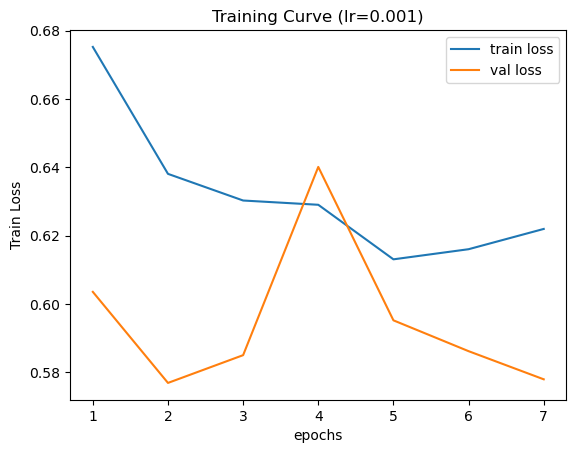

In [61]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

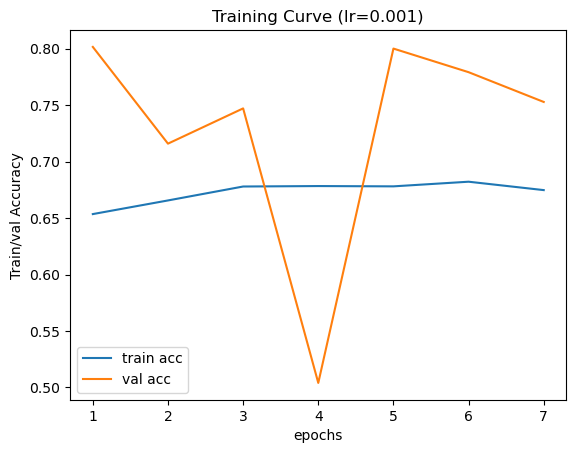

In [62]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [63]:
## saving the model 
# torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Load the model 
- if train and wants to evaluate: jsut use the `sameModelName`
- if want to laod a specific model - use next cell and write in double quote

In [64]:
model_name = saveModelName

In [65]:
# loading the locally saved model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CausalityBERT()
model.load_state_dict(torch.load(model_name))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.5.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.encoder.layer.2.attention.self.value.bias', 'roberta.encoder.layer.7.attention.output.dense.bias', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.3.output.dense.bias', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.5.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.bias'

CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

## evaluation on the test dataset 



In [66]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  3%|▎         | 1/33 [00:02<01:06,  2.09s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  6%|▌         | 2/33 [00:03<01:00,  1.97s/it]<ipython-input-55-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  9%|▉         | 3/33 [00:06<01:00,  2.02s/it]<ipyt


	test loss: nan

	test acc: 0.7398303689064558

	test prec: 0.2977683091319454

	test rec: 0.6473665223665224

	test f1: 0.38674986733669536



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [67]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', 'being', 'home', 'is', 'a', 'full', 'time', 'job', '..', 'the', 'cooking', 'for', '6', 'kids', 'and', '3', 'adults', 'of', 'which', '1', 'is', 'diabetic', 'iy@@', 'andi@@', 'q@@', 'oba', 'yer@@', 'ree', 'Jesus', 'Got', 'me', 'help', 'me', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 1

Padded Sentence:
['<s>', 'Jay@@', 'da', 'had', 'gest@@', 'ational', 'diabetes', 'and', 'it', 'sucked', 'bc', 'she', 'could', "n't", 'eat', 'anything', 'she', 'cra@@', 'ved', ':', 's@@', '<unk>', '<unk>', 'ing_@@', 'face', ':', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [68]:
# add seed => check
# add binary accuracy  => ???????
# add plot loss function accuracy => validation accu

# y - axis: loss function; validation accuracy
# x - axis: epochs


# epochs, learning rate => ok

# 90% training => 10% test  => ok
# how to use random batch of training set for validation

# clean notebook

# clean data sheet => check

# Check Pytorch: EarlyStopping add => check